In [1]:
# !pip install torch torchvision torchaudio
# !pip install dgl==1.1.2+cu117 -f https://data.dgl.ai/wheels/cu117/repo.html
# !pip install pandas numpy click matplotlib

## Import Necessary Libraries

In [2]:
import torch
import dgl
import pandas as pd
import numpy as np
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from sklearn.metrics import roc_curve, auc, matthews_corrcoef, precision_score, recall_score, f1_score, accuracy_score, hamming_loss
import matplotlib.pyplot as plt
from deepgo.data import load_data, load_normal_forms
from deepgo.utils import Ontology, propagate_annots
from deepgo.models import DeepGOModel
from deepgo.metrics import compute_roc
import warnings
warnings.filterwarnings("ignore")

## Loading Datasets and Ontology Information

In [3]:
# Load your datasets and ontology information
data_root = 'data'  # Path to the data directory
ontology = 'mf'  # Options are: 'mf', 'bp', 'cc'

go_file = f'{data_root}/go.obo'
terms_file = f'{data_root}/{ontology}/terms.pkl'

# Load GO Ontology
go = Ontology(go_file, with_rels=True)

# Load training, validation, and test data
train_data_file = f'{data_root}/{ontology}/train_data.pkl'
valid_data_file = f'{data_root}/{ontology}/valid_data.pkl'
test_data_file = f'{data_root}/{ontology}/test_data.pkl'

train_data = pd.read_pickle(train_data_file)
valid_data = pd.read_pickle(valid_data_file)
test_data = pd.read_pickle(test_data_file)

print("Train data:", train_data.shape)
print("Validation data:", valid_data.shape)
print("Test data:", test_data.shape)


Train data: (38533, 14)
Validation data: (1901, 14)
Test data: (2845, 14)


## Exploring the Training Data: Columns and Sample Rows

In [4]:
# Display the columns of the training data
train_data_columns = pd.DataFrame({
    "Column Name": train_data.columns,
    "Data Type": [train_data[col].dtype for col in train_data.columns]
})

# Display the first few rows of training data for exploration
train_data_head = train_data.head()

# Visualize the columns in a DataFrame
print("Training Data Columns:")
display(train_data_columns)

# Visualize the first few rows of training data
print("First Few Rows of Training Data:")
display(train_data_head)


Training Data Columns:


,Column Name,Data Type
0,index,int64
1,proteins,object
2,accessions,object
3,genes,object
4,sequences,object
5,annotations,object
6,string_ids,object
7,orgs,object
8,interpros,object
9,exp_annotations,object


First Few Rows of Training Data:


,index,proteins,accessions,genes,sequences,annotations,string_ids,orgs,interpros,exp_annotations,prop_annotations,cafa_target,esm,esm2
57336,400055,RPA12_YEAST,P32529; D6VWN4;,853526,MSVVGSLIFCLDCGDLLENPNAVLGSNVECSQCKAIYPKSQFSNLK...,"[GO:0005736|IDA, GO:0003676|IEA, GO:0001054|ID...",[4932.YJR063W],559292,"[IPR019761, IPR001529, IPR012164, IPR034004, I...","[GO:0005736, GO:0001054, GO:0061629, GO:000012...","[GO:1901576, GO:0006353, GO:0044271, GO:005125...",True,"[-0.030062955, 0.1718114, -0.018383306, -0.114...","[0.018639212, 0.032441415, -0.057677362, -0.06..."
11761,65680,CHSTF_HUMAN,Q7LFX5; O60338; O60474; Q86VM4;,51363,MRHCINCCIQLLPDGAHKQQVNCQGGPHHGHQACPTCKGENKILFR...,"[GO:0000139|TAS, GO:0016021|NAS, GO:0050656|ID...",[9606.ENSP00000402394],9606,[IPR027417],"[GO:0000139, GO:0050656, GO:0050659, GO:003020...","[GO:1901566, GO:1901576, GO:0050650, GO:000013...",True,"[-0.02066653, 0.29075465, -0.038742084, 0.0310...","[0.0043747886, -0.052219868, 0.011461016, -0.0..."
41913,272493,NDST1_RAT,Q02353;,29633,MPALACLRRLCRHLSPQAVLFLLFVFCLFSVFVSAYYLYGWNRGLE...,"[GO:0005794|IBA, GO:0000139|IEA, GO:0016021|IE...",[10116.ENSRNOP00000025881],10116,"[IPR021930, IPR037359, IPR027417, IPR000863]","[GO:0015016, GO:0102140, GO:0015012]","[GO:0015012, GO:0043170, GO:1901566, GO:190157...",True,"[-0.1794068, 0.28359434, -0.0051693786, 0.0373...","[-0.09481012, -0.043351002, -0.0006692707, -0...."
41912,272492,NDST1_MOUSE,Q3UHN9; O70353; Q3TBX3; Q3TDS3; Q8BZE5; Q9R206;,15531,MPALACLRRLCRHLSPQAVLFLLFVFCLFSVFVSAYYLYGWNRGLE...,"[GO:0005794|IBA, GO:0000139|IEA, GO:0016021|IE...",[10090.ENSMUSP00000126623],10090,"[IPR021930, IPR037359, IPR027417, IPR000863]","[GO:0019213, GO:0008146, GO:0009887, GO:003590...","[GO:0007169, GO:1901576, GO:0071774, GO:004859...",True,"[-0.18163793, 0.28531843, -0.0069247806, 0.038...","[-0.09788561, -0.04282326, -0.001072437, -0.13..."
41911,272491,NDST1_HUMAN,P52848; Q96E57;,3340,MPALACLRRLCRHVSPQAVLFLLFIFCLFSVFISAYYLYGWKRGLE...,"[GO:0005794|IBA, GO:0000139|TAS, GO:0016021|IE...",[9606.ENSP00000261797],9606,"[IPR021930, IPR037359, IPR027417, IPR000863]","[GO:0000139, GO:0050119, GO:0006024]","[GO:0005737, GO:0043170, GO:0043227, GO:190156...",True,"[-0.17954886, 0.2798644, -0.010667691, 0.03733...","[-0.09880749, -0.045400932, -0.0041419365, -0...."


## Loading and Visualizing the `terms.pkl` File

In [5]:
# Load the terms.pkl file and visualize it as a DataFrame
terms_data = pd.read_pickle(terms_file)

# Visualize the terms.pkl content
terms_data_head = terms_data.head()  # Display the first few rows of terms

print("First Few Rows of terms.pkl Data:")
display(terms_data_head)


First Few Rows of terms.pkl Data:


,gos
0,GO:0045735
1,GO:0097367
2,GO:0097159
3,GO:0036094
4,GO:0035639


## Counting and Comparing Unique GO Terms in Training Data and `terms.pkl`

In [6]:
# Count unique GO terms in training data
unique_go_terms_train = set(term for terms in train_data['prop_annotations'] for term in terms)
print(f"Total number of unique GO terms in the training data: {len(unique_go_terms_train)}")

# Load terms.pkl and count unique GO terms
terms_data = pd.read_pickle(terms_file)
unique_go_terms_terms_pkl = set(terms_data['gos'].values.flatten())
print(f"Total number of unique GO terms in the terms.pkl file: {len(unique_go_terms_terms_pkl)}")

# Compare overlap
missing_in_terms_pkl = unique_go_terms_train - unique_go_terms_terms_pkl
missing_in_train_data = unique_go_terms_terms_pkl - unique_go_terms_train
print(f"GO terms in training data but not in terms.pkl: {len(missing_in_terms_pkl)}")
print(f"GO terms in terms.pkl but not in training data: {len(missing_in_train_data)}")


Total number of unique GO terms in the training data: 29107
Total number of unique GO terms in the terms.pkl file: 6851
GO terms in training data but not in terms.pkl: 22683
GO terms in terms.pkl but not in training data: 427


## Visualizing the Top 20 Most Frequent GO Terms in the Training Data

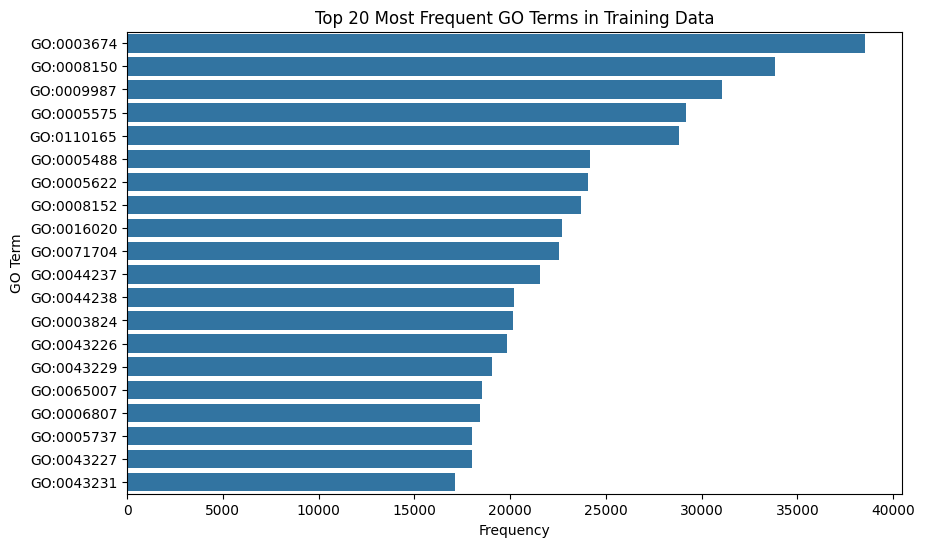

In [7]:
from collections import Counter
import seaborn as sns

# Flatten the list of GO term annotations
all_go_terms = [term for terms in train_data['prop_annotations'] for term in terms]
go_term_counts = Counter(all_go_terms)

# Get the top 20 most frequent GO terms
most_common_terms = go_term_counts.most_common(20)
terms, counts = zip(*most_common_terms)

# Plot the top 20 most frequent GO terms
plt.figure(figsize=(10, 6))
sns.barplot(x=counts, y=terms)
plt.title('Top 20 Most Frequent GO Terms in Training Data')
plt.xlabel('Frequency')
plt.ylabel('GO Term')
plt.show()


## Distribution of the Number of GO Terms per Protein

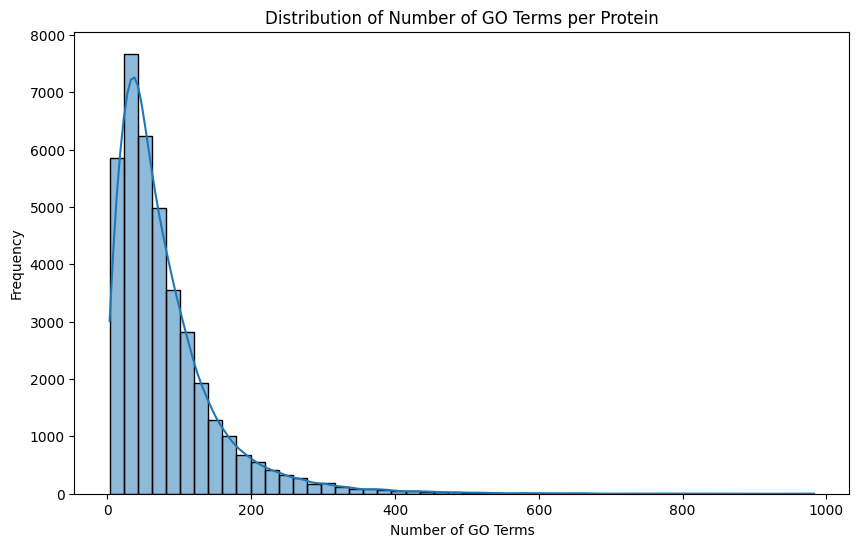

In [8]:
plt.figure(figsize=(10, 6))
sns.histplot([len(terms) for terms in train_data['prop_annotations']], bins=50, kde=True)
plt.title("Distribution of Number of GO Terms per Protein")
plt.xlabel("Number of GO Terms")
plt.ylabel("Frequency")
plt.show()


## Binned Distribution of GO Annotations per Protein

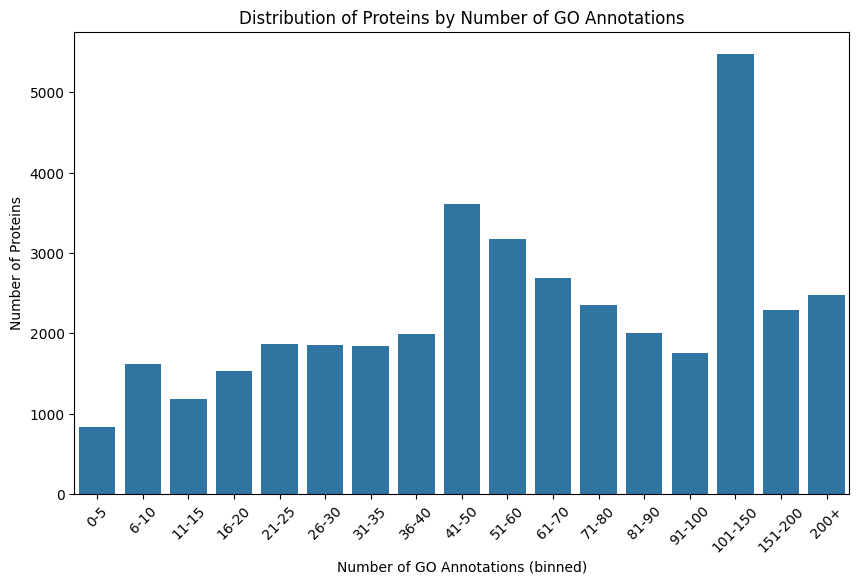

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the number of GO annotations (annotations) per protein
train_data['num_go_terms'] = train_data['prop_annotations'].apply(lambda x: len(eval(x)) if isinstance(x, str) else len(x))

# Create more detailed bins, especially for values greater than 40
bins = [0, 5, 10, 15, 20, 25, 30, 35, 40, 50, 60, 70, 80, 90, 100, 150, 200, float('inf')]  # More granular bins for 40+
bin_labels = ['0-5', '6-10', '11-15', '16-20', '21-25', '26-30', '31-35', '36-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100', '101-150', '151-200', '200+']

train_data['annotation_bins'] = pd.cut(train_data['num_go_terms'], bins, labels=bin_labels)

# Count the number of proteins in each bin
annotation_distribution = train_data['annotation_bins'].value_counts().sort_index()

# Plot the distribution of proteins by number of GO annotations (annotations)
plt.figure(figsize=(10, 6))
sns.barplot(x=annotation_distribution.index, y=annotation_distribution.values)
plt.title('Distribution of Proteins by Number of GO Annotations')
plt.xlabel('Number of GO Annotations (binned)')
plt.ylabel('Number of Proteins')
plt.xticks(rotation=45)
plt.show()


# Generate ProtT5 Embeddings

In [ ]:
# Install necessary packages
# !pip install transformers==4.31.0 sentencepiece

# Import necessary libraries
from transformers import T5Tokenizer, T5EncoderModel
import torch
from tqdm import tqdm
import re

# Load the tokenizer and model
tokenizer_prott5 = T5Tokenizer.from_pretrained('Rostlab/prot_t5_xl_uniref50', do_lower_case=False)
model_prott5 = T5EncoderModel.from_pretrained('Rostlab/prot_t5_xl_uniref50')
model_prott5.eval()

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_prott5.to(device)

# Function to preprocess sequences
def preprocess_sequence(seq):
    # Replace rare amino acids with 'X'
    seq = re.sub(r'[UZOB]', 'X', seq)
    # Add spaces between amino acids
    seq = ' '.join(list(seq))
    return seq

# Function to generate embeddings in batches
def generate_prott5_embeddings(sequences, batch_size=4):
    embeddings = []
    sequences = sequences.tolist()
    with torch.no_grad():
        for i in tqdm(range(0, len(sequences), batch_size), desc="Generating ProtT5 Embeddings"):
            batch_seqs = sequences[i:i+batch_size]
            # Preprocess sequences
            batch_seqs = [preprocess_sequence(seq) for seq in batch_seqs]
            # Tokenize and encode sequences
            tokens = tokenizer_prott5(batch_seqs, return_tensors='pt', padding=True, truncation=True, max_length=1022)
            # Move tokens to the same device as the model
            tokens = {key: val.to(device) for key, val in tokens.items()}
            # Get embeddings from the model
            outputs = model_prott5(**tokens)
            # Mean pool over the sequence length dimension to get fixed-size embeddings
            batch_embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
            embeddings.extend(batch_embeddings)
    return embeddings

# Generate embeddings for train, valid, and test datasets
train_data['prott5'] = generate_prott5_embeddings(train_data['sequences'])
valid_data['prott5'] = generate_prott5_embeddings(valid_data['sequences'])
test_data['prott5'] = generate_prott5_embeddings(test_data['sequences'])

# Display the first few rows to verify the new column
print("First Few Rows with ProtT5 Embeddings:")
display(train_data.head())


## Generate TAPE Embeddings

In [ ]:
# Install necessary packages
# !pip install tape-proteins

# Import necessary libraries
from tape import ProteinBertModel, TAPETokenizer
import torch
from tqdm import tqdm
import re
from torch.nn.utils.rnn import pad_sequence

# Load the tokenizer and model
tokenizer_tape = TAPETokenizer(vocab='iupac')
model_tape = ProteinBertModel.from_pretrained('bert-base')
model_tape.eval()

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_tape.to(device)

# Get the padding token ID
pad_token_id = tokenizer_tape.convert_token_to_id('<pad>')

# Function to preprocess sequences
def preprocess_sequence(seq):
    # Replace rare amino acids with 'X' and truncate long sequences if necessary
    seq = re.sub(r'[UZOB]', 'X', seq)
    max_length = 1022  # Reserve space for special tokens
    return seq[:max_length]

# Function to generate embeddings in batches
def generate_tape_embeddings(sequences, batch_size=32):
    embeddings = []
    sequences = sequences.tolist()
    with torch.no_grad():
        for i in tqdm(range(0, len(sequences), batch_size), desc="Generating TAPE Embeddings"):
            batch_seqs = sequences[i:i+batch_size]
            # Preprocess sequences
            batch_seqs = [preprocess_sequence(seq) for seq in batch_seqs]
            # Tokenize and encode sequences individually
            tokens = [torch.tensor(tokenizer_tape.encode(seq), dtype=torch.long) for seq in batch_seqs]
            # Pad sequences to the same length
            tokens_padded = pad_sequence(tokens, batch_first=True, padding_value=pad_token_id)
            # Move tokens to the same device as the model
            tokens_padded = tokens_padded.to(device)
            # Get embeddings from the model
            outputs = model_tape(tokens_padded)
            # outputs[0] contains the hidden states
            # Mean pool over the sequence length dimension to get fixed-size embeddings
            batch_embeddings = outputs[0].mean(dim=1).cpu().numpy()
            embeddings.extend(batch_embeddings)
    return embeddings

# Generate embeddings for train, valid, and test datasets
train_data['tape'] = generate_tape_embeddings(train_data['sequences'])
valid_data['tape'] = generate_tape_embeddings(valid_data['sequences'])
test_data['tape'] = generate_tape_embeddings(test_data['sequences'])

# Display the first few rows to verify the new column
print("First Few Rows with TAPE Embeddings:")
display(train_data.head())


## Generate Protbert Embeddings

In [ ]:
# Install necessary packages
# !pip install transformers==4.31.0 sentencepiece

# Import necessary libraries
from transformers import BertTokenizer, BertModel
import torch
from tqdm import tqdm
import re

# Load the tokenizer and model
tokenizer = BertTokenizer.from_pretrained('Rostlab/prot_bert', do_lower_case=False)
model = BertModel.from_pretrained('Rostlab/prot_bert')
model.eval()

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Function to preprocess sequences
def preprocess_sequence(seq):
    # Replace non-standard amino acids with 'X'
    seq = re.sub(r'[UZOB]', 'X', seq)
    # Add spaces between amino acids
    seq = ' '.join(list(seq))
    return seq

# Function to generate embeddings in batches
def generate_protbert_embeddings(sequences, batch_size=32):
    embeddings = []
    sequences = sequences.tolist()
    with torch.no_grad():
        for i in tqdm(range(0, len(sequences), batch_size), desc="Generating ProtBert Embeddings"):
            batch_seqs = sequences[i:i+batch_size]
            # Filter out empty or invalid sequences
            valid_seqs = []
            valid_indices = []
            for idx, seq in enumerate(batch_seqs):
                if isinstance(seq, str) and len(seq) > 0:
                    valid_seqs.append(seq)
                    valid_indices.append(idx)
                else:
                    embeddings.append(None)
            if not valid_seqs:
                continue
            # Preprocess sequences
            batch_seqs = [preprocess_sequence(seq) for seq in valid_seqs]
            # Tokenize and encode
            tokens = tokenizer(batch_seqs, return_tensors='pt', padding=True, truncation=True, max_length=512)
            tokens = {key: val.to(device) for key, val in tokens.items()}
            outputs = model(**tokens)
            batch_embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
            # Map embeddings back to original indices
            emb_idx = 0
            for idx in range(len(batch_seqs)):
                embeddings.append(batch_embeddings[emb_idx])
                emb_idx += 1
    return embeddings

# Generate embeddings for train, valid, and test datasets
train_data['protbert'] = generate_protbert_embeddings(train_data['sequences'])
valid_data['protbert'] = generate_protbert_embeddings(valid_data['sequences'])
test_data['protbert'] = generate_protbert_embeddings(test_data['sequences'])

# Display the first few rows to verify the new column
print("First Few Rows with ProtBert Embeddings:")
display(train_data.head())


In [ ]:
# # Define output file paths
# train_data_file = f'{data_root}/{ontology}/train_data_with_embeddings.pkl'
# valid_data_file = f'{data_root}/{ontology}/valid_data_with_embeddings.pkl'
# test_data_file = f'{data_root}/{ontology}/test_data_with_embeddings.pkl'

# # Save DataFrames with embeddings
# train_data.to_pickle(train_data_file)
# valid_data.to_pickle(valid_data_file)
# test_data.to_pickle(test_data_file)

# print("DataFrames with embeddings saved successfully.")


In [10]:
# Define output file paths
train_data_file = f'{data_root}/{ontology}/train_data_with_embeddings.pkl'
valid_data_file = f'{data_root}/{ontology}/valid_data_with_embeddings.pkl'
test_data_file = f'{data_root}/{ontology}/test_data_with_embeddings.pkl'

# Load the saved DataFrames with embeddings
train_data = pd.read_pickle(train_data_file)
valid_data = pd.read_pickle(valid_data_file)
test_data = pd.read_pickle(test_data_file)

print("DataFrames with embeddings loaded successfully.")


DataFrames with embeddings loaded successfully.


## Testing different embeddings and model comnbinations

In [13]:
# --- Import Necessary Libraries ---
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import pandas as pd
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, accuracy_score, hamming_loss

# --- Data Preparation ---

# Convert embeddings from the train, valid, and test datasets into feature matrices

# ESM2 Embeddings
X_train_esm2 = np.stack(train_data['esm2'].values)
X_valid_esm2 = np.stack(valid_data['esm2'].values)
X_test_esm2 = np.stack(test_data['esm2'].values)

# ProtBert Embeddings
X_train_protbert = np.stack(train_data['protbert'].values)
X_valid_protbert = np.stack(valid_data['protbert'].values)
X_test_protbert = np.stack(test_data['protbert'].values)

# ProtT5 Embeddings
X_train_prott5 = np.stack(train_data['prott5'].values)
X_valid_prott5 = np.stack(valid_data['prott5'].values)
X_test_prott5 = np.stack(test_data['prott5'].values)

# TAPE Embeddings
X_train_tape = np.stack(train_data['tape'].values)
X_valid_tape = np.stack(valid_data['tape'].values)
X_test_tape = np.stack(test_data['tape'].values)

# Multi-hot encode the InterPro annotations
mlb_interpros = MultiLabelBinarizer()
interpros_train = mlb_interpros.fit_transform(train_data['interpros'].values)
interpros_valid = mlb_interpros.transform(valid_data['interpros'].values)
interpros_test = mlb_interpros.transform(test_data['interpros'].values)

# Convert labels to torch tensors
mlb = MultiLabelBinarizer()
y_train = mlb.fit_transform(train_data['prop_annotations'].values)
y_valid = mlb.transform(valid_data['prop_annotations'].values)
y_test = mlb.transform(test_data['prop_annotations'].values)

y_train = torch.tensor(y_train, dtype=torch.float32)
y_valid = torch.tensor(y_valid, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Function to convert numpy arrays to torch tensors
def to_tensor(x):
    return torch.tensor(x, dtype=torch.float32)

# --- Prepare DataLoaders for Each Embedding Type and Model Variant ---

# Dataset for models that take a single input (embedding-only or concatenated features)
class ProteinDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Dataset for models that take separate inputs (embedding and interpros separately)
class ProteinDatasetSeparate(Dataset):
    def __init__(self, X_embedding, X_interpros, y):
        self.X_embedding = X_embedding
        self.X_interpros = X_interpros
        self.y = y
    
    def __len__(self):
        return len(self.X_embedding)
    
    def __getitem__(self, idx):
        return self.X_embedding[idx], self.X_interpros[idx], self.y[idx]

# Dictionary to store DataLoaders
train_loaders = {}
valid_loaders = {}
test_loaders = {}

embedding_types = ['esm2']# ['esm2', 'protbert', 'prott5', 'tape']
for embedding in embedding_types:
    # Get the variables dynamically
    X_train_embed = globals()[f'X_train_{embedding}']
    X_valid_embed = globals()[f'X_valid_{embedding}']
    X_test_embed = globals()[f'X_test_{embedding}']
    
    X_train_embed = to_tensor(X_train_embed)
    X_valid_embed = to_tensor(X_valid_embed)
    X_test_embed = to_tensor(X_test_embed)
    
    # Combined features (embedding + InterPros)
    X_train_combined = np.concatenate([X_train_embed.numpy(), interpros_train], axis=1)
    X_valid_combined = np.concatenate([X_valid_embed.numpy(), interpros_valid], axis=1)
    X_test_combined = np.concatenate([X_test_embed.numpy(), interpros_test], axis=1)
    
    X_train_combined = to_tensor(X_train_combined)
    X_valid_combined = to_tensor(X_valid_combined)
    X_test_combined = to_tensor(X_test_combined)
    
    # InterPros as tensors
    interpros_train_tensor = to_tensor(interpros_train)
    interpros_valid_tensor = to_tensor(interpros_valid)
    interpros_test_tensor = to_tensor(interpros_test)
    
    # Embedding-only DataLoaders
    train_dataset_embed = ProteinDataset(X_train_embed, y_train)
    valid_dataset_embed = ProteinDataset(X_valid_embed, y_valid)
    test_dataset_embed = ProteinDataset(X_test_embed, y_test)
    
    train_loaders[f'{embedding}_only'] = DataLoader(train_dataset_embed, batch_size=32, shuffle=True)
    valid_loaders[f'{embedding}_only'] = DataLoader(valid_dataset_embed, batch_size=32, shuffle=False)
    test_loaders[f'{embedding}_only'] = DataLoader(test_dataset_embed, batch_size=32, shuffle=False)
    
    # Concatenated DataLoaders
    train_dataset_concat = ProteinDataset(X_train_combined, y_train)
    valid_dataset_concat = ProteinDataset(X_valid_combined, y_valid)
    test_dataset_concat = ProteinDataset(X_test_combined, y_test)
    
    train_loaders[f'{embedding}_concat'] = DataLoader(train_dataset_concat, batch_size=32, shuffle=True)
    valid_loaders[f'{embedding}_concat'] = DataLoader(valid_dataset_concat, batch_size=32, shuffle=False)
    test_loaders[f'{embedding}_concat'] = DataLoader(test_dataset_concat, batch_size=32, shuffle=False)
    
    # Separate Processing DataLoaders
    train_dataset_separate = ProteinDatasetSeparate(X_train_embed, interpros_train_tensor, y_train)
    valid_dataset_separate = ProteinDatasetSeparate(X_valid_embed, interpros_valid_tensor, y_valid)
    test_dataset_separate = ProteinDatasetSeparate(X_test_embed, interpros_test_tensor, y_test)
    
    train_loaders[f'{embedding}_separate'] = DataLoader(train_dataset_separate, batch_size=32, shuffle=True)
    valid_loaders[f'{embedding}_separate'] = DataLoader(valid_dataset_separate, batch_size=32, shuffle=False)
    test_loaders[f'{embedding}_separate'] = DataLoader(test_dataset_separate, batch_size=32, shuffle=False)

# --- Model Definitions ---

# Define the baseline model class
class BaselineProteinGOClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(BaselineProteinGOClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, num_classes)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

# Define the concatenation model class
class BaselineProteinGOClassifierWithConcat(nn.Module):
    def __init__(self, input_size_embedding, input_size_interpros, num_classes):
        super(BaselineProteinGOClassifierWithConcat, self).__init__()
        self.fc1 = nn.Linear(input_size_embedding + input_size_interpros, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, num_classes)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

# Define the separate processing model class
class BaselineProteinGOClassifierWithSeparate(nn.Module):
    def __init__(self, input_size_embedding, input_size_interpros, num_classes):
        super(BaselineProteinGOClassifierWithSeparate, self).__init__()
        self.fc1_embedding = nn.Linear(input_size_embedding, 512)
        self.fc1_interpros = nn.Linear(input_size_interpros, 512)
        self.fc2 = nn.Linear(512 * 2, 512)
        self.fc3 = nn.Linear(512, num_classes)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x_embedding, x_interpros):
        # Separate forward passes
        x_embedding = torch.relu(self.fc1_embedding(x_embedding))
        x_interpros = torch.relu(self.fc1_interpros(x_interpros))
        
        # Concatenate embeddings and interpros
        x = torch.cat([x_embedding, x_interpros], dim=1)
        x = torch.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

# --- Model Initialization and Optimizers ---

num_classes = y_train.shape[1]
input_size_interpros = interpros_train.shape[1]

models = {}
optimizers = {}

for embedding in embedding_types:
    # Get input sizes
    input_size_embedding = globals()[f'X_train_{embedding}'].shape[1]
    
    # Embedding-only model
    model_only = BaselineProteinGOClassifier(input_size_embedding, num_classes)
    optimizer_only = optim.Adam(model_only.parameters(), lr=0.001)
    models[f'{embedding}_only'] = model_only
    optimizers[f'{embedding}_only'] = optimizer_only
    
    # # Concatenated model
    # model_concat = BaselineProteinGOClassifierWithConcat(input_size_embedding, input_size_interpros, num_classes)
    # optimizer_concat = optim.Adam(model_concat.parameters(), lr=0.001)
    # models[f'{embedding}_concat'] = model_concat
    # optimizers[f'{embedding}_concat'] = optimizer_concat
    
    # # Separate processing model
    # model_separate = BaselineProteinGOClassifierWithSeparate(input_size_embedding, input_size_interpros, num_classes)
    # optimizer_separate = optim.Adam(model_separate.parameters(), lr=0.001)
    # models[f'{embedding}_separate'] = model_separate
    # optimizers[f'{embedding}_separate'] = optimizer_separate

# --- Training Loop ---

# Check if a GPU is available and use it
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Move models to device
for model in models.values():
    model.to(device)

# Define the loss function
criterion = nn.BCELoss()

# Save model checkpoint function
def save_checkpoint(model, model_name, epoch):
    torch.save(model.state_dict(), f"{model_name}_epoch_{epoch+1}.pth")
    print(f"Checkpoint saved for {model_name} at epoch {epoch+1}")

# Training loop function
def train_model(model, train_loader, valid_loader, optimizer, criterion, model_name, num_epochs=10):
    train_hamming_losses = []
    valid_hamming_losses = []

    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0

        # Wrap the DataLoader with tqdm for a progress bar
        with tqdm(train_loader, desc=f"{model_name} - Epoch {epoch+1}/{num_epochs}", unit="batch") as tepoch:
            for batch in tepoch:
                optimizer.zero_grad()  # Zero the gradients

                if isinstance(train_loader.dataset, ProteinDatasetSeparate):
                    inputs_embedding, inputs_interpros, labels = batch
                    inputs_embedding, inputs_interpros, labels = inputs_embedding.to(device), inputs_interpros.to(device), labels.to(device)
                    outputs = model(inputs_embedding, inputs_interpros)
                else:
                    inputs, labels = batch
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)

                # Compute loss and backpropagate
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                tepoch.set_postfix(loss=running_loss / (tepoch.n or 1))

        # Compute Hamming Loss on training data after each epoch
        train_hamming = evaluate_hamming_loss(train_loader, model)
        train_hamming_losses.append(train_hamming)

        # Compute Hamming Loss on validation data after each epoch
        valid_hamming = evaluate_hamming_loss(valid_loader, model)
        valid_hamming_losses.append(valid_hamming)

        # Print loss and Hamming Loss
        print(f'{model_name} - Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}, Train Hamming Loss: {train_hamming:.4f}, Valid Hamming Loss: {valid_hamming:.4f}')

    return train_hamming_losses, valid_hamming_losses

        # Optionally save checkpoints
        # save_checkpoint(model, model_name, epoch)

def evaluate_hamming_loss(loader, model):
    model.eval()  # Set the model to evaluation mode
    all_labels = []
    all_outputs = []

    # Ensure the model is on the same device as the inputs
    device = next(model.parameters()).device

    with torch.no_grad():
        for batch in loader:
            if isinstance(loader.dataset, ProteinDatasetSeparate):
                inputs_embedding, inputs_interpros, labels = batch
                inputs_embedding, inputs_interpros, labels = inputs_embedding.to(device), inputs_interpros.to(device), labels.to(device)
                outputs = model(inputs_embedding, inputs_interpros)
            else:
                inputs, labels = batch
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)

            all_labels.append(labels)
            all_outputs.append(outputs)

    # Concatenate the outputs and labels
    all_labels = torch.cat(all_labels).cpu().numpy()
    all_outputs = torch.cat(all_outputs).cpu().numpy()

    # Binarize outputs using a threshold (e.g., 0.5)
    predicted_labels = (all_outputs > 0.5).astype(int)

    # Compute Hamming Loss
    hamming = hamming_loss(all_labels, predicted_labels)

    return hamming



# Train each model
num_epochs = 15
hamming_loss_history = {}  # Dictionary to store Hamming Loss histories

for model_name in models:
    print(f"\nTraining model: {model_name}")
    model = models[model_name]
    optimizer = optimizers[model_name]
    train_loader = train_loaders[model_name]
    valid_loader = valid_loaders[model_name]

    # Train the model and collect Hamming Loss histories
    train_hamming_losses, valid_hamming_losses = train_model(model, train_loader, valid_loader, optimizer, criterion, model_name, num_epochs=num_epochs)

    # Store the Hamming Loss histories
    hamming_loss_history[model_name] = {
        'train': train_hamming_losses,
        'valid': valid_hamming_losses
    }
# --- Evaluation Function ---




def evaluate_model(loader, model):
    model.eval()  # Set the model to evaluation mode
    all_labels = []
    all_outputs = []

    # Ensure the model is on the same device as the inputs
    device = next(model.parameters()).device
    
    with torch.no_grad():  # Disable gradient calculations during evaluation
        for batch in loader:
            if isinstance(loader.dataset, ProteinDatasetSeparate):
                inputs_embedding, inputs_interpros, labels = batch
                inputs_embedding, inputs_interpros, labels = inputs_embedding.to(device), inputs_interpros.to(device), labels.to(device)
                outputs = model(inputs_embedding, inputs_interpros)
            else:
                inputs, labels = batch
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
            
            all_labels.append(labels)
            all_outputs.append(outputs)
    
    # Concatenate the outputs and labels
    all_labels = torch.cat(all_labels).cpu().numpy()
    all_outputs = torch.cat(all_outputs).cpu().numpy()
    
    # Compute evaluation metrics
    try:
        roc_auc = roc_auc_score(all_labels, all_outputs, average='micro')
    except ValueError:
        roc_auc = float('nan')
    
    predicted_labels = (all_outputs > 0.5).astype(int)
    
    precision = precision_score(all_labels, predicted_labels, average='micro', zero_division=0)
    recall = recall_score(all_labels, predicted_labels, average='micro', zero_division=0)
    f1 = f1_score(all_labels, predicted_labels, average='micro', zero_division=0)
    subset_acc = accuracy_score(all_labels, predicted_labels)
    hamming = hamming_loss(all_labels, predicted_labels)
    
    return {
        "ROC AUC": roc_auc,
        "Hamming Loss": hamming,
        "Subset Accuracy": subset_acc,
        "Precision": precision,
        "Recall": recall,
        "F1-score": f1
    }

# --- Evaluation of Each Model and Compilation of Metrics ---

evaluation_metrics = {}

for model_name in models:
    print(f"\nEvaluating model: {model_name}")
    model = models[model_name]
    valid_loader = valid_loaders[model_name]
    metrics = evaluate_model(valid_loader, model)
    evaluation_metrics[model_name] = metrics

# --- Compile Metrics into a Summary Table ---

summary_data = []

for model_name, metrics in evaluation_metrics.items():
    # Parse model_name
    embedding_type, processing = model_name.split('_', 1)
    processing = processing.replace('only', 'Embedding Only').replace('concat', 'Concatenated').replace('separate', 'Separate Processing')
    embedding_type = embedding_type.upper()
    
    # Create a dictionary for this model's metrics
    model_metrics = {
        'Embedding': embedding_type,
        'Processing': processing
    }
    model_metrics.update(metrics)
    
    summary_data.append(model_metrics)

# Create DataFrame
summary_table = pd.DataFrame(summary_data)

# Reorder columns
summary_table = summary_table[['Embedding', 'Processing', 'ROC AUC', 'Hamming Loss', 'Subset Accuracy', 'Precision', 'Recall', 'F1-score']]

# Sort the table for better readability
summary_table = summary_table.sort_values(by=['Embedding', 'Processing'])

# Display the summary table
print("\nEvaluation Metrics Summary Table:")
display(summary_table)

Using device: cuda

Training model: esm2_only


esm2_only - Epoch 1/15: 100%|█████████████████████████████████████| 1205/1205 [00:09<00:00, 129.95batch/s, loss=0.0142]


esm2_only - Epoch [1/15], Loss: 0.0141, Train Hamming Loss: 0.0024, Valid Hamming Loss: 0.0020


esm2_only - Epoch 2/15: 100%|█████████████████████████████████████| 1205/1205 [00:15<00:00, 76.14batch/s, loss=0.00954]


esm2_only - Epoch [2/15], Loss: 0.0095, Train Hamming Loss: 0.0024, Valid Hamming Loss: 0.0019


esm2_only - Epoch 3/15: 100%|█████████████████████████████████████| 1205/1205 [00:20<00:00, 58.89batch/s, loss=0.00891]


esm2_only - Epoch [3/15], Loss: 0.0089, Train Hamming Loss: 0.0023, Valid Hamming Loss: 0.0019


esm2_only - Epoch 4/15: 100%|█████████████████████████████████████| 1205/1205 [00:20<00:00, 57.74batch/s, loss=0.00849]


esm2_only - Epoch [4/15], Loss: 0.0085, Train Hamming Loss: 0.0023, Valid Hamming Loss: 0.0019


esm2_only - Epoch 5/15: 100%|█████████████████████████████████████| 1205/1205 [00:17<00:00, 70.04batch/s, loss=0.00818]


esm2_only - Epoch [5/15], Loss: 0.0081, Train Hamming Loss: 0.0022, Valid Hamming Loss: 0.0019


esm2_only - Epoch 6/15: 100%|█████████████████████████████████████| 1205/1205 [00:20<00:00, 59.99batch/s, loss=0.00789]


esm2_only - Epoch [6/15], Loss: 0.0079, Train Hamming Loss: 0.0022, Valid Hamming Loss: 0.0019


esm2_only - Epoch 7/15: 100%|█████████████████████████████████████| 1205/1205 [00:24<00:00, 49.90batch/s, loss=0.00761]


esm2_only - Epoch [7/15], Loss: 0.0076, Train Hamming Loss: 0.0022, Valid Hamming Loss: 0.0019


esm2_only - Epoch 8/15: 100%|██████████████████████████████████████| 1205/1205 [00:23<00:00, 50.31batch/s, loss=0.0074]


esm2_only - Epoch [8/15], Loss: 0.0074, Train Hamming Loss: 0.0021, Valid Hamming Loss: 0.0019


esm2_only - Epoch 9/15: 100%|████████████████████████████████████| 1205/1205 [00:09<00:00, 120.89batch/s, loss=0.00723]


esm2_only - Epoch [9/15], Loss: 0.0071, Train Hamming Loss: 0.0021, Valid Hamming Loss: 0.0019


esm2_only - Epoch 10/15: 100%|████████████████████████████████████| 1205/1205 [00:21<00:00, 55.07batch/s, loss=0.00697]


esm2_only - Epoch [10/15], Loss: 0.0069, Train Hamming Loss: 0.0021, Valid Hamming Loss: 0.0019


esm2_only - Epoch 11/15: 100%|████████████████████████████████████| 1205/1205 [00:23<00:00, 51.68batch/s, loss=0.00676]


esm2_only - Epoch [11/15], Loss: 0.0068, Train Hamming Loss: 0.0021, Valid Hamming Loss: 0.0019


esm2_only - Epoch 12/15: 100%|████████████████████████████████████| 1205/1205 [00:24<00:00, 49.89batch/s, loss=0.00659]


esm2_only - Epoch [12/15], Loss: 0.0066, Train Hamming Loss: 0.0020, Valid Hamming Loss: 0.0019


esm2_only - Epoch 13/15: 100%|████████████████████████████████████| 1205/1205 [00:15<00:00, 77.28batch/s, loss=0.00645]


esm2_only - Epoch [13/15], Loss: 0.0064, Train Hamming Loss: 0.0020, Valid Hamming Loss: 0.0019


esm2_only - Epoch 14/15: 100%|████████████████████████████████████| 1205/1205 [00:12<00:00, 99.17batch/s, loss=0.00634]


esm2_only - Epoch [14/15], Loss: 0.0063, Train Hamming Loss: 0.0020, Valid Hamming Loss: 0.0019


esm2_only - Epoch 15/15: 100%|███████████████████████████████████| 1205/1205 [00:09<00:00, 123.43batch/s, loss=0.00621]


esm2_only - Epoch [15/15], Loss: 0.0061, Train Hamming Loss: 0.0019, Valid Hamming Loss: 0.0019

Evaluating model: esm2_only

Evaluation Metrics Summary Table:


,Embedding,Processing,ROC AUC,Hamming Loss,Subset Accuracy,Precision,Recall,F1-score
0,ESM2,Embedding Only,0.980956,0.001895,0.000526,0.657642,0.320897,0.431327


## Incorporating GO axioms data as constrints to modify loss funtion 

In [13]:
# --- Import Necessary Libraries ---
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import pandas as pd
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, accuracy_score, hamming_loss
from deepgo.utils import Ontology
from deepgo.data import load_normal_forms
import warnings
warnings.filterwarnings("ignore")

# --- Configuration and Paths ---
data_root = 'data'  # Path to the data directory
ontology = 'mf'     # Options are: 'mf' (Molecular Function), 'bp' (Biological Process), 'cc' (Cellular Component)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

go_file = f'{data_root}/go.obo'
go_norm_file = f'{data_root}/go.norm'  # Adjust the path if different

# Define data file paths
train_data_file = f'{data_root}/{ontology}/train_data_with_embeddings.pkl'
valid_data_file = f'{data_root}/{ontology}/valid_data_with_embeddings.pkl'
test_data_file = f'{data_root}/{ontology}/test_data_with_embeddings.pkl'

# --- Data Preparation ---

# Load DataFrames with Embeddings
train_data = pd.read_pickle(train_data_file)
valid_data = pd.read_pickle(valid_data_file)
test_data = pd.read_pickle(test_data_file)

print("DataFrames with embeddings loaded successfully.")
print("Available columns in train_data:", train_data.columns.tolist())

# Function to convert numpy arrays to torch tensors
def to_tensor(x):
    return torch.tensor(x, dtype=torch.float32)

# ESM2 Embeddings
X_train_esm2 = np.stack(train_data['esm2'].values)
X_valid_esm2 = np.stack(valid_data['esm2'].values)
X_test_esm2 = np.stack(test_data['esm2'].values)

# ProtBert Embeddings
X_train_protbert = np.stack(train_data['protbert'].values)
X_valid_protbert = np.stack(valid_data['protbert'].values)
X_test_protbert = np.stack(test_data['protbert'].values)

# ProtT5 Embeddings
X_train_prott5 = np.stack(train_data['prott5'].values)
X_valid_prott5 = np.stack(valid_data['prott5'].values)
X_test_prott5 = np.stack(test_data['prott5'].values)

# TAPE Embeddings
X_train_tape = np.stack(train_data['tape'].values)
X_valid_tape = np.stack(valid_data['tape'].values)
X_test_tape = np.stack(test_data['tape'].values)

# Multi-hot encode the InterPro annotations
mlb_interpros = MultiLabelBinarizer()
interpros_train = mlb_interpros.fit_transform(train_data['interpros'].values)
interpros_valid = mlb_interpros.transform(valid_data['interpros'].values)
interpros_test = mlb_interpros.transform(test_data['interpros'].values)

# Convert labels to torch tensors
mlb = MultiLabelBinarizer()
y_train = mlb.fit_transform(train_data['prop_annotations'].values)
y_valid = mlb.transform(valid_data['prop_annotations'].values)
y_test = mlb.transform(test_data['prop_annotations'].values)

y_train = torch.tensor(y_train, dtype=torch.float32)
y_valid = torch.tensor(y_valid, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# --- Load GO Axioms (Normal Forms) and Align Indices ---

# Create terms_dict from label classes
term_list = mlb.classes_
terms_dict = {term: idx for idx, term in enumerate(term_list)}

# Load GO Ontology
go = Ontology(go_file, with_rels=True)

# Load GO Normal Forms (Axioms)
nf1_data, nf2_data, nf3_data, nf4_data, relations, zero_classes = load_normal_forms(go_norm_file, terms_dict)

# Functions to convert normal forms to tensors
def convert_nf1_to_tensor(nf, terms_dict):
    nf_tensor = []
    for a, b in nf:
        if a in terms_dict and b in terms_dict:
            nf_tensor.append([terms_dict[a], terms_dict[b]])
    return torch.LongTensor(nf_tensor)

def convert_nf2_to_tensor(nf, terms_dict):
    nf_list = []
    for items in nf:
        indices = [terms_dict[a] for a in items if a in terms_dict]
        if len(indices) >= 2:
            nf_list.append(indices)
    return nf_list  # Return as list of lists

def convert_nf3_to_tensor(nf, terms_dict):
    nf_tensor = []
    for a, b, c in nf:
        if a in terms_dict and b in terms_dict and c in terms_dict:
            nf_tensor.append([terms_dict[a], terms_dict[b], terms_dict[c]])
    return torch.LongTensor(nf_tensor)

def convert_nf4_to_tensor(nf, terms_dict):
    nf_tensor = []
    for a, b, c in nf:
        if a in terms_dict and b in terms_dict and c in terms_dict:
            nf_tensor.append([terms_dict[a], terms_dict[b], terms_dict[c]])
    return torch.LongTensor(nf_tensor)

# Convert normal forms to tensors and move to device
nf1 = convert_nf1_to_tensor(nf1_data, terms_dict).to(device)
nf2 = convert_nf2_to_tensor(nf2_data, terms_dict)  # Handled separately
nf3 = convert_nf3_to_tensor(nf3_data, terms_dict).to(device)
nf4 = convert_nf4_to_tensor(nf4_data, terms_dict).to(device)
normal_forms = (nf1, nf2, nf3, nf4)

# --- Prepare DataLoaders for Each Embedding Type and Model Variant ---

# Dataset for models that take a single input (embedding-only or concatenated features)
class ProteinDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Dataset for models that take separate inputs (embedding and interpros separately)
class ProteinDatasetSeparate(Dataset):
    def __init__(self, X_embedding, X_interpros, y):
        self.X_embedding = X_embedding
        self.X_interpros = X_interpros
        self.y = y
    
    def __len__(self):
        return len(self.X_embedding)
    
    def __getitem__(self, idx):
        return self.X_embedding[idx], self.X_interpros[idx], self.y[idx]

# Dictionary to store DataLoaders
train_loaders = {}
valid_loaders = {}
test_loaders = {}

embedding_types = ['esm2', 'protbert', 'prott5', 'tape']
for embedding in embedding_types:
    # Get the variables dynamically
    X_train_embed = globals()[f'X_train_{embedding}']
    X_valid_embed = globals()[f'X_valid_{embedding}']
    X_test_embed = globals()[f'X_test_{embedding}']
    
    X_train_embed = to_tensor(X_train_embed)
    X_valid_embed = to_tensor(X_valid_embed)
    X_test_embed = to_tensor(X_test_embed)
    
    # Combined features (embedding + InterPros)
    X_train_combined = torch.cat([X_train_embed, to_tensor(interpros_train)], dim=1)
    X_valid_combined = torch.cat([X_valid_embed, to_tensor(interpros_valid)], dim=1)
    X_test_combined = torch.cat([X_test_embed, to_tensor(interpros_test)], dim=1)
    
    # Embedding-only DataLoaders
    train_dataset_embed = ProteinDataset(X_train_embed, y_train)
    valid_dataset_embed = ProteinDataset(X_valid_embed, y_valid)
    test_dataset_embed = ProteinDataset(X_test_embed, y_test)
    
    train_loaders[f'{embedding}_only'] = DataLoader(train_dataset_embed, batch_size=32, shuffle=True)
    valid_loaders[f'{embedding}_only'] = DataLoader(valid_dataset_embed, batch_size=32, shuffle=False)
    test_loaders[f'{embedding}_only'] = DataLoader(test_dataset_embed, batch_size=32, shuffle=False)
    
    # Concatenated DataLoaders
    train_dataset_concat = ProteinDataset(X_train_combined, y_train)
    valid_dataset_concat = ProteinDataset(X_valid_combined, y_valid)
    test_dataset_concat = ProteinDataset(X_test_combined, y_test)
    
    train_loaders[f'{embedding}_concat'] = DataLoader(train_dataset_concat, batch_size=32, shuffle=True)
    valid_loaders[f'{embedding}_concat'] = DataLoader(valid_dataset_concat, batch_size=32, shuffle=False)
    test_loaders[f'{embedding}_concat'] = DataLoader(test_dataset_concat, batch_size=32, shuffle=False)
    
    # Separate Processing DataLoaders
    interpros_train_tensor = to_tensor(interpros_train)
    interpros_valid_tensor = to_tensor(interpros_valid)
    interpros_test_tensor = to_tensor(interpros_test)
    
    train_dataset_separate = ProteinDatasetSeparate(X_train_embed, interpros_train_tensor, y_train)
    valid_dataset_separate = ProteinDatasetSeparate(X_valid_embed, interpros_valid_tensor, y_valid)
    test_dataset_separate = ProteinDatasetSeparate(X_test_embed, interpros_test_tensor, y_test)
    
    train_loaders[f'{embedding}_separate'] = DataLoader(train_dataset_separate, batch_size=32, shuffle=True)
    valid_loaders[f'{embedding}_separate'] = DataLoader(valid_dataset_separate, batch_size=32, shuffle=False)
    test_loaders[f'{embedding}_separate'] = DataLoader(test_dataset_separate, batch_size=32, shuffle=False)

# --- Define Base Model Class with Logical Loss ---

class BaseProteinGOModel(nn.Module):
    def el_loss(self, outputs, normal_forms):
        nf1, nf2, nf3, nf4 = normal_forms
        loss = 0.0

        # NF1: A implies B
        if nf1.size(0) > 0:
            A_indices = nf1[:, 0].long().to(outputs.device)
            B_indices = nf1[:, 1].long().to(outputs.device)
            max_index = outputs.size(1) - 1
            if A_indices.max() > max_index or B_indices.max() > max_index:
                print("Skipping NF1 due to out-of-bounds indices.")
            else:
                P_A = outputs[:, A_indices]
                P_B = outputs[:, B_indices]
                nf1_loss = torch.clamp(P_A - P_B, min=0)
                loss += nf1_loss.mean()

        # NF2: Disjointness constraints
        if len(nf2) > 0:
            for indices in nf2:
                indices = torch.tensor(indices).long().to(outputs.device)
                if indices.max() > outputs.size(1) - 1:
                    print("Skipping a set in NF2 due to out-of-bounds indices.")
                    continue  # Skip invalid indices
                P_terms = outputs[:, indices]
                sum_P = P_terms.sum(dim=1)
                nf2_loss = torch.clamp(sum_P - 1, min=0)
                loss += nf2_loss.mean()

        # NF3 and NF4: A and B implies C
        for nf in [nf3, nf4]:
            if nf.size(0) > 0:
                A_indices = nf[:, 0].long().to(outputs.device)
                B_indices = nf[:, 1].long().to(outputs.device)
                C_indices = nf[:, 2].long().to(outputs.device)
                max_index = outputs.size(1) - 1
                if (
                    A_indices.max() > max_index or
                    B_indices.max() > max_index or
                    C_indices.max() > max_index
                ):
                    print(f"Skipping a set in {nf} due to out-of-bounds indices.")
                    continue  # Skip invalid indices
                P_A = outputs[:, A_indices]
                P_B = outputs[:, B_indices]
                P_C = outputs[:, C_indices]
                min_P_AB = torch.min(P_A, P_B)
                nf_loss = torch.clamp(min_P_AB - P_C, min=0)
                loss += nf_loss.mean()

        return loss

# --- Define Model Classes Inheriting from Base Class ---

# Define the baseline model class
class BaselineProteinGOClassifier(BaseProteinGOModel):
    def __init__(self, input_size, num_classes):
        super(BaselineProteinGOClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, num_classes)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

# Define the concatenation model class
class BaselineProteinGOClassifierWithConcat(BaseProteinGOModel):
    def __init__(self, input_size_embedding, input_size_interpros, num_classes):
        super(BaselineProteinGOClassifierWithConcat, self).__init__()
        self.fc1 = nn.Linear(input_size_embedding + input_size_interpros, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, num_classes)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

# Define the separate processing model class
class BaselineProteinGOClassifierWithSeparate(BaseProteinGOModel):
    def __init__(self, input_size_embedding, input_size_interpros, num_classes):
        super(BaselineProteinGOClassifierWithSeparate, self).__init__()
        self.fc1_embedding = nn.Linear(input_size_embedding, 512)
        self.fc1_interpros = nn.Linear(input_size_interpros, 512)
        self.fc2 = nn.Linear(512 * 2, 512)
        self.fc3 = nn.Linear(512, num_classes)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x_embedding, x_interpros):
        # Separate forward passes
        x_embedding = torch.relu(self.fc1_embedding(x_embedding))
        x_interpros = torch.relu(self.fc1_interpros(x_interpros))
        
        # Concatenate embeddings and interpros
        x = torch.cat([x_embedding, x_interpros], dim=1)
        x = torch.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

# --- Model Initialization and Optimizers ---

num_classes = y_train.shape[1]
input_size_interpros = interpros_train.shape[1]

models = {}
optimizers_dict = {}

for embedding in embedding_types:
    # Get input sizes
    input_size_embedding = globals()[f'X_train_{embedding}'].shape[1]
    
    # Embedding-only model
    model_only = BaselineProteinGOClassifier(input_size_embedding, num_classes)
    optimizer_only = optim.Adam(model_only.parameters(), lr=0.001)
    models[f'{embedding}_only'] = model_only
    optimizers_dict[f'{embedding}_only'] = optimizer_only
    
    # Concatenated model
    model_concat = BaselineProteinGOClassifierWithConcat(input_size_embedding, input_size_interpros, num_classes)
    optimizer_concat = optim.Adam(model_concat.parameters(), lr=0.001)
    models[f'{embedding}_concat'] = model_concat
    optimizers_dict[f'{embedding}_concat'] = optimizer_concat
    
    # Separate processing model
    model_separate = BaselineProteinGOClassifierWithSeparate(input_size_embedding, input_size_interpros, num_classes)
    optimizer_separate = optim.Adam(model_separate.parameters(), lr=0.001)
    models[f'{embedding}_separate'] = model_separate
    optimizers_dict[f'{embedding}_separate'] = optimizer_separate

# --- Move Models to Device ---
for model in models.values():
    model.to(device)

# --- Define the Loss Function ---
criterion = nn.BCELoss()

# --- Training Loop ---

def train_model(model, train_loader, optimizer, criterion, model_name, normal_forms, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0

        # Wrap the DataLoader with tqdm for a progress bar
        with tqdm(train_loader, desc=f"{model_name} - Epoch {epoch+1}/{num_epochs}", unit="batch") as tepoch:
            for batch in tepoch:
                optimizer.zero_grad()  # Zero the gradients

                if isinstance(train_loader.dataset, ProteinDatasetSeparate):
                    inputs_embedding, inputs_interpros, labels = batch
                    inputs_embedding, inputs_interpros, labels = inputs_embedding.to(device), inputs_interpros.to(device), labels.to(device)
                    outputs = model(inputs_embedding, inputs_interpros)
                else:
                    inputs, labels = batch
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)

                # Compute primary loss
                primary_loss = criterion(outputs, labels)
                # Compute logical loss
                logical_loss = model.el_loss(outputs, normal_forms)
                # Combine losses
                total_loss = primary_loss + logical_loss
                # Backpropagate and update parameters
                total_loss.backward()
                optimizer.step()

                running_loss += total_loss.item()
                tepoch.set_postfix(loss=running_loss / (tepoch.n or 1))

        # Print loss after each epoch
        avg_loss = running_loss / len(train_loader)
        print(f'{model_name} - Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

# --- Evaluation Function ---

def evaluate_model(loader, model):
    model.eval()  # Set the model to evaluation mode
    all_labels = []
    all_outputs = []

    with torch.no_grad():  # Disable gradient calculations during evaluation
        for batch in loader:
            if isinstance(loader.dataset, ProteinDatasetSeparate):
                inputs_embedding, inputs_interpros, labels = batch
                inputs_embedding, inputs_interpros, labels = inputs_embedding.to(device), inputs_interpros.to(device), labels.to(device)
                outputs = model(inputs_embedding, inputs_interpros)
            else:
                inputs, labels = batch
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
            
            all_labels.append(labels.cpu())
            all_outputs.append(outputs.cpu())

    # Concatenate the outputs and labels
    all_labels = torch.cat(all_labels).numpy()
    all_outputs = torch.cat(all_outputs).numpy()

    # Compute evaluation metrics
    try:
        roc_auc = roc_auc_score(all_labels, all_outputs, average='micro')
    except ValueError:
        roc_auc = float('nan')

    predicted_labels = (all_outputs > 0.5).astype(int)

    precision = precision_score(all_labels, predicted_labels, average='micro', zero_division=0)
    recall = recall_score(all_labels, predicted_labels, average='micro', zero_division=0)
    f1 = f1_score(all_labels, predicted_labels, average='micro', zero_division=0)
    subset_acc = accuracy_score(all_labels, predicted_labels)
    hamming = hamming_loss(all_labels, predicted_labels)

    return {
        "ROC AUC": roc_auc,
        "Hamming Loss": hamming,
        "Subset Accuracy": subset_acc,
        "Precision": precision,
        "Recall": recall,
        "F1-score": f1
    }

# --- Train Each Model ---

num_epochs = 15
for model_name in models:
    print(f"\nTraining model: {model_name}")
    model = models[model_name]
    optimizer = optimizers_dict[model_name]
    train_loader = train_loaders[model_name]
    train_model(model, train_loader, optimizer, criterion, model_name, normal_forms=normal_forms, num_epochs=num_epochs)

# --- Evaluation of Each Model and Compilation of Metrics ---

evaluation_metrics = {}

for model_name in models:
    print(f"\nEvaluating model: {model_name}")
    model = models[model_name]
    valid_loader = valid_loaders[model_name]
    metrics = evaluate_model(valid_loader, model)
    evaluation_metrics[model_name] = metrics

# --- Compile Metrics into a Summary Table ---

summary_data = []

for model_name, metrics in evaluation_metrics.items():
    # Parse model_name
    embedding_type, processing = model_name.split('_', 1)
    if processing == 'only':
        processing = 'Embedding Only'
    elif processing == 'concat':
        processing = 'Concatenated'
    elif processing == 'separate':
        processing = 'Separate Processing'
    else:
        processing = processing.capitalize()
    embedding_type = embedding_type.upper()
    
    # Create a dictionary for this model's metrics
    model_metrics = {
        'Embedding': embedding_type,
        'Processing': processing
    }
    model_metrics.update(metrics)
    
    summary_data.append(model_metrics)

# Create DataFrame
summary_table = pd.DataFrame(summary_data)

# Reorder columns
summary_table = summary_table[['Embedding', 'Processing', 'ROC AUC', 'Hamming Loss', 'Subset Accuracy', 'Precision', 'Recall', 'F1-score']]

# Sort the table for better readability
summary_table = summary_table.sort_values(by=['Embedding', 'Processing'])

# Display the summary table
print("\nEvaluation Metrics Summary Table:")
display(summary_table)


Using device: cuda
DataFrames with embeddings loaded successfully.
Available columns in train_data: ['index', 'proteins', 'accessions', 'genes', 'sequences', 'annotations', 'string_ids', 'orgs', 'interpros', 'exp_annotations', 'prop_annotations', 'cafa_target', 'esm', 'esm2', 'num_go_terms', 'annotation_bins', 'prott5', 'tape', 'protbert']

Training model: esm2_only


esm2_only - Epoch 1/15: 100%|██████████████████████████████████████| 1205/1205 [00:17<00:00, 67.52batch/s, loss=0.0143]


esm2_only - Epoch [1/15], Loss: 0.0142


esm2_only - Epoch 2/15: 100%|█████████████████████████████████████| 1205/1205 [00:07<00:00, 159.58batch/s, loss=0.0096]


esm2_only - Epoch [2/15], Loss: 0.0095


esm2_only - Epoch 3/15: 100%|████████████████████████████████████| 1205/1205 [00:08<00:00, 147.51batch/s, loss=0.00895]


esm2_only - Epoch [3/15], Loss: 0.0089


esm2_only - Epoch 4/15: 100%|████████████████████████████████████| 1205/1205 [00:07<00:00, 152.65batch/s, loss=0.00852]


esm2_only - Epoch [4/15], Loss: 0.0085


esm2_only - Epoch 5/15: 100%|████████████████████████████████████| 1205/1205 [00:08<00:00, 150.44batch/s, loss=0.00816]


esm2_only - Epoch [5/15], Loss: 0.0082


esm2_only - Epoch 6/15: 100%|████████████████████████████████████| 1205/1205 [00:07<00:00, 151.66batch/s, loss=0.00791]


esm2_only - Epoch [6/15], Loss: 0.0079


esm2_concat - Epoch 4/15: 100%|███████████████████████████████████| 1205/1205 [00:13<00:00, 87.68batch/s, loss=0.00778]


esm2_concat - Epoch [4/15], Loss: 0.0078


esm2_concat - Epoch 5/15: 100%|███████████████████████████████████| 1205/1205 [00:13<00:00, 87.32batch/s, loss=0.00733]


esm2_concat - Epoch [5/15], Loss: 0.0073


esm2_concat - Epoch 6/15: 100%|███████████████████████████████████| 1205/1205 [00:13<00:00, 91.00batch/s, loss=0.00693]


esm2_concat - Epoch [6/15], Loss: 0.0069


esm2_concat - Epoch 7/15: 100%|███████████████████████████████████| 1205/1205 [00:13<00:00, 91.06batch/s, loss=0.00664]


esm2_concat - Epoch [7/15], Loss: 0.0066


esm2_concat - Epoch 8/15: 100%|███████████████████████████████████| 1205/1205 [00:13<00:00, 90.76batch/s, loss=0.00631]


esm2_concat - Epoch [8/15], Loss: 0.0063


esm2_concat - Epoch 9/15: 100%|███████████████████████████████████| 1205/1205 [00:13<00:00, 91.17batch/s, loss=0.00608]


esm2_concat - Epoch [9/15], Loss: 0.0061


esm2_concat - Epoch 10/15: 100%|██████████████████████████████████| 1205/1205 [00:13<00:00, 90.59batch/s, loss=0.00583]


esm2_concat - Epoch [10/15], Loss: 0.0058


esm2_concat - Epoch 11/15: 100%|██████████████████████████████████| 1205/1205 [00:13<00:00, 90.31batch/s, loss=0.00562]


esm2_concat - Epoch [11/15], Loss: 0.0056


esm2_concat - Epoch 12/15: 100%|██████████████████████████████████| 1205/1205 [00:13<00:00, 90.38batch/s, loss=0.00547]


esm2_concat - Epoch [12/15], Loss: 0.0054


esm2_concat - Epoch 13/15: 100%|██████████████████████████████████| 1205/1205 [00:13<00:00, 90.79batch/s, loss=0.00529]


esm2_concat - Epoch [13/15], Loss: 0.0052


esm2_concat - Epoch 14/15: 100%|██████████████████████████████████| 1205/1205 [00:13<00:00, 91.01batch/s, loss=0.00511]


esm2_concat - Epoch [14/15], Loss: 0.0051


esm2_concat - Epoch 15/15: 100%|██████████████████████████████████| 1205/1205 [00:13<00:00, 89.54batch/s, loss=0.00497]


esm2_concat - Epoch [15/15], Loss: 0.0049

Training model: esm2_separate


esm2_separate - Epoch 1/15: 100%|█████████████████████████████████| 1205/1205 [00:11<00:00, 100.51batch/s, loss=0.0145]


esm2_separate - Epoch [1/15], Loss: 0.0144


esm2_separate - Epoch 2/15: 100%|█████████████████████████████████| 1205/1205 [00:12<00:00, 97.70batch/s, loss=0.00891]


esm2_separate - Epoch [2/15], Loss: 0.0088


esm2_separate - Epoch 3/15: 100%|█████████████████████████████████| 1205/1205 [00:10<00:00, 112.13batch/s, loss=0.0079]


esm2_separate - Epoch [3/15], Loss: 0.0079


protbert_concat - Epoch 9/15: 100%|███████████████████████████████| 1205/1205 [00:12<00:00, 95.37batch/s, loss=0.00544]


protbert_concat - Epoch [9/15], Loss: 0.0054


protbert_concat - Epoch 10/15: 100%|██████████████████████████████| 1205/1205 [00:12<00:00, 98.13batch/s, loss=0.00517]


protbert_concat - Epoch [10/15], Loss: 0.0052


protbert_concat - Epoch 11/15: 100%|██████████████████████████████| 1205/1205 [00:12<00:00, 97.45batch/s, loss=0.00493]


protbert_concat - Epoch [11/15], Loss: 0.0049


protbert_concat - Epoch 12/15: 100%|██████████████████████████████| 1205/1205 [00:13<00:00, 90.94batch/s, loss=0.00476]


protbert_concat - Epoch [12/15], Loss: 0.0047


protbert_concat - Epoch 13/15: 100%|██████████████████████████████| 1205/1205 [00:12<00:00, 97.76batch/s, loss=0.00456]


protbert_concat - Epoch [13/15], Loss: 0.0045


protbert_concat - Epoch 14/15: 100%|██████████████████████████████| 1205/1205 [00:12<00:00, 98.51batch/s, loss=0.00439]


protbert_concat - Epoch [14/15], Loss: 0.0044


protbert_separate - Epoch 6/15: 100%|████████████████████████████| 1205/1205 [00:10<00:00, 115.42batch/s, loss=0.00645]


protbert_separate - Epoch [6/15], Loss: 0.0064


protbert_separate - Epoch 7/15: 100%|█████████████████████████████| 1205/1205 [00:10<00:00, 116.38batch/s, loss=0.0061]


protbert_separate - Epoch [7/15], Loss: 0.0061


protbert_separate - Epoch 8/15:  41%|████████████▎                 | 496/1205 [00:04<00:06, 117.39batch/s, loss=0.0058]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

protbert_separate - Epoch 15/15: 100%|███████████████████████████| 1205/1205 [00:10<00:00, 116.35batch/s, loss=0.00454]


protbert_separate - Epoch [15/15], Loss: 0.0045

Training model: prott5_only


prott5_only - Epoch 1/15: 100%|███████████████████████████████████| 1205/1205 [00:07<00:00, 155.95batch/s, loss=0.0155]


prott5_only - Epoch [1/15], Loss: 0.0155


prott5_only - Epoch 2/15: 100%|███████████████████████████████████| 1205/1205 [00:07<00:00, 171.11batch/s, loss=0.0092]


prott5_only - Epoch [2/15], Loss: 0.0092


prott5_only - Epoch 3/15: 100%|██████████████████████████████████| 1205/1205 [00:07<00:00, 171.48batch/s, loss=0.00879]


prott5_only - Epoch [3/15], Loss: 0.0087


prott5_concat - Epoch 1/15: 100%|██████████████████████████████████| 1205/1205 [00:14<00:00, 80.40batch/s, loss=0.0157]


prott5_concat - Epoch [1/15], Loss: 0.0157


prott5_concat - Epoch 2/15: 100%|█████████████████████████████████| 1205/1205 [00:12<00:00, 96.48batch/s, loss=0.00882]


prott5_concat - Epoch [2/15], Loss: 0.0087


prott5_concat - Epoch 3/15:  56%|██████████████████▉               | 670/1205 [00:06<00:05, 98.40batch/s, loss=0.00792]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

prott5_concat - Epoch 10/15: 100%|████████████████████████████████| 1205/1205 [00:12<00:00, 97.02batch/s, loss=0.00515]


prott5_concat - Epoch [10/15], Loss: 0.0051


prott5_concat - Epoch 11/15: 100%|████████████████████████████████| 1205/1205 [00:12<00:00, 93.93batch/s, loss=0.00492]


prott5_concat - Epoch [11/15], Loss: 0.0049


prott5_separate - Epoch 5/15: 100%|██████████████████████████████| 1205/1205 [00:10<00:00, 114.24batch/s, loss=0.00676]


prott5_separate - Epoch [5/15], Loss: 0.0067


prott5_separate - Epoch 6/15: 100%|███████████████████████████████| 1205/1205 [00:10<00:00, 116.66batch/s, loss=0.0064]


prott5_separate - Epoch [6/15], Loss: 0.0063


prott5_separate - Epoch 7/15:  45%|█████████████▉                 | 542/1205 [00:04<00:05, 117.64batch/s, loss=0.00601]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

prott5_separate - Epoch 12/15: 100%|█████████████████████████████| 1205/1205 [00:10<00:00, 111.42batch/s, loss=0.00488]


prott5_separate - Epoch [12/15], Loss: 0.0048


prott5_separate - Epoch 13/15: 100%|█████████████████████████████| 1205/1205 [00:10<00:00, 113.01batch/s, loss=0.00469]


prott5_separate - Epoch [13/15], Loss: 0.0047


tape_only - Epoch 11/15: 100%|███████████████████████████████████| 1205/1205 [00:08<00:00, 137.35batch/s, loss=0.00856]


tape_only - Epoch [11/15], Loss: 0.0085


tape_only - Epoch 12/15: 100%|████████████████████████████████████| 1205/1205 [00:09<00:00, 128.24batch/s, loss=0.0084]


tape_only - Epoch [12/15], Loss: 0.0084


tape_only - Epoch 13/15:  98%|██████████████████████████████████▍| 1185/1205 [00:08<00:00, 145.34batch/s, loss=0.00834]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

tape_concat - Epoch 1/15: 100%|████████████████████████████████████| 1205/1205 [00:16<00:00, 74.32batch/s, loss=0.0146]


tape_concat - Epoch [1/15], Loss: 0.0145


tape_concat - Epoch 2/15: 100%|███████████████████████████████████| 1205/1205 [00:14<00:00, 82.32batch/s, loss=0.00976]


tape_concat - Epoch [2/15], Loss: 0.0097


tape_concat - Epoch 3/15: 100%|███████████████████████████████████| 1205/1205 [00:12<00:00, 92.78batch/s, loss=0.00898]


tape_concat - Epoch [3/15], Loss: 0.0090


tape_concat - Epoch 4/15: 100%|███████████████████████████████████| 1205/1205 [00:13<00:00, 90.72batch/s, loss=0.00846]


tape_concat - Epoch [4/15], Loss: 0.0084


tape_concat - Epoch 5/15: 100%|███████████████████████████████████| 1205/1205 [00:12<00:00, 94.45batch/s, loss=0.00803]


tape_concat - Epoch [5/15], Loss: 0.0080


tape_concat - Epoch 6/15: 100%|███████████████████████████████████| 1205/1205 [00:13<00:00, 92.22batch/s, loss=0.00767]


tape_concat - Epoch [6/15], Loss: 0.0077


tape_concat - Epoch 7/15: 100%|███████████████████████████████████| 1205/1205 [00:13<00:00, 90.86batch/s, loss=0.00744]


tape_concat - Epoch [7/15], Loss: 0.0074


tape_concat - Epoch 8/15: 100%|███████████████████████████████████| 1205/1205 [00:12<00:00, 93.21batch/s, loss=0.00722]


tape_concat - Epoch [8/15], Loss: 0.0072


tape_concat - Epoch 9/15: 100%|███████████████████████████████████| 1205/1205 [00:12<00:00, 94.21batch/s, loss=0.00697]


tape_concat - Epoch [9/15], Loss: 0.0069


tape_concat - Epoch 10/15: 100%|███████████████████████████████████| 1205/1205 [00:12<00:00, 93.81batch/s, loss=0.0068]


tape_concat - Epoch [10/15], Loss: 0.0068


tape_concat - Epoch 11/15: 100%|██████████████████████████████████| 1205/1205 [00:12<00:00, 93.84batch/s, loss=0.00662]


tape_concat - Epoch [11/15], Loss: 0.0066


tape_concat - Epoch 12/15: 100%|██████████████████████████████████| 1205/1205 [00:12<00:00, 93.91batch/s, loss=0.00645]


tape_concat - Epoch [12/15], Loss: 0.0064


tape_concat - Epoch 13/15: 100%|██████████████████████████████████| 1205/1205 [00:12<00:00, 92.88batch/s, loss=0.00631]


tape_concat - Epoch [13/15], Loss: 0.0063


tape_concat - Epoch 14/15: 100%|██████████████████████████████████| 1205/1205 [00:13<00:00, 92.10batch/s, loss=0.00617]


tape_concat - Epoch [14/15], Loss: 0.0062


tape_concat - Epoch 15/15: 100%|██████████████████████████████████| 1205/1205 [00:13<00:00, 91.52batch/s, loss=0.00608]


tape_concat - Epoch [15/15], Loss: 0.0060

Training model: tape_separate


tape_separate - Epoch 1/15: 100%|██████████████████████████████████| 1205/1205 [00:13<00:00, 86.65batch/s, loss=0.0144]


tape_separate - Epoch [1/15], Loss: 0.0144


tape_separate - Epoch 2/15: 100%|████████████████████████████████| 1205/1205 [00:11<00:00, 101.37batch/s, loss=0.00909]


tape_separate - Epoch [2/15], Loss: 0.0090


tape_separate - Epoch 3/15: 100%|█████████████████████████████████| 1205/1205 [00:12<00:00, 99.42batch/s, loss=0.00809]


tape_separate - Epoch [3/15], Loss: 0.0081


tape_separate - Epoch 4/15: 100%|████████████████████████████████| 1205/1205 [00:11<00:00, 105.64batch/s, loss=0.00748]


tape_separate - Epoch [4/15], Loss: 0.0074


tape_separate - Epoch 5/15: 100%|████████████████████████████████| 1205/1205 [00:11<00:00, 100.76batch/s, loss=0.00704]


tape_separate - Epoch [5/15], Loss: 0.0070


tape_separate - Epoch 6/15: 100%|████████████████████████████████| 1205/1205 [00:11<00:00, 106.11batch/s, loss=0.00666]


tape_separate - Epoch [6/15], Loss: 0.0066


tape_separate - Epoch 7/15: 100%|████████████████████████████████| 1205/1205 [00:11<00:00, 104.93batch/s, loss=0.00639]


tape_separate - Epoch [7/15], Loss: 0.0063


tape_separate - Epoch 8/15: 100%|█████████████████████████████████| 1205/1205 [00:12<00:00, 96.68batch/s, loss=0.00611]


tape_separate - Epoch [8/15], Loss: 0.0061


tape_separate - Epoch 9/15: 100%|█████████████████████████████████| 1205/1205 [00:12<00:00, 94.84batch/s, loss=0.00589]


tape_separate - Epoch [9/15], Loss: 0.0059


tape_separate - Epoch 10/15: 100%|████████████████████████████████| 1205/1205 [00:12<00:00, 97.37batch/s, loss=0.00573]


tape_separate - Epoch [10/15], Loss: 0.0057


tape_separate - Epoch 11/15: 100%|████████████████████████████████| 1205/1205 [00:13<00:00, 89.12batch/s, loss=0.00553]


tape_separate - Epoch [11/15], Loss: 0.0055


tape_separate - Epoch 12/15: 100%|████████████████████████████████| 1205/1205 [00:12<00:00, 95.25batch/s, loss=0.00541]


tape_separate - Epoch [12/15], Loss: 0.0054


tape_separate - Epoch 13/15: 100%|████████████████████████████████| 1205/1205 [00:12<00:00, 94.30batch/s, loss=0.00525]


tape_separate - Epoch [13/15], Loss: 0.0052


tape_separate - Epoch 14/15: 100%|███████████████████████████████| 1205/1205 [00:12<00:00, 100.34batch/s, loss=0.00517]


tape_separate - Epoch [14/15], Loss: 0.0051


tape_separate - Epoch 15/15: 100%|████████████████████████████████| 1205/1205 [00:12<00:00, 98.99batch/s, loss=0.00503]


tape_separate - Epoch [15/15], Loss: 0.0050

Evaluating model: esm2_only

Evaluating model: esm2_concat

Evaluating model: esm2_separate

Evaluating model: protbert_only

Evaluating model: protbert_concat

Evaluating model: protbert_separate

Evaluating model: prott5_only

Evaluating model: prott5_concat

Evaluating model: prott5_separate

Evaluating model: tape_only

Evaluating model: tape_concat

Evaluating model: tape_separate

Evaluation Metrics Summary Table:


,Embedding,Processing,ROC AUC,Hamming Loss,Subset Accuracy,Precision,Recall,F1-score
1,ESM2,Concatenated,0.974470,0.002016,0.000000,0.582066,0.353452,0.439826
0,ESM2,Embedding Only,0.981697,0.001935,0.000000,0.622662,0.345205,0.444164
2,ESM2,Separate Processing,0.965341,0.002008,0.000000,0.596479,0.319348,0.415983
4,PROTBERT,Concatenated,0.963881,0.002041,0.000000,0.583984,0.307743,0.403076
3,PROTBERT,Embedding Only,0.979067,0.001936,0.000526,0.652494,0.290303,0.401828
5,PROTBERT,Separate Processing,0.962729,0.002101,0.000526,0.551591,0.330251,0.413143
7,PROTT5,Concatenated,0.966508,0.002036,0.000526,0.577992,0.337046,0.425796
6,PROTT5,Embedding Only,0.980667,0.001970,0.000526,0.602323,0.354485,0.446306
8,PROTT5,Separate Processing,0.968384,0.002045,0.000000,0.573539,0.338022,0.425356
10,TAPE,Concatenated,0.968239,0.001985,0.000000,0.658313,0.236168,0.347626


## Added dropout layer

In [ ]:
# --- Import Necessary Libraries ---
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import pandas as pd
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, accuracy_score, hamming_loss
from deepgo.utils import Ontology
from deepgo.data import load_normal_forms
import warnings
warnings.filterwarnings("ignore")

# --- Configuration and Paths ---
data_root = 'data'  # Path to the data directory
ontology = 'mf'     # Options are: 'mf' (Molecular Function), 'bp' (Biological Process), 'cc' (Cellular Component)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

go_file = f'{data_root}/go.obo'
go_norm_file = f'{data_root}/go.norm'  # Adjust the path if different

# Define data file paths
train_data_file = f'{data_root}/{ontology}/train_data_with_embeddings.pkl'
valid_data_file = f'{data_root}/{ontology}/valid_data_with_embeddings.pkl'
test_data_file = f'{data_root}/{ontology}/test_data_with_embeddings.pkl'

# --- Data Preparation ---

# Load DataFrames with Embeddings
train_data = pd.read_pickle(train_data_file)
valid_data = pd.read_pickle(valid_data_file)
test_data = pd.read_pickle(test_data_file)

print("DataFrames with embeddings loaded successfully.")
print("Available columns in train_data:", train_data.columns.tolist())

# Function to convert numpy arrays to torch tensors
def to_tensor(x):
    return torch.tensor(x, dtype=torch.float32)

# ESM2 Embeddings
X_train_esm2 = np.stack(train_data['esm2'].values)
X_valid_esm2 = np.stack(valid_data['esm2'].values)
X_test_esm2 = np.stack(test_data['esm2'].values)

# ProtBert Embeddings
X_train_protbert = np.stack(train_data['protbert'].values)
X_valid_protbert = np.stack(valid_data['protbert'].values)
X_test_protbert = np.stack(test_data['protbert'].values)

# ProtT5 Embeddings
X_train_prott5 = np.stack(train_data['prott5'].values)
X_valid_prott5 = np.stack(valid_data['prott5'].values)
X_test_prott5 = np.stack(test_data['prott5'].values)

# TAPE Embeddings
X_train_tape = np.stack(train_data['tape'].values)
X_valid_tape = np.stack(valid_data['tape'].values)
X_test_tape = np.stack(test_data['tape'].values)

# Multi-hot encode the InterPro annotations
mlb_interpros = MultiLabelBinarizer()
interpros_train = mlb_interpros.fit_transform(train_data['interpros'].values)
interpros_valid = mlb_interpros.transform(valid_data['interpros'].values)
interpros_test = mlb_interpros.transform(test_data['interpros'].values)

# Convert labels to torch tensors
mlb = MultiLabelBinarizer()
y_train = mlb.fit_transform(train_data['prop_annotations'].values)
y_valid = mlb.transform(valid_data['prop_annotations'].values)
y_test = mlb.transform(test_data['prop_annotations'].values)

y_train = torch.tensor(y_train, dtype=torch.float32)
y_valid = torch.tensor(y_valid, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# --- Load GO Axioms (Normal Forms) and Align Indices ---

# Create terms_dict from label classes
term_list = mlb.classes_
terms_dict = {term: idx for idx, term in enumerate(term_list)}

# Load GO Ontology
go = Ontology(go_file, with_rels=True)

# Load GO Normal Forms (Axioms)
nf1_data, nf2_data, nf3_data, nf4_data, relations, zero_classes = load_normal_forms(go_norm_file, terms_dict)

# Functions to convert normal forms to tensors
def convert_nf1_to_tensor(nf, terms_dict):
    nf_tensor = []
    for a, b in nf:
        if a in terms_dict and b in terms_dict:
            nf_tensor.append([terms_dict[a], terms_dict[b]])
    return torch.LongTensor(nf_tensor)

def convert_nf2_to_tensor(nf, terms_dict):
    nf_list = []
    for items in nf:
        indices = [terms_dict[a] for a in items if a in terms_dict]
        if len(indices) >= 2:
            nf_list.append(indices)
    return nf_list  # Return as list of lists

def convert_nf3_to_tensor(nf, terms_dict):
    nf_tensor = []
    for a, b, c in nf:
        if a in terms_dict and b in terms_dict and c in terms_dict:
            nf_tensor.append([terms_dict[a], terms_dict[b], terms_dict[c]])
    return torch.LongTensor(nf_tensor)

def convert_nf4_to_tensor(nf, terms_dict):
    nf_tensor = []
    for a, b, c in nf:
        if a in terms_dict and b in terms_dict and c in terms_dict:
            nf_tensor.append([terms_dict[a], terms_dict[b], terms_dict[c]])
    return torch.LongTensor(nf_tensor)

# Convert normal forms to tensors and move to device
nf1 = convert_nf1_to_tensor(nf1_data, terms_dict).to(device)
nf2 = convert_nf2_to_tensor(nf2_data, terms_dict)  # Handled separately
nf3 = convert_nf3_to_tensor(nf3_data, terms_dict).to(device)
nf4 = convert_nf4_to_tensor(nf4_data, terms_dict).to(device)
normal_forms = (nf1, nf2, nf3, nf4)

# --- Prepare DataLoaders for Each Embedding Type and Model Variant ---

# Dataset for models that take a single input (embedding-only or concatenated features)
class ProteinDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Dataset for models that take separate inputs (embedding and interpros separately)
class ProteinDatasetSeparate(Dataset):
    def __init__(self, X_embedding, X_interpros, y):
        self.X_embedding = X_embedding
        self.X_interpros = X_interpros
        self.y = y
    
    def __len__(self):
        return len(self.X_embedding)
    
    def __getitem__(self, idx):
        return self.X_embedding[idx], self.X_interpros[idx], self.y[idx]

# Dictionary to store DataLoaders
train_loaders = {}
valid_loaders = {}
test_loaders = {}

embedding_types = ['esm2', 'protbert', 'prott5', 'tape'] 
for embedding in embedding_types:
    # Get the variables dynamically
    X_train_embed = globals()[f'X_train_{embedding}']
    X_valid_embed = globals()[f'X_valid_{embedding}']
    X_test_embed = globals()[f'X_test_{embedding}']
    
    X_train_embed = to_tensor(X_train_embed)
    X_valid_embed = to_tensor(X_valid_embed)
    X_test_embed = to_tensor(X_test_embed)
    
    # Combined features (embedding + InterPros)
    X_train_combined = torch.cat([X_train_embed, to_tensor(interpros_train)], dim=1)
    X_valid_combined = torch.cat([X_valid_embed, to_tensor(interpros_valid)], dim=1)
    X_test_combined = torch.cat([X_test_embed, to_tensor(interpros_test)], dim=1)
    
    # Embedding-only DataLoaders
    train_dataset_embed = ProteinDataset(X_train_embed, y_train)
    valid_dataset_embed = ProteinDataset(X_valid_embed, y_valid)
    test_dataset_embed = ProteinDataset(X_test_embed, y_test)
    
    train_loaders[f'{embedding}_only'] = DataLoader(train_dataset_embed, batch_size=32, shuffle=True)
    valid_loaders[f'{embedding}_only'] = DataLoader(valid_dataset_embed, batch_size=32, shuffle=False)
    test_loaders[f'{embedding}_only'] = DataLoader(test_dataset_embed, batch_size=32, shuffle=False)
    
    # Concatenated DataLoaders
    train_dataset_concat = ProteinDataset(X_train_combined, y_train)
    valid_dataset_concat = ProteinDataset(X_valid_combined, y_valid)
    test_dataset_concat = ProteinDataset(X_test_combined, y_test)
    
    train_loaders[f'{embedding}_concat'] = DataLoader(train_dataset_concat, batch_size=32, shuffle=True)
    valid_loaders[f'{embedding}_concat'] = DataLoader(valid_dataset_concat, batch_size=32, shuffle=False)
    test_loaders[f'{embedding}_concat'] = DataLoader(test_dataset_concat, batch_size=32, shuffle=False)
    
    # Separate Processing DataLoaders
    interpros_train_tensor = to_tensor(interpros_train)
    interpros_valid_tensor = to_tensor(interpros_valid)
    interpros_test_tensor = to_tensor(interpros_test)
    
    train_dataset_separate = ProteinDatasetSeparate(X_train_embed, interpros_train_tensor, y_train)
    valid_dataset_separate = ProteinDatasetSeparate(X_valid_embed, interpros_valid_tensor, y_valid)
    test_dataset_separate = ProteinDatasetSeparate(X_test_embed, interpros_test_tensor, y_test)
    
    train_loaders[f'{embedding}_separate'] = DataLoader(train_dataset_separate, batch_size=32, shuffle=True)
    valid_loaders[f'{embedding}_separate'] = DataLoader(valid_dataset_separate, batch_size=32, shuffle=False)
    test_loaders[f'{embedding}_separate'] = DataLoader(test_dataset_separate, batch_size=32, shuffle=False)

# --- Define Base Model Class with Logical Loss ---

class BaseProteinGOModel(nn.Module):
    def el_loss(self, outputs, normal_forms):
        nf1, nf2, nf3, nf4 = normal_forms
        loss = 0.0

        # NF1: A implies B
        if nf1.size(0) > 0:
            A_indices = nf1[:, 0].long().to(outputs.device)
            B_indices = nf1[:, 1].long().to(outputs.device)
            max_index = outputs.size(1) - 1
            if A_indices.max() > max_index or B_indices.max() > max_index:
                print("Skipping NF1 due to out-of-bounds indices.")
            else:
                P_A = outputs[:, A_indices]
                P_B = outputs[:, B_indices]
                nf1_loss = torch.clamp(P_A - P_B, min=0)
                loss += nf1_loss.mean()

        # NF2: Disjointness constraints
        if len(nf2) > 0:
            for indices in nf2:
                indices = torch.tensor(indices).long().to(outputs.device)
                if indices.max() > outputs.size(1) - 1:
                    print("Skipping a set in NF2 due to out-of-bounds indices.")
                    continue  # Skip invalid indices
                P_terms = outputs[:, indices]
                sum_P = P_terms.sum(dim=1)
                nf2_loss = torch.clamp(sum_P - 1, min=0)
                loss += nf2_loss.mean()

        # NF3 and NF4: A and B implies C
        for nf in [nf3, nf4]:
            if nf.size(0) > 0:
                A_indices = nf[:, 0].long().to(outputs.device)
                B_indices = nf[:, 1].long().to(outputs.device)
                C_indices = nf[:, 2].long().to(outputs.device)
                max_index = outputs.size(1) - 1
                if (
                    A_indices.max() > max_index or
                    B_indices.max() > max_index or
                    C_indices.max() > max_index
                ):
                    print(f"Skipping a set in {nf} due to out-of-bounds indices.")
                    continue  # Skip invalid indices
                P_A = outputs[:, A_indices]
                P_B = outputs[:, B_indices]
                P_C = outputs[:, C_indices]
                min_P_AB = torch.min(P_A, P_B)
                nf_loss = torch.clamp(min_P_AB - P_C, min=0)
                loss += nf_loss.mean()

        return loss

# --- Define Model Classes Inheriting from Base Class ---

# Define the baseline model class with Dropout
class BaselineProteinGOClassifier(BaseProteinGOModel):
    def __init__(self, input_size, num_classes, dropout_rate=0.5):
        super(BaselineProteinGOClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 1024)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(1024, 512)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(512, num_classes)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.sigmoid(self.fc3(x))
        return x

# Define the concatenation model class with Dropout
class BaselineProteinGOClassifierWithConcat(BaseProteinGOModel):
    def __init__(self, input_size_embedding, input_size_interpros, num_classes, dropout_rate=0.5):
        super(BaselineProteinGOClassifierWithConcat, self).__init__()
        self.fc1 = nn.Linear(input_size_embedding + input_size_interpros, 1024)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(1024, 512)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(512, num_classes)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.sigmoid(self.fc3(x))
        return x

# Define the separate processing model class with Dropout
class BaselineProteinGOClassifierWithSeparate(BaseProteinGOModel):
    def __init__(self, input_size_embedding, input_size_interpros, num_classes, dropout_rate=0.5):
        super(BaselineProteinGOClassifierWithSeparate, self).__init__()
        self.fc1_embedding = nn.Linear(input_size_embedding, 512)
        self.dropout1_embedding = nn.Dropout(dropout_rate)
        self.fc1_interpros = nn.Linear(input_size_interpros, 512)
        self.dropout1_interpros = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(512 * 2, 512)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(512, num_classes)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x_embedding, x_interpros):
        # Separate forward passes
        x_embedding = torch.relu(self.fc1_embedding(x_embedding))
        x_embedding = self.dropout1_embedding(x_embedding)
        x_interpros = torch.relu(self.fc1_interpros(x_interpros))
        x_interpros = self.dropout1_interpros(x_interpros)
        
        # Concatenate embeddings and interpros
        x = torch.cat([x_embedding, x_interpros], dim=1)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.sigmoid(self.fc3(x))
        return x

# --- Model Initialization and Optimizers ---

num_classes = y_train.shape[1]
input_size_interpros = interpros_train.shape[1]

models = {}
optimizers_dict = {}

for embedding in embedding_types:
    # Get input sizes
    input_size_embedding = globals()[f'X_train_{embedding}'].shape[1]
    
    # Embedding-only model with Dropout
    model_only = BaselineProteinGOClassifier(input_size_embedding, num_classes, dropout_rate=0.3)
    optimizer_only = optim.Adam(model_only.parameters(), lr=0.001)
    models[f'{embedding}_only'] = model_only
    optimizers_dict[f'{embedding}_only'] = optimizer_only
    
    # Concatenated model with Dropout
    model_concat = BaselineProteinGOClassifierWithConcat(input_size_embedding, input_size_interpros, num_classes, dropout_rate=0.3)
    optimizer_concat = optim.Adam(model_concat.parameters(), lr=0.001)
    models[f'{embedding}_concat'] = model_concat
    optimizers_dict[f'{embedding}_concat'] = optimizer_concat
    
    # Separate processing model with Dropout
    model_separate = BaselineProteinGOClassifierWithSeparate(input_size_embedding, input_size_interpros, num_classes, dropout_rate=0.3)
    optimizer_separate = optim.Adam(model_separate.parameters(), lr=0.001)
    models[f'{embedding}_separate'] = model_separate
    optimizers_dict[f'{embedding}_separate'] = optimizer_separate

# --- Move Models to Device ---
for model in models.values():
    model.to(device)

# --- Define the Loss Function ---
criterion = nn.BCELoss()

# --- Training Loop ---

def train_model(model, train_loader, optimizer, criterion, model_name, normal_forms, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0

        # Wrap the DataLoader with tqdm for a progress bar
        with tqdm(train_loader, desc=f"{model_name} - Epoch {epoch+1}/{num_epochs}", unit="batch") as tepoch:
            for batch in tepoch:
                optimizer.zero_grad()  # Zero the gradients

                if isinstance(train_loader.dataset, ProteinDatasetSeparate):
                    inputs_embedding, inputs_interpros, labels = batch
                    inputs_embedding, inputs_interpros, labels = inputs_embedding.to(device), inputs_interpros.to(device), labels.to(device)
                    outputs = model(inputs_embedding, inputs_interpros)
                else:
                    inputs, labels = batch
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)

                # Compute primary loss
                primary_loss = criterion(outputs, labels)
                # Compute logical loss
                logical_loss = model.el_loss(outputs, normal_forms)
                # Combine losses
                total_loss = primary_loss + logical_loss
                # Backpropagate and update parameters
                total_loss.backward()
                optimizer.step()

                running_loss += total_loss.item()
                tepoch.set_postfix(loss=running_loss / (tepoch.n or 1))

        # Print loss after each epoch
        avg_loss = running_loss / len(train_loader)
        print(f'{model_name} - Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

# --- Evaluation Function ---

def evaluate_model(loader, model):
    model.eval()  # Set the model to evaluation mode
    all_labels = []
    all_outputs = []

    with torch.no_grad():  # Disable gradient calculations during evaluation
        for batch in loader:
            if isinstance(loader.dataset, ProteinDatasetSeparate):
                inputs_embedding, inputs_interpros, labels = batch
                inputs_embedding, inputs_interpros, labels = inputs_embedding.to(device), inputs_interpros.to(device), labels.to(device)
                outputs = model(inputs_embedding, inputs_interpros)
            else:
                inputs, labels = batch
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
            
            all_labels.append(labels.cpu())
            all_outputs.append(outputs.cpu())

    # Concatenate the outputs and labels
    all_labels = torch.cat(all_labels).numpy()
    all_outputs = torch.cat(all_outputs).numpy()

    # Compute evaluation metrics
    try:
        roc_auc = roc_auc_score(all_labels, all_outputs, average='micro')
    except ValueError:
        roc_auc = float('nan')

    predicted_labels = (all_outputs > 0.5).astype(int)

    precision = precision_score(all_labels, predicted_labels, average='micro', zero_division=0)
    recall = recall_score(all_labels, predicted_labels, average='micro', zero_division=0)
    f1 = f1_score(all_labels, predicted_labels, average='micro', zero_division=0)
    subset_acc = accuracy_score(all_labels, predicted_labels)
    hamming = hamming_loss(all_labels, predicted_labels)

    return {
        "ROC AUC": roc_auc,
        "Hamming Loss": hamming,
        "Subset Accuracy": subset_acc,
        "Precision": precision,
        "Recall": recall,
        "F1-score": f1
    }

# --- Train Each Model ---

num_epochs = 15
for model_name in models:
    print(f"\nTraining model: {model_name}")
    model = models[model_name]
    optimizer = optimizers_dict[model_name]
    train_loader = train_loaders[model_name]
    train_model(model, train_loader, optimizer, criterion, model_name, normal_forms=normal_forms, num_epochs=num_epochs)

# --- Evaluation of Each Model and Compilation of Metrics ---

evaluation_metrics = {}

for model_name in models:
    print(f"\nEvaluating model: {model_name}")
    model = models[model_name]
    valid_loader = valid_loaders[model_name]
    metrics = evaluate_model(valid_loader, model)
    evaluation_metrics[model_name] = metrics

# --- Compile Metrics into a Summary Table ---

summary_data = []

for model_name, metrics in evaluation_metrics.items():
    # Parse model_name
    embedding_type, processing = model_name.split('_', 1)
    if processing == 'only':
        processing = 'Embedding Only'
    elif processing == 'concat':
        processing = 'Concatenated'
    elif processing == 'separate':
        processing = 'Separate Processing'
    else:
        processing = processing.capitalize()
    embedding_type = embedding_type.upper()
    
    # Create a dictionary for this model's metrics
    model_metrics = {
        'Embedding': embedding_type,
        'Processing': processing
    }
    model_metrics.update(metrics)
    
    summary_data.append(model_metrics)

# Create DataFrame
summary_table = pd.DataFrame(summary_data)

# Reorder columns
summary_table = summary_table[['Embedding', 'Processing', 'ROC AUC', 'Hamming Loss', 'Subset Accuracy', 'Precision', 'Recall', 'F1-score']]

# Sort the table for better readability
summary_table = summary_table.sort_values(by=['Embedding', 'Processing'])

# Display the summary table
print("\nEvaluation Metrics Summary Table:")
display(summary_table)


Using device: cuda
DataFrames with embeddings loaded successfully.
Available columns in train_data: ['index', 'proteins', 'accessions', 'genes', 'sequences', 'annotations', 'string_ids', 'orgs', 'interpros', 'exp_annotations', 'prop_annotations', 'cafa_target', 'esm', 'esm2', 'num_go_terms', 'annotation_bins', 'prott5', 'tape', 'protbert']

Training model: esm2_only


esm2_only - Epoch 1/15: 100%|██████████████████████████████████████| 1205/1205 [00:15<00:00, 75.96batch/s, loss=0.0146]


esm2_only - Epoch [1/15], Loss: 0.0146


esm2_only - Epoch 2/15: 100%|████████████████████████████████████| 1205/1205 [00:08<00:00, 143.34batch/s, loss=0.00973]


esm2_only - Epoch [2/15], Loss: 0.0097


esm2_only - Epoch 3/15: 100%|████████████████████████████████████| 1205/1205 [00:08<00:00, 141.42batch/s, loss=0.00926]


esm2_only - Epoch [3/15], Loss: 0.0092


esm2_only - Epoch 4/15: 100%|████████████████████████████████████| 1205/1205 [00:08<00:00, 143.39batch/s, loss=0.00885]


esm2_only - Epoch [4/15], Loss: 0.0088


esm2_only - Epoch 5/15: 100%|████████████████████████████████████| 1205/1205 [00:08<00:00, 143.19batch/s, loss=0.00858]


esm2_only - Epoch [5/15], Loss: 0.0085


esm2_only - Epoch 6/15: 100%|████████████████████████████████████| 1205/1205 [00:08<00:00, 142.81batch/s, loss=0.00835]


esm2_only - Epoch [6/15], Loss: 0.0083


esm2_only - Epoch 7/15: 100%|████████████████████████████████████| 1205/1205 [00:09<00:00, 129.89batch/s, loss=0.00818]


esm2_only - Epoch [7/15], Loss: 0.0081


esm2_only - Epoch 8/15: 100%|████████████████████████████████████| 1205/1205 [00:09<00:00, 131.14batch/s, loss=0.00799]


esm2_only - Epoch [8/15], Loss: 0.0080


esm2_only - Epoch 9/15: 100%|████████████████████████████████████| 1205/1205 [00:08<00:00, 143.23batch/s, loss=0.00786]


esm2_only - Epoch [9/15], Loss: 0.0078


esm2_only - Epoch 10/15: 100%|███████████████████████████████████| 1205/1205 [00:08<00:00, 141.59batch/s, loss=0.00776]


esm2_only - Epoch [10/15], Loss: 0.0077


esm2_only - Epoch 11/15: 100%|███████████████████████████████████| 1205/1205 [00:08<00:00, 141.65batch/s, loss=0.00767]


esm2_only - Epoch [11/15], Loss: 0.0076


esm2_only - Epoch 12/15: 100%|███████████████████████████████████| 1205/1205 [00:08<00:00, 143.67batch/s, loss=0.00753]


esm2_only - Epoch [12/15], Loss: 0.0075


esm2_only - Epoch 13/15: 100%|███████████████████████████████████| 1205/1205 [00:08<00:00, 143.26batch/s, loss=0.00745]


esm2_only - Epoch [13/15], Loss: 0.0074


esm2_only - Epoch 14/15: 100%|███████████████████████████████████| 1205/1205 [00:08<00:00, 142.84batch/s, loss=0.00735]


esm2_only - Epoch [14/15], Loss: 0.0073


esm2_only - Epoch 15/15: 100%|███████████████████████████████████| 1205/1205 [00:07<00:00, 158.73batch/s, loss=0.00732]


esm2_only - Epoch [15/15], Loss: 0.0072

Training model: esm2_concat


esm2_concat - Epoch 1/15: 100%|████████████████████████████████████| 1205/1205 [00:15<00:00, 75.65batch/s, loss=0.0148]


esm2_concat - Epoch [1/15], Loss: 0.0148


esm2_concat - Epoch 2/15: 100%|███████████████████████████████████| 1205/1205 [00:13<00:00, 90.23batch/s, loss=0.00946]


esm2_concat - Epoch [2/15], Loss: 0.0094


esm2_concat - Epoch 3/15: 100%|███████████████████████████████████| 1205/1205 [00:12<00:00, 94.46batch/s, loss=0.00876]


esm2_concat - Epoch [3/15], Loss: 0.0087


esm2_concat - Epoch 4/15: 100%|███████████████████████████████████| 1205/1205 [00:12<00:00, 93.48batch/s, loss=0.00826]


esm2_concat - Epoch [4/15], Loss: 0.0082


esm2_concat - Epoch 5/15: 100%|███████████████████████████████████| 1205/1205 [00:12<00:00, 93.83batch/s, loss=0.00789]


esm2_concat - Epoch [5/15], Loss: 0.0079


esm2_concat - Epoch 6/15: 100%|███████████████████████████████████| 1205/1205 [00:12<00:00, 93.35batch/s, loss=0.00762]


esm2_concat - Epoch [6/15], Loss: 0.0076


esm2_concat - Epoch 7/15: 100%|███████████████████████████████████| 1205/1205 [00:12<00:00, 93.47batch/s, loss=0.00736]


esm2_concat - Epoch [7/15], Loss: 0.0073


esm2_concat - Epoch 8/15: 100%|███████████████████████████████████| 1205/1205 [00:13<00:00, 90.97batch/s, loss=0.00715]


esm2_concat - Epoch [8/15], Loss: 0.0071


esm2_concat - Epoch 9/15: 100%|███████████████████████████████████| 1205/1205 [00:13<00:00, 91.56batch/s, loss=0.00702]


esm2_concat - Epoch [9/15], Loss: 0.0070


esm2_concat - Epoch 10/15: 100%|███████████████████████████████████| 1205/1205 [00:13<00:00, 91.51batch/s, loss=0.0069]


esm2_concat - Epoch [10/15], Loss: 0.0069


esm2_concat - Epoch 11/15: 100%|██████████████████████████████████| 1205/1205 [00:13<00:00, 92.27batch/s, loss=0.00677]


esm2_concat - Epoch [11/15], Loss: 0.0067


esm2_concat - Epoch 12/15: 100%|██████████████████████████████████| 1205/1205 [00:13<00:00, 88.72batch/s, loss=0.00667]


esm2_concat - Epoch [12/15], Loss: 0.0066


esm2_concat - Epoch 13/15: 100%|██████████████████████████████████| 1205/1205 [00:13<00:00, 86.47batch/s, loss=0.00657]


esm2_concat - Epoch [13/15], Loss: 0.0065


esm2_concat - Epoch 14/15: 100%|██████████████████████████████████| 1205/1205 [00:13<00:00, 86.53batch/s, loss=0.00649]


esm2_concat - Epoch [14/15], Loss: 0.0064


esm2_concat - Epoch 15/15: 100%|██████████████████████████████████| 1205/1205 [00:13<00:00, 86.12batch/s, loss=0.00641]


esm2_concat - Epoch [15/15], Loss: 0.0064

Training model: esm2_separate


esm2_separate - Epoch 1/15: 100%|██████████████████████████████████| 1205/1205 [00:14<00:00, 86.03batch/s, loss=0.0149]


esm2_separate - Epoch [1/15], Loss: 0.0149


esm2_separate - Epoch 2/15: 100%|█████████████████████████████████| 1205/1205 [00:12<00:00, 97.79batch/s, loss=0.00922]


esm2_separate - Epoch [2/15], Loss: 0.0092


esm2_separate - Epoch 3/15: 100%|█████████████████████████████████| 1205/1205 [00:12<00:00, 97.87batch/s, loss=0.00829]


esm2_separate - Epoch [3/15], Loss: 0.0082


esm2_separate - Epoch 4/15: 100%|█████████████████████████████████| 1205/1205 [00:12<00:00, 97.34batch/s, loss=0.00772]


esm2_separate - Epoch [4/15], Loss: 0.0077


esm2_separate - Epoch 5/15: 100%|█████████████████████████████████| 1205/1205 [00:12<00:00, 98.66batch/s, loss=0.00731]


esm2_separate - Epoch [5/15], Loss: 0.0073


esm2_separate - Epoch 6/15: 100%|█████████████████████████████████| 1205/1205 [00:12<00:00, 99.59batch/s, loss=0.00704]


esm2_separate - Epoch [6/15], Loss: 0.0070


esm2_separate - Epoch 7/15: 100%|████████████████████████████████| 1205/1205 [00:11<00:00, 103.97batch/s, loss=0.00685]


esm2_separate - Epoch [7/15], Loss: 0.0068


esm2_separate - Epoch 8/15: 100%|████████████████████████████████| 1205/1205 [00:11<00:00, 101.55batch/s, loss=0.00662]


esm2_separate - Epoch [8/15], Loss: 0.0066


esm2_separate - Epoch 9/15: 100%|█████████████████████████████████| 1205/1205 [00:12<00:00, 97.22batch/s, loss=0.00649]


esm2_separate - Epoch [9/15], Loss: 0.0065


esm2_separate - Epoch 10/15: 100%|███████████████████████████████| 1205/1205 [00:11<00:00, 102.57batch/s, loss=0.00632]


esm2_separate - Epoch [10/15], Loss: 0.0063


esm2_separate - Epoch 11/15: 100%|███████████████████████████████| 1205/1205 [00:11<00:00, 101.85batch/s, loss=0.00624]


esm2_separate - Epoch [11/15], Loss: 0.0062


esm2_separate - Epoch 12/15: 100%|███████████████████████████████| 1205/1205 [00:11<00:00, 103.20batch/s, loss=0.00613]


esm2_separate - Epoch [12/15], Loss: 0.0061


esm2_separate - Epoch 13/15: 100%|███████████████████████████████| 1205/1205 [00:11<00:00, 101.57batch/s, loss=0.00606]


esm2_separate - Epoch [13/15], Loss: 0.0060


esm2_separate - Epoch 14/15: 100%|███████████████████████████████| 1205/1205 [00:11<00:00, 101.25batch/s, loss=0.00593]


esm2_separate - Epoch [14/15], Loss: 0.0059


esm2_separate - Epoch 15/15: 100%|████████████████████████████████| 1205/1205 [00:12<00:00, 99.54batch/s, loss=0.00587]


esm2_separate - Epoch [15/15], Loss: 0.0058

Training model: protbert_only


protbert_only - Epoch 1/15: 100%|█████████████████████████████████| 1205/1205 [00:08<00:00, 144.59batch/s, loss=0.0154]


protbert_only - Epoch [1/15], Loss: 0.0153


protbert_only - Epoch 2/15: 100%|█████████████████████████████████| 1205/1205 [00:08<00:00, 134.80batch/s, loss=0.0099]


protbert_only - Epoch [2/15], Loss: 0.0098


protbert_only - Epoch 3/15: 100%|████████████████████████████████| 1205/1205 [00:08<00:00, 149.17batch/s, loss=0.00948]


protbert_only - Epoch [3/15], Loss: 0.0094


protbert_only - Epoch 4/15: 100%|████████████████████████████████| 1205/1205 [00:08<00:00, 149.95batch/s, loss=0.00919]


protbert_only - Epoch [4/15], Loss: 0.0092


protbert_only - Epoch 5/15: 100%|████████████████████████████████| 1205/1205 [00:08<00:00, 146.93batch/s, loss=0.00905]


protbert_only - Epoch [5/15], Loss: 0.0090


protbert_only - Epoch 6/15: 100%|████████████████████████████████| 1205/1205 [00:08<00:00, 147.94batch/s, loss=0.00888]


protbert_only - Epoch [6/15], Loss: 0.0088


protbert_only - Epoch 7/15: 100%|████████████████████████████████| 1205/1205 [00:08<00:00, 146.28batch/s, loss=0.00871]


protbert_only - Epoch [7/15], Loss: 0.0086


protbert_only - Epoch 8/15: 100%|████████████████████████████████| 1205/1205 [00:08<00:00, 149.40batch/s, loss=0.00848]


protbert_only - Epoch [8/15], Loss: 0.0085


protbert_only - Epoch 9/15: 100%|████████████████████████████████| 1205/1205 [00:08<00:00, 149.86batch/s, loss=0.00845]


protbert_only - Epoch [9/15], Loss: 0.0083


protbert_only - Epoch 10/15: 100%|███████████████████████████████| 1205/1205 [00:08<00:00, 150.49batch/s, loss=0.00829]


protbert_only - Epoch [10/15], Loss: 0.0082


protbert_only - Epoch 11/15: 100%|███████████████████████████████| 1205/1205 [00:08<00:00, 149.82batch/s, loss=0.00822]


protbert_only - Epoch [11/15], Loss: 0.0081


protbert_only - Epoch 12/15: 100%|███████████████████████████████| 1205/1205 [00:07<00:00, 150.71batch/s, loss=0.00805]


protbert_only - Epoch [12/15], Loss: 0.0080


protbert_only - Epoch 13/15: 100%|███████████████████████████████| 1205/1205 [00:08<00:00, 150.59batch/s, loss=0.00798]


protbert_only - Epoch [13/15], Loss: 0.0079


protbert_only - Epoch 14/15: 100%|███████████████████████████████| 1205/1205 [00:08<00:00, 146.77batch/s, loss=0.00786]


protbert_only - Epoch [14/15], Loss: 0.0078


protbert_only - Epoch 15/15: 100%|███████████████████████████████| 1205/1205 [00:07<00:00, 152.35batch/s, loss=0.00778]


protbert_only - Epoch [15/15], Loss: 0.0077

Training model: protbert_concat


protbert_concat - Epoch 1/15: 100%|████████████████████████████████| 1205/1205 [00:15<00:00, 79.10batch/s, loss=0.0159]


protbert_concat - Epoch [1/15], Loss: 0.0158


protbert_concat - Epoch 2/15: 100%|███████████████████████████████| 1205/1205 [00:12<00:00, 94.13batch/s, loss=0.00925]


protbert_concat - Epoch [2/15], Loss: 0.0092


protbert_concat - Epoch 3/15: 100%|███████████████████████████████| 1205/1205 [00:13<00:00, 91.30batch/s, loss=0.00847]


protbert_concat - Epoch [3/15], Loss: 0.0084


protbert_concat - Epoch 4/15: 100%|████████████████████████████████| 1205/1205 [00:13<00:00, 91.86batch/s, loss=0.0079]


protbert_concat - Epoch [4/15], Loss: 0.0079


protbert_concat - Epoch 5/15: 100%|███████████████████████████████| 1205/1205 [00:13<00:00, 90.58batch/s, loss=0.00753]


protbert_concat - Epoch [5/15], Loss: 0.0075


protbert_concat - Epoch 6/15: 100%|███████████████████████████████| 1205/1205 [00:13<00:00, 89.07batch/s, loss=0.00723]


protbert_concat - Epoch [6/15], Loss: 0.0072


protbert_concat - Epoch 7/15: 100%|███████████████████████████████| 1205/1205 [00:13<00:00, 87.42batch/s, loss=0.00694]


protbert_concat - Epoch [7/15], Loss: 0.0069


protbert_concat - Epoch 8/15: 100%|███████████████████████████████| 1205/1205 [00:14<00:00, 83.78batch/s, loss=0.00673]


protbert_concat - Epoch [8/15], Loss: 0.0067


protbert_concat - Epoch 9/15: 100%|███████████████████████████████| 1205/1205 [00:13<00:00, 87.61batch/s, loss=0.00653]


protbert_concat - Epoch [9/15], Loss: 0.0065


protbert_concat - Epoch 10/15: 100%|██████████████████████████████| 1205/1205 [00:13<00:00, 91.10batch/s, loss=0.00638]


protbert_concat - Epoch [10/15], Loss: 0.0063


protbert_concat - Epoch 11/15: 100%|██████████████████████████████| 1205/1205 [00:13<00:00, 90.70batch/s, loss=0.00622]


protbert_concat - Epoch [11/15], Loss: 0.0062


protbert_concat - Epoch 12/15: 100%|██████████████████████████████| 1205/1205 [00:15<00:00, 78.51batch/s, loss=0.00607]


protbert_concat - Epoch [12/15], Loss: 0.0061


protbert_concat - Epoch 13/15: 100%|██████████████████████████████| 1205/1205 [00:15<00:00, 75.73batch/s, loss=0.00599]


protbert_concat - Epoch [13/15], Loss: 0.0060


protbert_concat - Epoch 14/15: 100%|███████████████████████████████| 1205/1205 [00:16<00:00, 74.27batch/s, loss=0.0059]


protbert_concat - Epoch [14/15], Loss: 0.0059


protbert_concat - Epoch 15/15: 100%|██████████████████████████████| 1205/1205 [00:16<00:00, 73.01batch/s, loss=0.00579]


protbert_concat - Epoch [15/15], Loss: 0.0058

Training model: protbert_separate


protbert_separate - Epoch 1/15: 100%|██████████████████████████████| 1205/1205 [00:14<00:00, 84.53batch/s, loss=0.0158]


protbert_separate - Epoch [1/15], Loss: 0.0157


protbert_separate - Epoch 2/15: 100%|█████████████████████████████| 1205/1205 [00:12<00:00, 92.90batch/s, loss=0.00918]


protbert_separate - Epoch [2/15], Loss: 0.0091


protbert_separate - Epoch 3/15: 100%|█████████████████████████████| 1205/1205 [00:12<00:00, 93.72batch/s, loss=0.00829]


protbert_separate - Epoch [3/15], Loss: 0.0082


protbert_separate - Epoch 4/15: 100%|████████████████████████████| 1205/1205 [00:11<00:00, 102.64batch/s, loss=0.00775]


protbert_separate - Epoch [4/15], Loss: 0.0077


protbert_separate - Epoch 5/15: 100%|████████████████████████████| 1205/1205 [00:11<00:00, 101.43batch/s, loss=0.00736]


protbert_separate - Epoch [5/15], Loss: 0.0073


protbert_separate - Epoch 6/15: 100%|████████████████████████████| 1205/1205 [00:11<00:00, 100.99batch/s, loss=0.00709]


protbert_separate - Epoch [6/15], Loss: 0.0070


protbert_separate - Epoch 7/15: 100%|█████████████████████████████| 1205/1205 [00:11<00:00, 101.25batch/s, loss=0.0068]


protbert_separate - Epoch [7/15], Loss: 0.0068


protbert_separate - Epoch 8/15: 100%|████████████████████████████| 1205/1205 [00:11<00:00, 103.49batch/s, loss=0.00664]


protbert_separate - Epoch [8/15], Loss: 0.0066


protbert_separate - Epoch 9/15: 100%|████████████████████████████| 1205/1205 [00:11<00:00, 102.51batch/s, loss=0.00648]


protbert_separate - Epoch [9/15], Loss: 0.0064


protbert_separate - Epoch 10/15: 100%|███████████████████████████| 1205/1205 [00:11<00:00, 103.02batch/s, loss=0.00634]


protbert_separate - Epoch [10/15], Loss: 0.0063


protbert_separate - Epoch 11/15: 100%|████████████████████████████| 1205/1205 [00:11<00:00, 103.67batch/s, loss=0.0062]


protbert_separate - Epoch [11/15], Loss: 0.0062


protbert_separate - Epoch 12/15: 100%|███████████████████████████| 1205/1205 [00:11<00:00, 102.59batch/s, loss=0.00606]


protbert_separate - Epoch [12/15], Loss: 0.0061


protbert_separate - Epoch 13/15: 100%|███████████████████████████| 1205/1205 [00:11<00:00, 104.27batch/s, loss=0.00598]


protbert_separate - Epoch [13/15], Loss: 0.0060


protbert_separate - Epoch 14/15: 100%|███████████████████████████| 1205/1205 [00:11<00:00, 103.80batch/s, loss=0.00592]


protbert_separate - Epoch [14/15], Loss: 0.0059


protbert_separate - Epoch 15/15: 100%|███████████████████████████| 1205/1205 [00:11<00:00, 104.66batch/s, loss=0.00582]


protbert_separate - Epoch [15/15], Loss: 0.0058

Training model: tape_only


tape_only - Epoch 1/15: 100%|█████████████████████████████████████| 1205/1205 [00:07<00:00, 152.41batch/s, loss=0.0148]


tape_only - Epoch [1/15], Loss: 0.0148


tape_only - Epoch 2/15: 100%|█████████████████████████████████████| 1205/1205 [00:07<00:00, 153.01batch/s, loss=0.0105]


tape_only - Epoch [2/15], Loss: 0.0105


tape_only - Epoch 3/15: 100%|█████████████████████████████████████| 1205/1205 [00:08<00:00, 146.74batch/s, loss=0.0104]


tape_only - Epoch [3/15], Loss: 0.0103


tape_only - Epoch 4/15: 100%|█████████████████████████████████████| 1205/1205 [00:08<00:00, 145.56batch/s, loss=0.0101]


tape_only - Epoch [4/15], Loss: 0.0101


tape_only - Epoch 5/15: 100%|█████████████████████████████████████| 1205/1205 [00:08<00:00, 147.23batch/s, loss=0.0101]


tape_only - Epoch [5/15], Loss: 0.0100


tape_only - Epoch 6/15: 100%|████████████████████████████████████| 1205/1205 [00:08<00:00, 149.43batch/s, loss=0.00994]


tape_only - Epoch [6/15], Loss: 0.0098


tape_only - Epoch 7/15: 100%|█████████████████████████████████████| 1205/1205 [00:08<00:00, 149.04batch/s, loss=0.0098]


tape_only - Epoch [7/15], Loss: 0.0097


tape_only - Epoch 8/15:  56%|█████████████████████▏                | 672/1205 [00:04<00:03, 148.89batch/s, loss=0.0097]

# Visualizations

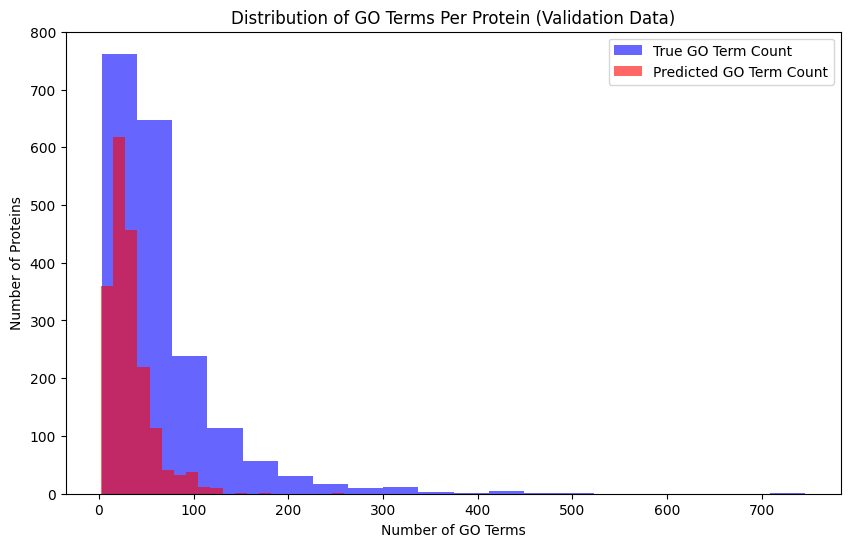

In [32]:
# Select the model and validation data loader you want to use
model_name = 'esm2_only'  # Replace with the model you want to evaluate
model = models[model_name]
valid_loader = valid_loaders[model_name]

# Ensure that the model is in evaluation mode
model.eval()

# Ensure the model and data are on the same device (GPU if available)
device = next(model.parameters()).device

# Collect all true labels and predicted outputs
all_labels = []
all_outputs = []

# Populate all_labels and all_outputs during evaluation on the validation set
with torch.no_grad():
    for batch in valid_loader:
        # Check if the dataset returns separate inputs
        if isinstance(valid_loader.dataset, ProteinDatasetSeparate):
            inputs_embedding, inputs_interpros, labels = batch
            inputs_embedding, inputs_interpros, labels = inputs_embedding.to(device), inputs_interpros.to(device), labels.to(device)
            # Forward pass to get the outputs
            outputs = model(inputs_embedding, inputs_interpros)
        else:
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)
            # Forward pass to get the outputs
            outputs = model(inputs)
        
        # Append the labels and outputs to the lists
        all_labels.append(labels)
        all_outputs.append(outputs)

# Convert the list of tensors into numpy arrays for further analysis
all_labels = torch.cat(all_labels).cpu().numpy()
all_outputs = torch.cat(all_outputs).cpu().numpy()

# Binarize outputs using a threshold (e.g., 0.5)
predicted_labels = (all_outputs >= 0.5).astype(int)

# Visualization: Distribution of the number of GO terms per protein
def plot_go_term_distribution(y_true, y_pred, title):
    true_counts = [sum(labels) for labels in y_true]  # Sum along the row to get counts of GO terms per protein
    pred_counts = [sum(labels) for labels in y_pred]  # Same for predicted labels

    plt.figure(figsize=(10, 6))
    plt.hist(true_counts, bins=20, alpha=0.6, label='True GO Term Count', color='b')
    plt.hist(pred_counts, bins=20, alpha=0.6, label='Predicted GO Term Count', color='r')
    plt.title(title)
    plt.xlabel('Number of GO Terms')
    plt.ylabel('Number of Proteins')
    plt.legend()
    plt.show()

# Call the function with true and predicted labels from the validation data
plot_go_term_distribution(all_labels, predicted_labels, 'Distribution of GO Terms Per Protein (Validation Data)')


# ROC 

In [16]:
# Select the model and validation data loader you want to use
model_name = 'esm2_only'  # Replace with the model you want to evaluate
model = models[model_name]
valid_loader = valid_loaders[model_name]

# Ensure that the model is in evaluation mode
model.eval()

# Ensure the model and data are on the same device (GPU if available)
device = next(model.parameters()).device

# Collect all true labels and predicted outputs
all_labels = []
all_outputs = []

# Populate all_labels and all_outputs during evaluation on the validation set
with torch.no_grad():
    for batch in valid_loader:
        # Check if the dataset returns separate inputs
        if isinstance(valid_loader.dataset, ProteinDatasetSeparate):
            inputs_embedding, inputs_interpros, labels = batch
            inputs_embedding, inputs_interpros, labels = inputs_embedding.to(device), inputs_interpros.to(device), labels.to(device)
            # Forward pass to get the outputs
            outputs = model(inputs_embedding, inputs_interpros)
        else:
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)
            # Forward pass to get the outputs
            outputs = model(inputs)
        
        # Append the labels and outputs to the lists
        all_labels.append(labels)
        all_outputs.append(outputs)

# Convert the list of tensors into numpy arrays for further analysis
all_labels = torch.cat(all_labels).cpu().numpy()
all_outputs = torch.cat(all_outputs).cpu().numpy()


## Identify the 5 Most Common and 5 Rarest Labels

In [40]:
# Get indices of labels with both positive and negative samples
valid_label_indices = [i for i in positive_label_indices if np.unique(all_labels[:, i]).size > 1]

# Sort labels by counts
valid_label_counts = label_counts[valid_label_indices]
sorted_indices_by_count = np.array(valid_label_indices)[np.argsort(valid_label_counts)]

# Get indices of 5 rarest labels with positive samples
rarest_indices = sorted_indices_by_count[:5]

# Get indices of 5 most common labels with positive and negative samples
most_common_indices = sorted_indices_by_count[-5:]

# Reverse the order of most common indices to have the most common first
most_common_indices = most_common_indices[::-1]


## ROC Curves for the Selected Labels

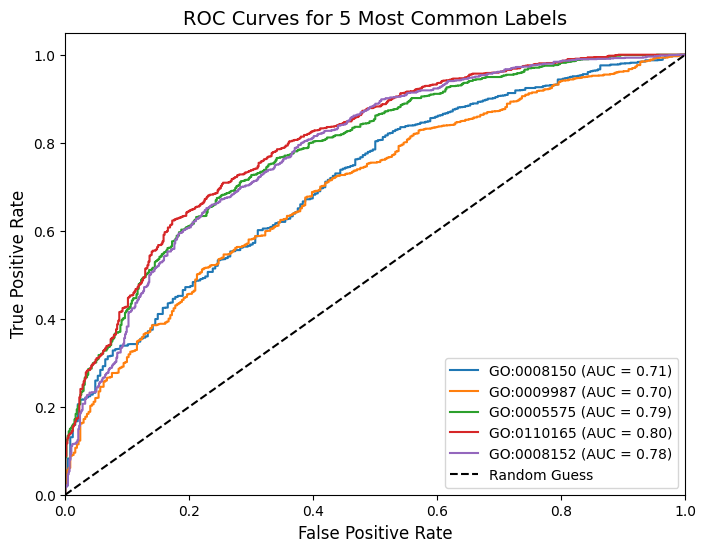

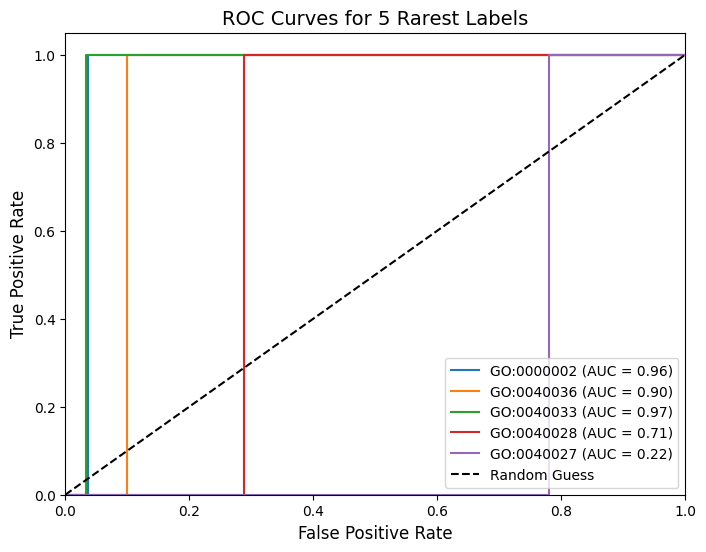

In [41]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def plot_roc_curves(label_indices, title):
    plt.figure(figsize=(8, 6))
    for idx in label_indices:
        # True labels and predicted scores for the current label
        y_true = all_labels[:, idx]
        y_scores = all_outputs[:, idx]
        
        # Check if the label has both positive and negative samples
        if np.unique(y_true).size > 1:
            # Compute ROC curve and AUC
            fpr, tpr, _ = roc_curve(y_true, y_scores)
            roc_auc = auc(fpr, tpr)
            
            # Get the GO term name
            label_name = mlb.classes_[idx]
            
            # Plot the ROC curve
            plt.plot(fpr, tpr, label=f'{label_name} (AUC = {roc_auc:.2f})')
        else:
            # Handle the case where ROC AUC is undefined
            label_name = mlb.classes_[idx]
            print(f"Label {label_name} has only one class present in y_true. Skipping ROC curve.")
    
    # Plot the random guess line
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(title, fontsize=14)
    plt.legend(loc='lower right')
    plt.show()


# Plot ROC curves for the 5 most common labels
plot_roc_curves(most_common_indices, 'ROC Curves for 5 Most Common Labels')

# Plot ROC curves for the 5 rarest labels
plot_roc_curves(rarest_indices, 'ROC Curves for 5 Rarest Labels')


In [39]:
# Get the index of GO:0003674
go_term = 'GO:0003674'
label_index = np.where(mlb.classes_ == go_term)[0][0]

# Check the unique values in y_true for this label
y_true = all_labels[:, label_index]
print(f"Unique values in y_true for {go_term}: {np.unique(y_true)}")


Unique values in y_true for GO:0003674: [1.]


# Plotting Precision-Recall Curves for the Selected Labels (Optional)

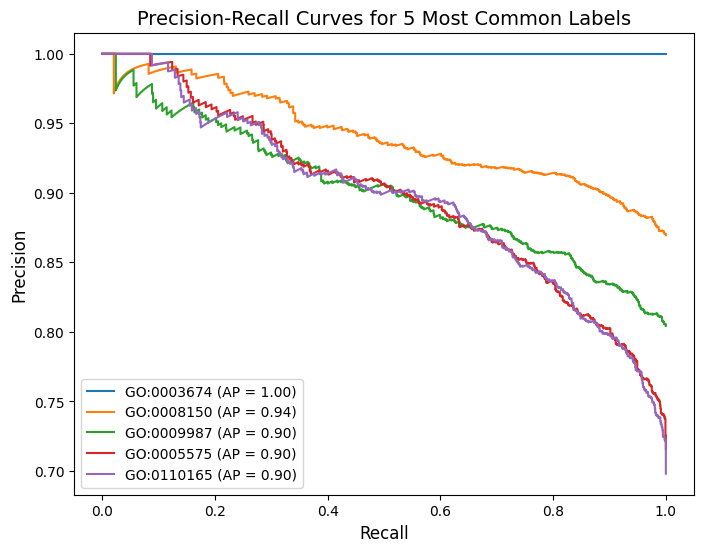

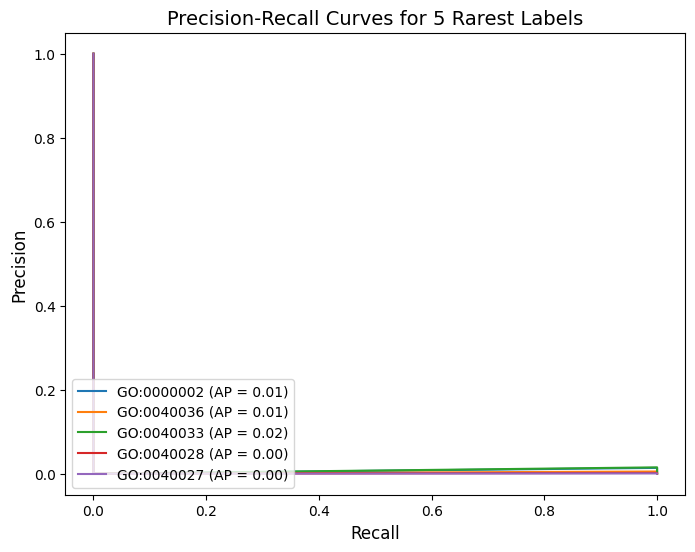

In [19]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Function to plot Precision-Recall curves for given label indices
def plot_precision_recall_curves(label_indices, title):
    plt.figure(figsize=(8, 6))
    for idx in label_indices:
        y_true = all_labels[:, idx]
        y_scores = all_outputs[:, idx]
        
        # Compute Precision-Recall curve and Average Precision
        precision, recall, _ = precision_recall_curve(y_true, y_scores)
        average_precision = average_precision_score(y_true, y_scores)
        
        # Get the GO term name
        label_name = mlb.classes_[idx]
        
        # Plot the Precision-Recall curve
        plt.plot(recall, precision, label=f'{label_name} (AP = {average_precision:.2f})')
    
    plt.xlabel('Recall', fontsize=12)
    plt.ylabel('Precision', fontsize=12)
    plt.title(title, fontsize=14)
    plt.legend(loc='lower left')
    plt.show()

# Plot Precision-Recall curves for the 5 most common labels
plot_precision_recall_curves(most_common_indices, 'Precision-Recall Curves for 5 Most Common Labels')

# Plot Precision-Recall curves for the 5 rarest labels
plot_precision_recall_curves(rarest_indices, 'Precision-Recall Curves for 5 Rarest Labels')


# hamming loss over time

In [20]:
def evaluate_hamming_loss(loader, model):
    model.eval()  # Set the model to evaluation mode
    all_labels = []
    all_outputs = []

    # Ensure the model is on the same device as the inputs
    device = next(model.parameters()).device

    with torch.no_grad():
        for batch in loader:
            if isinstance(loader.dataset, ProteinDatasetSeparate):
                inputs_embedding, inputs_interpros, labels = batch
                inputs_embedding, inputs_interpros, labels = inputs_embedding.to(device), inputs_interpros.to(device), labels.to(device)
                outputs = model(inputs_embedding, inputs_interpros)
            else:
                inputs, labels = batch
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)

            all_labels.append(labels)
            all_outputs.append(outputs)

    # Concatenate the outputs and labels
    all_labels = torch.cat(all_labels).cpu().numpy()
    all_outputs = torch.cat(all_outputs).cpu().numpy()

    # Binarize outputs using a threshold (e.g., 0.5)
    predicted_labels = (all_outputs > 0.5).astype(int)

    # Compute Hamming Loss
    hamming = hamming_loss(all_labels, predicted_labels)

    return hamming


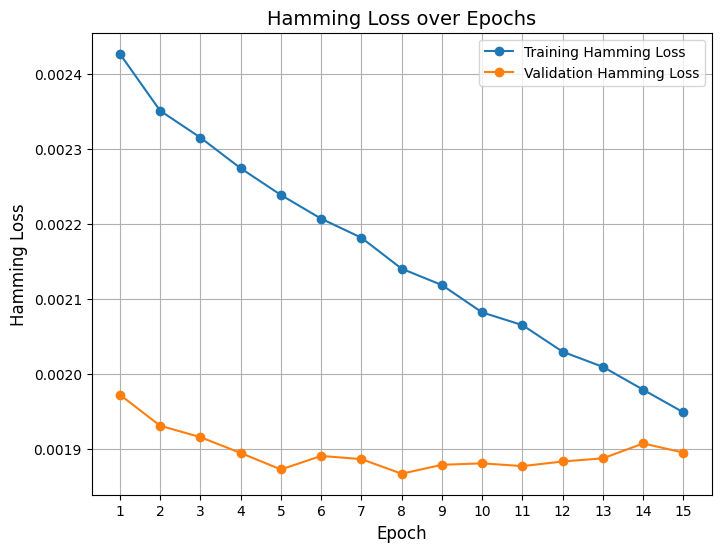

In [22]:
import matplotlib.pyplot as plt

# Function to plot Hamming Loss over epochs for a given model
def plot_hamming_loss(model_name, hamming_history):
    epochs = range(1, num_epochs + 1)
    train_losses = hamming_history['train']
    valid_losses = hamming_history['valid']

    plt.figure(figsize=(8, 6))
    plt.plot(epochs, train_losses, 'o-', label='Training Hamming Loss')
    plt.plot(epochs, valid_losses, 'o-', label='Validation Hamming Loss')
    # plt.title(f'Hamming Loss over Epochs for {model_name}', fontsize=14)
    plt.title(f'Hamming Loss over Epochs', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Hamming Loss', fontsize=12)
    plt.xticks(epochs)
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot Hamming Loss for each model
for model_name in models:
    plot_hamming_loss(model_name, hamming_loss_history[model_name])


# Label Co-occurrence Heatmap

ValueError: Unknown format code 'd' for object of type 'float'

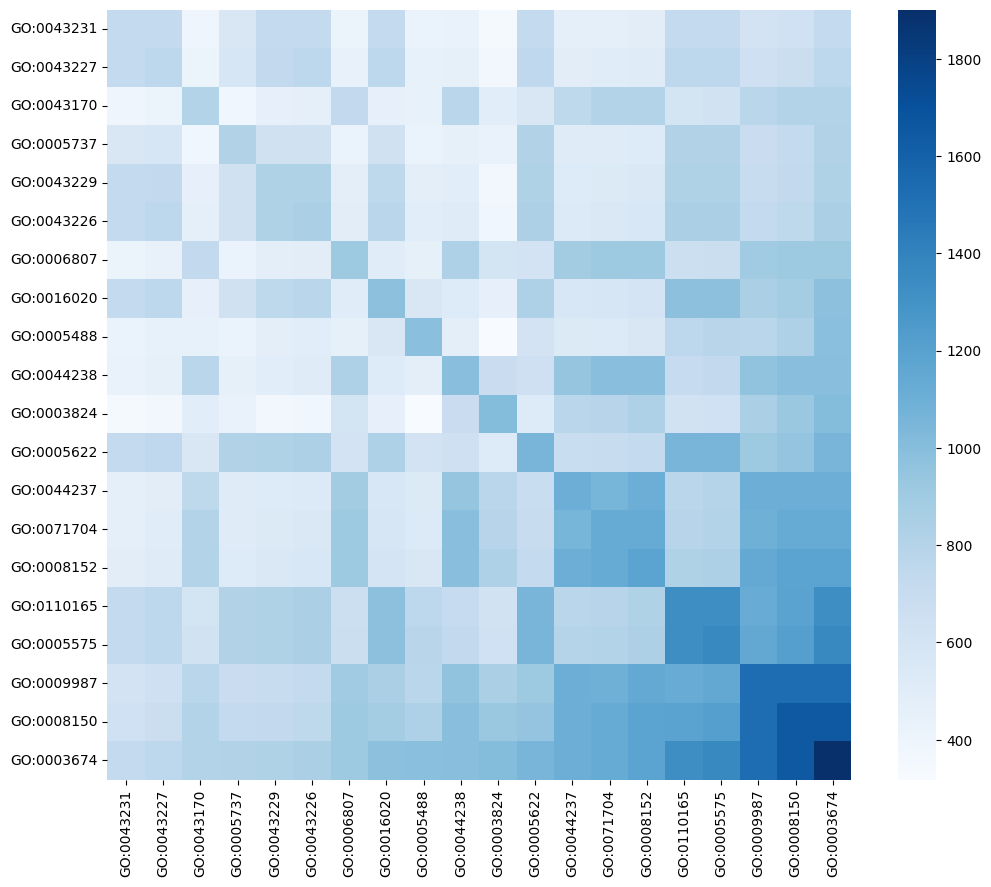

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the co-occurrence matrix
co_occurrence = np.dot(all_labels.T, all_labels)

# Convert to DataFrame for better labeling
co_occurrence_df = pd.DataFrame(co_occurrence, index=mlb.classes_, columns=mlb.classes_)

# Select top N labels to display for readability
top_n = 20
label_counts = np.sum(all_labels, axis=0)
top_indices = np.argsort(label_counts)[-top_n:]
top_labels = [mlb.classes_[i] for i in top_indices]

# Subset the co-occurrence matrix
subset_df = co_occurrence_df.loc[top_labels, top_labels]

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(subset_df, annot=True, fmt='d', cmap='Blues')
plt.title('Label Co-occurrence Heatmap for Top 20 Labels', fontsize=14)
plt.xlabel('GO Terms', fontsize=12)
plt.ylabel('GO Terms', fontsize=12)
plt.show()


t-SNE or PCA Visualization of Embeddings

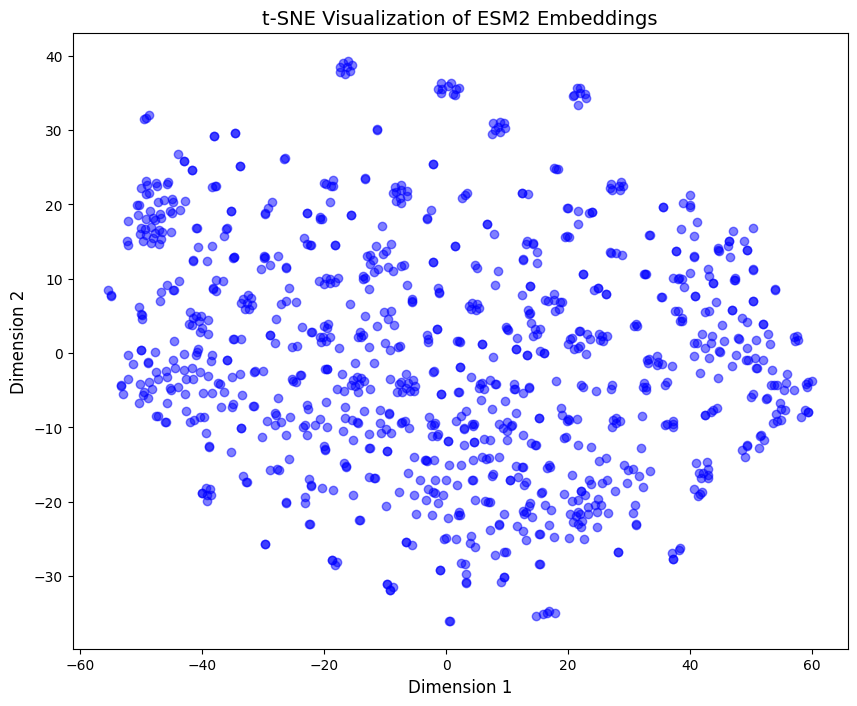

In [25]:
from sklearn.manifold import TSNE

# Select a subset of data for visualization to reduce computation time
num_samples = 1000
X_subset = X_valid_esm2[:num_samples]
y_subset = all_labels[:num_samples]

# Perform t-SNE dimensionality reduction
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_subset)

# Plot the t-SNE results
plt.figure(figsize=(10, 8))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c='blue', alpha=0.5)
plt.title('t-SNE Visualization of ESM2 Embeddings', fontsize=14)
plt.xlabel('Dimension 1', fontsize=12)
plt.ylabel('Dimension 2', fontsize=12)
plt.show()


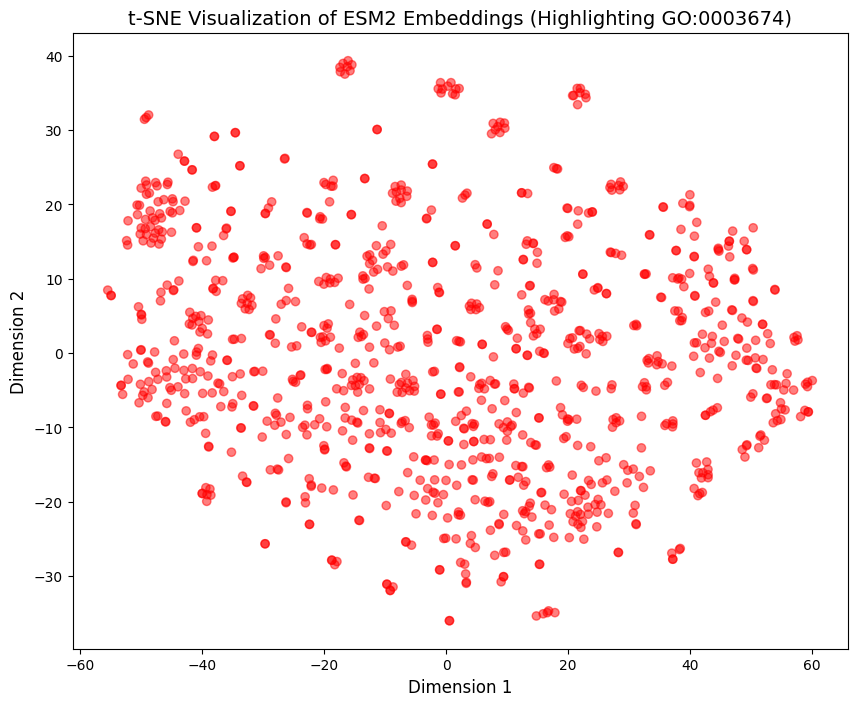

In [26]:
# Select a GO term index to highlight
go_term_index = most_common_indices[0]  # For example, the most common label
go_term_name = mlb.classes_[go_term_index]

# Create a color map based on the presence of the selected GO term
colors = ['red' if label[go_term_index] == 1 else 'blue' for label in y_subset]

# Plot the t-SNE results with colors
plt.figure(figsize=(10, 8))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=colors, alpha=0.5)
plt.title(f't-SNE Visualization of ESM2 Embeddings (Highlighting {go_term_name})', fontsize=14)
plt.xlabel('Dimension 1', fontsize=12)
plt.ylabel('Dimension 2', fontsize=12)
plt.show()


Calibration Curves

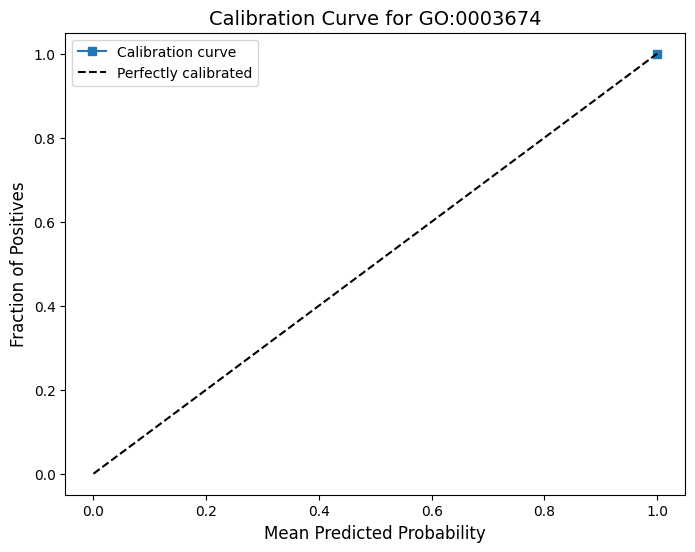

In [27]:
from sklearn.calibration import calibration_curve

# Function to plot calibration curves for a given label index
def plot_calibration_curve(label_index, label_name):
    y_true = all_labels[:, label_index]
    y_prob = all_outputs[:, label_index]
    
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=10)
    
    plt.figure(figsize=(8, 6))
    plt.plot(prob_pred, prob_true, 's-', label='Calibration curve')
    plt.plot([0, 1], [0, 1], 'k--', label='Perfectly calibrated')
    plt.title(f'Calibration Curve for {label_name}', fontsize=14)
    plt.xlabel('Mean Predicted Probability', fontsize=12)
    plt.ylabel('Fraction of Positives', fontsize=12)
    plt.legend()
    plt.show()

# Plot calibration curve for a specific GO term
label_index = most_common_indices[0]  # Replace with desired label index
label_name = mlb.classes_[label_index]
plot_calibration_curve(label_index, label_name)


Threshold Analysis

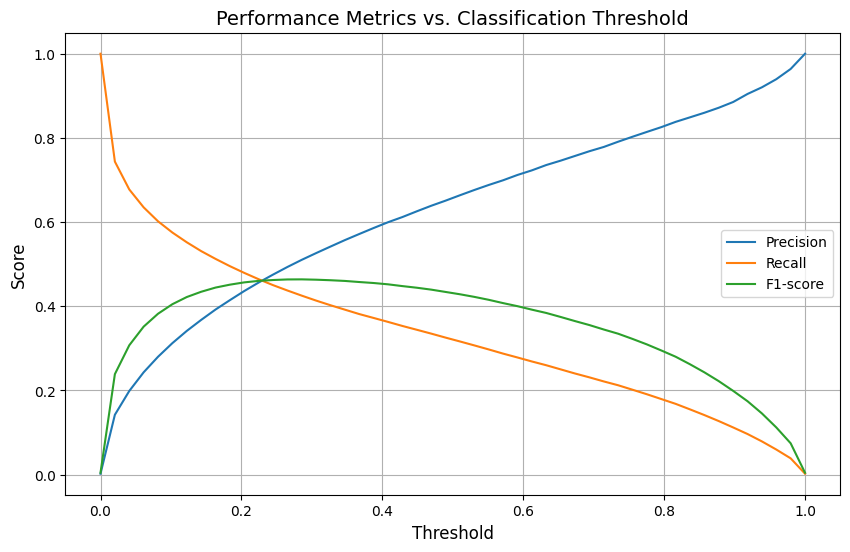

In [28]:
from sklearn.metrics import precision_recall_fscore_support

# Define a range of thresholds
thresholds = np.linspace(0, 1, 50)
precision_list = []
recall_list = []
f1_list = []

for thresh in thresholds:
    predicted_labels = (all_outputs >= thresh).astype(int)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, predicted_labels, average='micro', zero_division=0)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)

# Plot Precision, Recall, and F1-score vs. Threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision_list, label='Precision')
plt.plot(thresholds, recall_list, label='Recall')
plt.plot(thresholds, f1_list, label='F1-score')
plt.title('Performance Metrics vs. Classification Threshold', fontsize=14)
plt.xlabel('Threshold', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()


Per-Label Performance Metrics

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

# Binarize outputs using the default threshold of 0.5
predicted_labels = (all_outputs >= 0.5).astype(int)

# Compute per-label metrics
precision_per_label, recall_per_label, f1_per_label, support = precision_recall_fscore_support(
    all_labels, predicted_labels, average=None, zero_division=0
)

# Create a DataFrame for better visualization
metrics_df = pd.DataFrame({
    'GO Term': mlb.classes_,
    'Precision': precision_per_label,
    'Recall': recall_per_label,
    'F1-score': f1_per_label,
    'Support': support
})

# Sort by F1-score
metrics_df = metrics_df.sort_values(by='F1-score', ascending=False)

# Display the top and bottom GO terms by F1-score
print("Top 10 GO terms by F1-score:")
display(metrics_df.head(10))

print("\nBottom 10 GO terms by F1-score:")
display(metrics_df.tail(10))


Confusion Matrices for Individual Labels

In [ ]:
from sklearn.metrics import confusion_matrix

# Function to plot confusion matrix for a given label
def plot_confusion_matrix_for_label(label_index, label_name):
    y_true = all_labels[:, label_index]
    y_pred = (all_outputs[:, label_index] >= 0.5).astype(int)
    cm = confusion_matrix(y_true, y_pred)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {label_name}', fontsize=14)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.show()

# Plot confusion matrix for a specific GO term
label_index = most_common_indices[0]  # Replace with desired label index
label_name = mlb.classes_[label_index]
plot_confusion_matrix_for_label(label_index, label_name)


Error Analysis: Distribution of False Positives and False Negatives

In [29]:
# Identify false positives and false negatives for a specific label
label_index = most_common_indices[0]  # Replace with desired label index
label_name = mlb.classes_[label_index]

y_true = all_labels[:, label_index]
y_pred = (all_outputs[:, label_index] >= 0.5).astype(int)

false_positives = np.where((y_true == 0) & (y_pred == 1))[0]
false_negatives = np.where((y_true == 1) & (y_pred == 0))[0]

print(f"Number of False Positives for {label_name}: {len(false_positives)}")
print(f"Number of False Negatives for {label_name}: {len(false_negatives)}")

# Further analysis can be done by inspecting the samples in false_positives and false_negatives


Number of False Positives for GO:0003674: 0
Number of False Negatives for GO:0003674: 0


Correlation Between Label Frequencies and Model Performance

In [ ]:
# Compute per-label F1-score as before
precision_per_label, recall_per_label, f1_per_label, support = precision_recall_fscore_support(
    all_labels, predicted_labels, average=None, zero_division=0
)

# Create a DataFrame
metrics_df = pd.DataFrame({
    'GO Term': mlb.classes_,
    'F1-score': f1_per_label,
    'Support': support
})

# Plot F1-score vs. Support
plt.figure(figsize=(8, 6))
plt.scatter(metrics_df['Support'], metrics_df['F1-score'], alpha=0.7)
plt.title('F1-score vs. Label Support', fontsize=14)
plt.xlabel('Number of Positive Samples (Support)', fontsize=12)
plt.ylabel('F1-score', fontsize=12)
plt.grid(True)
plt.show()


Histogram of Predicted Probabilities

In [ ]:
# Flatten the predicted probabilities
predicted_probs = all_outputs.ravel()

plt.figure(figsize=(8, 6))
plt.hist(predicted_probs, bins=50, alpha=0.75)
plt.title('Histogram of Predicted Probabilities', fontsize=14)
plt.xlabel('Predicted Probability', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True)
plt.show()


Comparison of Embedding Types

In [ ]:
# Prepare data for plotting
embedding_types = ['ESM2', 'ProtBert', 'ProtT5', 'TAPE']
processing_types = ['Embedding Only', 'Concatenated', 'Separate Processing']
metrics_to_plot = ['ROC AUC', 'Average Precision', 'F1-score']

for metric in metrics_to_plot:
    plt.figure(figsize=(10, 6))
    for processing in processing_types:
        values = []
        for embedding in embedding_types:
            model_name = f"{embedding.lower()}_{processing.lower().replace(' ', '')}"
            value = evaluation_metrics[model_name][metric]
            values.append(value)
        plt.plot(embedding_types, values, marker='o', label=processing)
    plt.title(f'{metric} Across Embeddings and Processing Methods', fontsize=14)
    plt.xlabel('Embedding Type', fontsize=12)
    plt.ylabel(metric, fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.show()


Learning Curves

In [ ]:
from sklearn.model_selection import learning_curve

# Note: This requires adapting your model to work with scikit-learn's API or wrapping it accordingly.
# Alternatively, you can manually split your data and train the model multiple times.

# Placeholder code structure
train_sizes = [0.1, 0.3, 0.5, 0.7, 1.0]
train_scores = []
valid_scores = []

for train_size in train_sizes:
    # Split the data accordingly
    num_train_samples = int(train_size * len(train_dataset_embed))
    subset_indices = np.random.choice(len(train_dataset_embed), num_train_samples, replace=False)
    subset_sampler = torch.utils.data.SubsetRandomSampler(subset_indices)
    subset_loader = DataLoader(train_dataset_embed, batch_size=32, sampler=subset_sampler)
    
    # Train the model on the subset
    # [Your training code here]
    
    # Evaluate the model on validation data
    metrics = evaluate_model(valid_loader, model)
    valid_scores.append(metrics['F1-score'])
    
    # Optionally, compute training score
    metrics_train = evaluate_model(subset_loader, model)
    train_scores.append(metrics_train['F1-score'])

# Plot learning curve
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_scores, 'o-', label='Training F1-score')
plt.plot(train_sizes, valid_scores, 'o-', label='Validation F1-score')
plt.title('Learning Curve', fontsize=14)
plt.xlabel('Fraction of Training Data Used', fontsize=12)
plt.ylabel('F1-score', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()


## Simple Attention

In [11]:
# --- Import Necessary Libraries ---
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import pandas as pd
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, accuracy_score, hamming_loss
from deepgo.utils import Ontology
from deepgo.data import load_normal_forms
import warnings
warnings.filterwarnings("ignore")

# --- Configuration and Paths ---
data_root = 'data'  # Path to the data directory
ontology = 'mf'     # Options are: 'mf' (Molecular Function), 'bp' (Biological Process), 'cc' (Cellular Component)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

go_file = f'{data_root}/go.obo'
go_norm_file = f'{data_root}/go.norm'  # Adjust the path if different

# Define data file paths
train_data_file = f'{data_root}/{ontology}/train_data_with_embeddings.pkl'
valid_data_file = f'{data_root}/{ontology}/valid_data_with_embeddings.pkl'
test_data_file = f'{data_root}/{ontology}/test_data_with_embeddings.pkl'

# --- Data Preparation ---

# Load DataFrames with Embeddings
train_data = pd.read_pickle(train_data_file)
valid_data = pd.read_pickle(valid_data_file)
test_data = pd.read_pickle(test_data_file)

print("DataFrames with embeddings loaded successfully.")
print("Available columns in train_data:", train_data.columns.tolist())

# Function to convert numpy arrays to torch tensors
def to_tensor(x):
    return torch.tensor(x, dtype=torch.float32)

# ESM2 Embeddings
X_train_esm2 = np.stack(train_data['esm2'].values)
X_valid_esm2 = np.stack(valid_data['esm2'].values)
X_test_esm2 = np.stack(test_data['esm2'].values)

# ProtBert Embeddings
X_train_protbert = np.stack(train_data['protbert'].values)
X_valid_protbert = np.stack(valid_data['protbert'].values)
X_test_protbert = np.stack(test_data['protbert'].values)

# ProtT5 Embeddings
X_train_prott5 = np.stack(train_data['prott5'].values)
X_valid_prott5 = np.stack(valid_data['prott5'].values)
X_test_prott5 = np.stack(test_data['prott5'].values)

# TAPE Embeddings
X_train_tape = np.stack(train_data['tape'].values)
X_valid_tape = np.stack(valid_data['tape'].values)
X_test_tape = np.stack(test_data['tape'].values)

# Multi-hot encode the InterPro annotations
mlb_interpros = MultiLabelBinarizer()
interpros_train = mlb_interpros.fit_transform(train_data['interpros'].values)
interpros_valid = mlb_interpros.transform(valid_data['interpros'].values)
interpros_test = mlb_interpros.transform(test_data['interpros'].values)

# Convert labels to torch tensors
mlb = MultiLabelBinarizer()
y_train = mlb.fit_transform(train_data['prop_annotations'].values)
y_valid = mlb.transform(valid_data['prop_annotations'].values)
y_test = mlb.transform(test_data['prop_annotations'].values)

y_train = torch.tensor(y_train, dtype=torch.float32)
y_valid = torch.tensor(y_valid, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# --- Load GO Axioms (Normal Forms) and Align Indices ---

# Create terms_dict from label classes
term_list = mlb.classes_
terms_dict = {term: idx for idx, term in enumerate(term_list)}

# Load GO Ontology
go = Ontology(go_file, with_rels=True)

# Load GO Normal Forms (Axioms)
nf1_data, nf2_data, nf3_data, nf4_data, relations, zero_classes = load_normal_forms(go_norm_file, terms_dict)

# Functions to convert normal forms to tensors
def convert_nf1_to_tensor(nf, terms_dict):
    nf_tensor = []
    for a, b in nf:
        if a in terms_dict and b in terms_dict:
            nf_tensor.append([terms_dict[a], terms_dict[b]])
    return torch.LongTensor(nf_tensor)

def convert_nf2_to_tensor(nf, terms_dict):
    nf_list = []
    for items in nf:
        indices = [terms_dict[a] for a in items if a in terms_dict]
        if len(indices) >= 2:
            nf_list.append(indices)
    return nf_list  # Return as list of lists

def convert_nf3_to_tensor(nf, terms_dict):
    nf_tensor = []
    for a, b, c in nf:
        if a in terms_dict and b in terms_dict and c in terms_dict:
            nf_tensor.append([terms_dict[a], terms_dict[b], terms_dict[c]])
    return torch.LongTensor(nf_tensor)

def convert_nf4_to_tensor(nf, terms_dict):
    nf_tensor = []
    for a, b, c in nf:
        if a in terms_dict and b in terms_dict and c in terms_dict:
            nf_tensor.append([terms_dict[a], terms_dict[b], terms_dict[c]])
    return torch.LongTensor(nf_tensor)

# Convert normal forms to tensors and move to device
nf1 = convert_nf1_to_tensor(nf1_data, terms_dict).to(device)
nf2 = convert_nf2_to_tensor(nf2_data, terms_dict)  # Handled separately
nf3 = convert_nf3_to_tensor(nf3_data, terms_dict).to(device)
nf4 = convert_nf4_to_tensor(nf4_data, terms_dict).to(device)
normal_forms = (nf1, nf2, nf3, nf4)

# --- Prepare DataLoaders for Each Embedding Type and Model Variant ---

# Dataset for models that take a single input (embedding-only or concatenated features)
class ProteinDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Dataset for models that take separate inputs (embedding and interpros separately)
class ProteinDatasetSeparate(Dataset):
    def __init__(self, X_embedding, X_interpros, y):
        self.X_embedding = X_embedding
        self.X_interpros = X_interpros
        self.y = y
    
    def __len__(self):
        return len(self.X_embedding)
    
    def __getitem__(self, idx):
        return self.X_embedding[idx], self.X_interpros[idx], self.y[idx]

# Dictionary to store DataLoaders
train_loaders = {}
valid_loaders = {}
test_loaders = {}

embedding_types = ['esm2', 'protbert', 'prott5', 'tape'] # , 'protbert', 'prott5', 'tape'
for embedding in embedding_types:
    # Get the variables dynamically
    X_train_embed = globals()[f'X_train_{embedding}']
    X_valid_embed = globals()[f'X_valid_{embedding}']
    X_test_embed = globals()[f'X_test_{embedding}']
    
    X_train_embed = to_tensor(X_train_embed)
    X_valid_embed = to_tensor(X_valid_embed)
    X_test_embed = to_tensor(X_test_embed)
    
    # Combined features (embedding + InterPros)
    X_train_combined = torch.cat([X_train_embed, to_tensor(interpros_train)], dim=1)
    X_valid_combined = torch.cat([X_valid_embed, to_tensor(interpros_valid)], dim=1)
    X_test_combined = torch.cat([X_test_embed, to_tensor(interpros_test)], dim=1)
    
    # Embedding-only DataLoaders
    train_dataset_embed = ProteinDataset(X_train_embed, y_train)
    valid_dataset_embed = ProteinDataset(X_valid_embed, y_valid)
    test_dataset_embed = ProteinDataset(X_test_embed, y_test)
    
    train_loaders[f'{embedding}_only'] = DataLoader(train_dataset_embed, batch_size=32, shuffle=True)
    valid_loaders[f'{embedding}_only'] = DataLoader(valid_dataset_embed, batch_size=32, shuffle=False)
    test_loaders[f'{embedding}_only'] = DataLoader(test_dataset_embed, batch_size=32, shuffle=False)
    
    # Concatenated DataLoaders
    train_dataset_concat = ProteinDataset(X_train_combined, y_train)
    valid_dataset_concat = ProteinDataset(X_valid_combined, y_valid)
    test_dataset_concat = ProteinDataset(X_test_combined, y_test)
    
    train_loaders[f'{embedding}_concat'] = DataLoader(train_dataset_concat, batch_size=32, shuffle=True)
    valid_loaders[f'{embedding}_concat'] = DataLoader(valid_dataset_concat, batch_size=32, shuffle=False)
    test_loaders[f'{embedding}_concat'] = DataLoader(test_dataset_concat, batch_size=32, shuffle=False)
    
    # Separate Processing DataLoaders
    interpros_train_tensor = to_tensor(interpros_train)
    interpros_valid_tensor = to_tensor(interpros_valid)
    interpros_test_tensor = to_tensor(interpros_test)
    
    train_dataset_separate = ProteinDatasetSeparate(X_train_embed, interpros_train_tensor, y_train)
    valid_dataset_separate = ProteinDatasetSeparate(X_valid_embed, interpros_valid_tensor, y_valid)
    test_dataset_separate = ProteinDatasetSeparate(X_test_embed, interpros_test_tensor, y_test)
    
    train_loaders[f'{embedding}_separate'] = DataLoader(train_dataset_separate, batch_size=32, shuffle=True)
    valid_loaders[f'{embedding}_separate'] = DataLoader(valid_dataset_separate, batch_size=32, shuffle=False)
    test_loaders[f'{embedding}_separate'] = DataLoader(test_dataset_separate, batch_size=32, shuffle=False)

# --- Define Base Model Class with Logical Loss ---

class BaseProteinGOModel(nn.Module):
    def el_loss(self, outputs, normal_forms):
        nf1, nf2, nf3, nf4 = normal_forms
        loss = 0.0

        # NF1: A implies B
        if nf1.size(0) > 0:
            A_indices = nf1[:, 0].long().to(outputs.device)
            B_indices = nf1[:, 1].long().to(outputs.device)
            max_index = outputs.size(1) - 1
            if A_indices.max() > max_index or B_indices.max() > max_index:
                print("Skipping NF1 due to out-of-bounds indices.")
            else:
                P_A = outputs[:, A_indices]
                P_B = outputs[:, B_indices]
                nf1_loss = torch.clamp(P_A - P_B, min=0)
                loss += nf1_loss.mean()

        # NF2: Disjointness constraints
        if len(nf2) > 0:
            for indices in nf2:
                indices = torch.tensor(indices).long().to(outputs.device)
                if indices.max() > outputs.size(1) - 1:
                    print("Skipping a set in NF2 due to out-of-bounds indices.")
                    continue  # Skip invalid indices
                P_terms = outputs[:, indices]
                sum_P = P_terms.sum(dim=1)
                nf2_loss = torch.clamp(sum_P - 1, min=0)
                loss += nf2_loss.mean()

        # NF3 and NF4: A and B implies C
        for nf in [nf3, nf4]:
            if nf.size(0) > 0:
                A_indices = nf[:, 0].long().to(outputs.device)
                B_indices = nf[:, 1].long().to(outputs.device)
                C_indices = nf[:, 2].long().to(outputs.device)
                max_index = outputs.size(1) - 1
                if (
                    A_indices.max() > max_index or
                    B_indices.max() > max_index or
                    C_indices.max() > max_index
                ):
                    print(f"Skipping a set in {nf} due to out-of-bounds indices.")
                    continue  # Skip invalid indices
                P_A = outputs[:, A_indices]
                P_B = outputs[:, B_indices]
                P_C = outputs[:, C_indices]
                min_P_AB = torch.min(P_A, P_B)
                nf_loss = torch.clamp(min_P_AB - P_C, min=0)
                loss += nf_loss.mean()

        return loss

# --- Define Enhanced Model Classes with Residual Connections, Layer Normalization, and Attention ---

# Attention Mechanism (Simple Additive Attention)
class SimpleAttention(nn.Module):
    def __init__(self, feature_dim, attention_dim):
        super(SimpleAttention, self).__init__()
        self.attention_fc = nn.Linear(feature_dim, attention_dim)
        self.context_vector = nn.Linear(attention_dim, 1, bias=False)
    
    def forward(self, x):
        # x: (batch_size, feature_dim)
        scores = torch.tanh(self.attention_fc(x))  # (batch_size, attention_dim)
        scores = self.context_vector(scores)        # (batch_size, 1)
        attention_weights = torch.softmax(scores, dim=1)  # (batch_size, 1)
        attended = attention_weights * x            # (batch_size, feature_dim)
        return attended

# Define the baseline model class with Enhancements
class EnhancedProteinGOClassifier(BaseProteinGOModel):
    def __init__(self, input_size, num_classes, dropout_rate=0.5, attention_dim=256):
        super(EnhancedProteinGOClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 1024)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_rate)
        self.ln1 = nn.LayerNorm(1024)
        self.attention1 = SimpleAttention(1024, attention_dim)
        
        self.fc2 = nn.Linear(1024, 512)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout_rate)
        self.ln2 = nn.LayerNorm(512)
        self.attention2 = SimpleAttention(512, attention_dim)
        
        self.fc3 = nn.Linear(512, num_classes)
        self.sigmoid = nn.Sigmoid()
        
        # Residual connections
        self.residual_fc1 = nn.Linear(input_size, 1024)
        self.residual_fc2 = nn.Linear(1024, 512)
    
    def forward(self, x):
        residual = self.residual_fc1(x)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.ln1(x + residual)  # Residual connection
        x = self.attention1(x)      # Attention
        
        residual = self.residual_fc2(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.ln2(x + residual)  # Residual connection
        x = self.attention2(x)      # Attention
        
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

# Define the concatenation model class with Enhancements
class EnhancedProteinGOClassifierWithConcat(BaseProteinGOModel):
    def __init__(self, input_size_embedding, input_size_interpros, num_classes, dropout_rate=0.5, attention_dim=256):
        super(EnhancedProteinGOClassifierWithConcat, self).__init__()
        self.fc1 = nn.Linear(input_size_embedding + input_size_interpros, 1024)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_rate)
        self.ln1 = nn.LayerNorm(1024)
        self.attention1 = SimpleAttention(1024, attention_dim)
        
        self.fc2 = nn.Linear(1024, 512)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout_rate)
        self.ln2 = nn.LayerNorm(512)
        self.attention2 = SimpleAttention(512, attention_dim)
        
        self.fc3 = nn.Linear(512, num_classes)
        self.sigmoid = nn.Sigmoid()
        
        # Residual connections
        self.residual_fc1 = nn.Linear(input_size_embedding + input_size_interpros, 1024)
        self.residual_fc2 = nn.Linear(1024, 512)
    
    def forward(self, x):
        residual = self.residual_fc1(x)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.ln1(x + residual)  # Residual connection
        x = self.attention1(x)      # Attention
        
        residual = self.residual_fc2(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.ln2(x + residual)  # Residual connection
        x = self.attention2(x)      # Attention
        
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

# Define the separate processing model class with Enhancements
class EnhancedProteinGOClassifierWithSeparate(BaseProteinGOModel):
    def __init__(self, input_size_embedding, input_size_interpros, num_classes, dropout_rate=0.5, attention_dim=256):
        super(EnhancedProteinGOClassifierWithSeparate, self).__init__()
        # Embedding branch
        self.fc1_embedding = nn.Linear(input_size_embedding, 512)
        self.relu1_embedding = nn.ReLU()
        self.dropout1_embedding = nn.Dropout(dropout_rate)
        self.ln1_embedding = nn.LayerNorm(512)
        self.attention1_embedding = SimpleAttention(512, attention_dim)
        self.residual_fc1_embedding = nn.Linear(input_size_embedding, 512)
        
        # InterPro branch
        self.fc1_interpros = nn.Linear(input_size_interpros, 512)
        self.relu1_interpros = nn.ReLU()
        self.dropout1_interpros = nn.Dropout(dropout_rate)
        self.ln1_interpros = nn.LayerNorm(512)
        self.attention1_interpros = SimpleAttention(512, attention_dim)
        self.residual_fc1_interpros = nn.Linear(input_size_interpros, 512)
        
        # Combined layers
        self.fc2 = nn.Linear(512 * 2, 512)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout_rate)
        self.ln2 = nn.LayerNorm(512)
        self.attention2 = SimpleAttention(512, attention_dim)
        self.residual_fc2 = nn.Linear(512 * 2, 512)
        
        self.fc3 = nn.Linear(512, num_classes)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x_embedding, x_interpros):
        # Embedding branch
        residual_embed = self.residual_fc1_embedding(x_embedding)
        x_embed = self.fc1_embedding(x_embedding)
        x_embed = self.relu1_embedding(x_embed)
        x_embed = self.dropout1_embedding(x_embed)
        x_embed = self.ln1_embedding(x_embed + residual_embed)  # Residual connection
        x_embed = self.attention1_embedding(x_embed)            # Attention
        
        # InterPro branch
        residual_interpro = self.residual_fc1_interpros(x_interpros)
        x_interpro = self.fc1_interpros(x_interpros)
        x_interpro = self.relu1_interpros(x_interpro)
        x_interpro = self.dropout1_interpros(x_interpro)
        x_interpro = self.ln1_interpros(x_interpro + residual_interpro)  # Residual connection
        x_interpro = self.attention1_interpros(x_interpro)                # Attention
        
        # Concatenate embeddings and interpros
        x = torch.cat([x_embed, x_interpro], dim=1)
        residual = self.residual_fc2(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.ln2(x + residual)  # Residual connection
        x = self.attention2(x)      # Attention
        
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

# --- Model Initialization and Optimizers ---

num_classes = y_train.shape[1]
input_size_interpros = interpros_train.shape[1]

models = {}
optimizers_dict = {}

for embedding in embedding_types:
    # Get input sizes
    input_size_embedding = globals()[f'X_train_{embedding}'].shape[1]
    
    # Embedding-only model with Enhancements
    model_only = EnhancedProteinGOClassifier(input_size_embedding, num_classes, dropout_rate=0.5, attention_dim=256)
    optimizer_only = optim.Adam(model_only.parameters(), lr=0.005)
    models[f'{embedding}_only'] = model_only
    optimizers_dict[f'{embedding}_only'] = optimizer_only
    
    # Concatenated model with Enhancements
    model_concat = EnhancedProteinGOClassifierWithConcat(input_size_embedding, input_size_interpros, num_classes, dropout_rate=0.5, attention_dim=256)
    optimizer_concat = optim.Adam(model_concat.parameters(), lr=0.005)
    models[f'{embedding}_concat'] = model_concat
    optimizers_dict[f'{embedding}_concat'] = optimizer_concat
    
    # Separate processing model with Enhancements
    model_separate = EnhancedProteinGOClassifierWithSeparate(input_size_embedding, input_size_interpros, num_classes, dropout_rate=0.5, attention_dim=256)
    optimizer_separate = optim.Adam(model_separate.parameters(), lr=0.005)
    models[f'{embedding}_separate'] = model_separate
    optimizers_dict[f'{embedding}_separate'] = optimizer_separate

# --- Move Models to Device ---
for model in models.values():
    model.to(device)

# --- Define the Loss Function ---
criterion = nn.BCELoss()

# --- Training Loop ---

def train_model(model, train_loader, optimizer, criterion, model_name, normal_forms, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0

        # Wrap the DataLoader with tqdm for a progress bar
        with tqdm(train_loader, desc=f"{model_name} - Epoch {epoch+1}/{num_epochs}", unit="batch") as tepoch:
            for batch in tepoch:
                optimizer.zero_grad()  # Zero the gradients

                if isinstance(train_loader.dataset, ProteinDatasetSeparate):
                    inputs_embedding, inputs_interpros, labels = batch
                    inputs_embedding, inputs_interpros, labels = inputs_embedding.to(device), inputs_interpros.to(device), labels.to(device)
                    outputs = model(inputs_embedding, inputs_interpros)
                else:
                    inputs, labels = batch
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)

                # Compute primary loss
                primary_loss = criterion(outputs, labels)
                # Compute logical loss
                logical_loss = model.el_loss(outputs, normal_forms)
                # Combine losses
                total_loss = primary_loss + logical_loss
                # Backpropagate and update parameters
                total_loss.backward()
                optimizer.step()

                running_loss += total_loss.item()
                tepoch.set_postfix(loss=running_loss / (tepoch.n or 1))

        # Print loss after each epoch
        avg_loss = running_loss / len(train_loader)
        print(f'{model_name} - Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

# --- Evaluation Function ---

def evaluate_model(loader, model):
    model.eval()  # Set the model to evaluation mode
    all_labels = []
    all_outputs = []

    with torch.no_grad():  # Disable gradient calculations during evaluation
        for batch in loader:
            if isinstance(loader.dataset, ProteinDatasetSeparate):
                inputs_embedding, inputs_interpros, labels = batch
                inputs_embedding, inputs_interpros, labels = inputs_embedding.to(device), inputs_interpros.to(device), labels.to(device)
                outputs = model(inputs_embedding, inputs_interpros)
            else:
                inputs, labels = batch
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
            
            all_labels.append(labels.cpu())
            all_outputs.append(outputs.cpu())

    # Concatenate the outputs and labels
    all_labels = torch.cat(all_labels).numpy()
    all_outputs = torch.cat(all_outputs).numpy()

    # Compute evaluation metrics
    try:
        roc_auc = roc_auc_score(all_labels, all_outputs, average='micro')
    except ValueError:
        roc_auc = float('nan')

    predicted_labels = (all_outputs > 0.5).astype(int)

    precision = precision_score(all_labels, predicted_labels, average='micro', zero_division=0)
    recall = recall_score(all_labels, predicted_labels, average='micro', zero_division=0)
    f1 = f1_score(all_labels, predicted_labels, average='micro', zero_division=0)
    subset_acc = accuracy_score(all_labels, predicted_labels)
    hamming = hamming_loss(all_labels, predicted_labels)

    return {
        "ROC AUC": roc_auc,
        "Hamming Loss": hamming,
        "Subset Accuracy": subset_acc,
        "Precision": precision,
        "Recall": recall,
        "F1-score": f1
    }

# --- Train Each Model ---

num_epochs = 15
for model_name in models:
    print(f"\nTraining model: {model_name}")
    model = models[model_name]
    optimizer = optimizers_dict[model_name]
    train_loader = train_loaders[model_name]
    train_model(model, train_loader, optimizer, criterion, model_name, normal_forms=normal_forms, num_epochs=num_epochs)

# --- Evaluation of Each Model and Compilation of Metrics ---

evaluation_metrics = {}

for model_name in models:
    print(f"\nEvaluating model: {model_name}")
    model = models[model_name]
    valid_loader = valid_loaders[model_name]
    metrics = evaluate_model(valid_loader, model)
    evaluation_metrics[model_name] = metrics

# --- Compile Metrics into a Summary Table ---

summary_data = []

for model_name, metrics in evaluation_metrics.items():
    # Parse model_name
    embedding_type, processing = model_name.split('_', 1)
    if processing == 'only':
        processing = 'Embedding Only'
    elif processing == 'concat':
        processing = 'Concatenated'
    elif processing == 'separate':
        processing = 'Separate Processing'
    else:
        processing = processing.capitalize()
    embedding_type = embedding_type.upper()
    
    # Create a dictionary for this model's metrics
    model_metrics = {
        'Embedding': embedding_type,
        'Processing': processing
    }
    model_metrics.update(metrics)
    
    summary_data.append(model_metrics)

# Create DataFrame
summary_table = pd.DataFrame(summary_data)

# Reorder columns
summary_table = summary_table[['Embedding', 'Processing', 'ROC AUC', 'Hamming Loss', 'Subset Accuracy', 'Precision', 'Recall', 'F1-score']]

# Sort the table for better readability
summary_table = summary_table.sort_values(by=['Embedding', 'Processing'])

# Display the summary table
print("\nEvaluation Metrics Summary Table:")
display(summary_table)


Using device: cuda
DataFrames with embeddings loaded successfully.
Available columns in train_data: ['index', 'proteins', 'accessions', 'genes', 'sequences', 'annotations', 'string_ids', 'orgs', 'interpros', 'exp_annotations', 'prop_annotations', 'cafa_target', 'esm', 'esm2', 'num_go_terms', 'annotation_bins', 'prott5', 'tape', 'protbert']

Training model: esm2_only


esm2_only - Epoch 1/15: 100%|██████████████████████████████████████| 1205/1205 [00:12<00:00, 97.01batch/s, loss=0.0121]


esm2_only - Epoch [1/15], Loss: 0.0121


esm2_only - Epoch 2/15: 100%|████████████████████████████████████| 1205/1205 [00:09<00:00, 123.65batch/s, loss=0.00967]


esm2_only - Epoch [2/15], Loss: 0.0096


esm2_only - Epoch 3/15: 100%|████████████████████████████████████| 1205/1205 [00:09<00:00, 123.49batch/s, loss=0.00913]


esm2_only - Epoch [3/15], Loss: 0.0091


esm2_only - Epoch 4/15: 100%|████████████████████████████████████| 1205/1205 [00:09<00:00, 122.89batch/s, loss=0.00877]


esm2_only - Epoch [4/15], Loss: 0.0087


esm2_only - Epoch 5/15: 100%|████████████████████████████████████| 1205/1205 [00:09<00:00, 121.47batch/s, loss=0.00848]


esm2_only - Epoch [5/15], Loss: 0.0084


esm2_only - Epoch 6/15: 100%|████████████████████████████████████| 1205/1205 [00:10<00:00, 120.05batch/s, loss=0.00826]


esm2_only - Epoch [6/15], Loss: 0.0082


esm2_only - Epoch 7/15: 100%|████████████████████████████████████| 1205/1205 [00:10<00:00, 120.11batch/s, loss=0.00805]


esm2_only - Epoch [7/15], Loss: 0.0080


esm2_only - Epoch 8/15: 100%|████████████████████████████████████| 1205/1205 [00:10<00:00, 118.45batch/s, loss=0.00792]


esm2_only - Epoch [8/15], Loss: 0.0079


esm2_only - Epoch 9/15: 100%|████████████████████████████████████| 1205/1205 [00:10<00:00, 118.67batch/s, loss=0.00775]


esm2_only - Epoch [9/15], Loss: 0.0077


esm2_only - Epoch 10/15: 100%|███████████████████████████████████| 1205/1205 [00:10<00:00, 119.09batch/s, loss=0.00764]


esm2_only - Epoch [10/15], Loss: 0.0076


esm2_only - Epoch 11/15: 100%|███████████████████████████████████| 1205/1205 [00:10<00:00, 118.41batch/s, loss=0.00753]


esm2_only - Epoch [11/15], Loss: 0.0075


esm2_only - Epoch 12/15: 100%|███████████████████████████████████| 1205/1205 [00:10<00:00, 117.64batch/s, loss=0.00747]


esm2_only - Epoch [12/15], Loss: 0.0074


esm2_only - Epoch 13/15: 100%|███████████████████████████████████| 1205/1205 [00:10<00:00, 116.31batch/s, loss=0.00737]


esm2_only - Epoch [13/15], Loss: 0.0073


esm2_only - Epoch 14/15: 100%|████████████████████████████████████| 1205/1205 [00:09<00:00, 123.22batch/s, loss=0.0073]


esm2_only - Epoch [14/15], Loss: 0.0072


esm2_only - Epoch 15/15: 100%|████████████████████████████████████| 1205/1205 [00:09<00:00, 123.63batch/s, loss=0.0072]


esm2_only - Epoch [15/15], Loss: 0.0072

Training model: esm2_concat


esm2_concat - Epoch 1/15: 100%|████████████████████████████████████| 1205/1205 [00:19<00:00, 62.72batch/s, loss=0.0121]


esm2_concat - Epoch [1/15], Loss: 0.0121


esm2_concat - Epoch 2/15: 100%|███████████████████████████████████| 1205/1205 [00:18<00:00, 63.50batch/s, loss=0.00953]


esm2_concat - Epoch [2/15], Loss: 0.0095


esm2_concat - Epoch 3/15: 100%|████████████████████████████████████| 1205/1205 [00:19<00:00, 62.47batch/s, loss=0.0088]


esm2_concat - Epoch [3/15], Loss: 0.0088


esm2_concat - Epoch 4/15: 100%|███████████████████████████████████| 1205/1205 [00:19<00:00, 63.19batch/s, loss=0.00822]


esm2_concat - Epoch [4/15], Loss: 0.0082


esm2_concat - Epoch 5/15: 100%|███████████████████████████████████| 1205/1205 [00:19<00:00, 63.11batch/s, loss=0.00776]


esm2_concat - Epoch [5/15], Loss: 0.0077


esm2_concat - Epoch 6/15: 100%|███████████████████████████████████| 1205/1205 [00:19<00:00, 62.26batch/s, loss=0.00737]


esm2_concat - Epoch [6/15], Loss: 0.0074


esm2_concat - Epoch 7/15: 100%|███████████████████████████████████| 1205/1205 [00:19<00:00, 62.99batch/s, loss=0.00708]


esm2_concat - Epoch [7/15], Loss: 0.0071


esm2_concat - Epoch 8/15: 100%|███████████████████████████████████| 1205/1205 [00:19<00:00, 63.10batch/s, loss=0.00682]


esm2_concat - Epoch [8/15], Loss: 0.0068


esm2_concat - Epoch 9/15: 100%|███████████████████████████████████| 1205/1205 [00:19<00:00, 60.81batch/s, loss=0.00656]


esm2_concat - Epoch [9/15], Loss: 0.0066


esm2_concat - Epoch 10/15: 100%|██████████████████████████████████| 1205/1205 [00:19<00:00, 60.67batch/s, loss=0.00635]


esm2_concat - Epoch [10/15], Loss: 0.0063


esm2_concat - Epoch 11/15: 100%|██████████████████████████████████| 1205/1205 [00:19<00:00, 61.10batch/s, loss=0.00619]


esm2_concat - Epoch [11/15], Loss: 0.0062


esm2_concat - Epoch 12/15: 100%|████████████████████████████████████| 1205/1205 [00:19<00:00, 62.47batch/s, loss=0.006]


esm2_concat - Epoch [12/15], Loss: 0.0060


esm2_concat - Epoch 13/15: 100%|██████████████████████████████████| 1205/1205 [00:19<00:00, 60.56batch/s, loss=0.00586]


esm2_concat - Epoch [13/15], Loss: 0.0058


esm2_concat - Epoch 14/15: 100%|██████████████████████████████████| 1205/1205 [00:19<00:00, 61.82batch/s, loss=0.00573]


esm2_concat - Epoch [14/15], Loss: 0.0057


esm2_concat - Epoch 15/15: 100%|██████████████████████████████████| 1205/1205 [00:19<00:00, 60.85batch/s, loss=0.00559]


esm2_concat - Epoch [15/15], Loss: 0.0056

Training model: esm2_separate


esm2_separate - Epoch 1/15: 100%|██████████████████████████████████| 1205/1205 [00:17<00:00, 70.70batch/s, loss=0.0115]


esm2_separate - Epoch [1/15], Loss: 0.0115


esm2_separate - Epoch 2/15: 100%|█████████████████████████████████| 1205/1205 [00:15<00:00, 77.66batch/s, loss=0.00863]


esm2_separate - Epoch [2/15], Loss: 0.0086


esm2_separate - Epoch 3/15: 100%|█████████████████████████████████| 1205/1205 [00:15<00:00, 77.22batch/s, loss=0.00779]


esm2_separate - Epoch [3/15], Loss: 0.0078


esm2_separate - Epoch 4/15: 100%|█████████████████████████████████| 1205/1205 [00:15<00:00, 76.87batch/s, loss=0.00728]


esm2_separate - Epoch [4/15], Loss: 0.0073


esm2_separate - Epoch 5/15: 100%|██████████████████████████████████| 1205/1205 [00:15<00:00, 75.92batch/s, loss=0.0069]


esm2_separate - Epoch [5/15], Loss: 0.0069


esm2_separate - Epoch 6/15: 100%|█████████████████████████████████| 1205/1205 [00:16<00:00, 74.31batch/s, loss=0.00658]


esm2_separate - Epoch [6/15], Loss: 0.0066


esm2_separate - Epoch 7/15: 100%|█████████████████████████████████| 1205/1205 [00:16<00:00, 73.89batch/s, loss=0.00632]


esm2_separate - Epoch [7/15], Loss: 0.0063


esm2_separate - Epoch 8/15: 100%|█████████████████████████████████| 1205/1205 [00:16<00:00, 72.32batch/s, loss=0.00611]


esm2_separate - Epoch [8/15], Loss: 0.0061


esm2_separate - Epoch 9/15: 100%|█████████████████████████████████| 1205/1205 [00:16<00:00, 73.97batch/s, loss=0.00589]


esm2_separate - Epoch [9/15], Loss: 0.0059


esm2_separate - Epoch 10/15: 100%|████████████████████████████████| 1205/1205 [00:16<00:00, 73.58batch/s, loss=0.00572]


esm2_separate - Epoch [10/15], Loss: 0.0057


esm2_separate - Epoch 11/15: 100%|████████████████████████████████| 1205/1205 [00:17<00:00, 69.21batch/s, loss=0.00554]


esm2_separate - Epoch [11/15], Loss: 0.0055


esm2_separate - Epoch 12/15: 100%|████████████████████████████████| 1205/1205 [00:17<00:00, 68.04batch/s, loss=0.00542]


esm2_separate - Epoch [12/15], Loss: 0.0054


esm2_separate - Epoch 13/15: 100%|████████████████████████████████| 1205/1205 [00:16<00:00, 73.37batch/s, loss=0.00531]


esm2_separate - Epoch [13/15], Loss: 0.0053


esm2_separate - Epoch 14/15: 100%|████████████████████████████████| 1205/1205 [00:15<00:00, 75.56batch/s, loss=0.00518]


esm2_separate - Epoch [14/15], Loss: 0.0052


esm2_separate - Epoch 15/15: 100%|████████████████████████████████| 1205/1205 [00:15<00:00, 75.62batch/s, loss=0.00508]


esm2_separate - Epoch [15/15], Loss: 0.0051

Evaluating model: esm2_only

Evaluating model: esm2_concat

Evaluating model: esm2_separate

Evaluation Metrics Summary Table:


,Embedding,Processing,ROC AUC,Hamming Loss,Subset Accuracy,Precision,Recall,F1-score
1,ESM2,Concatenated,0.973551,0.001977,0.000526,0.618340,0.306266,0.409637
0,ESM2,Embedding Only,0.980788,0.001940,0.000000,0.631891,0.319969,0.424822
2,ESM2,Separate Processing,0.955742,0.002085,0.000000,0.563660,0.304579,0.395465


### !!!DATA LEAKAGE!!! GO (uses prop_annotation for go_axioms) 

In [ ]:
# # --- Import Necessary Libraries ---
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# import torch.optim as optim
# from torch.utils.data import Dataset, DataLoader
# import pandas as pd
# import numpy as np
# from sklearn.preprocessing import MultiLabelBinarizer
# from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, accuracy_score, hamming_loss
# from tqdm import tqdm
# from goatools.obo_parser import GODag
# from deepgo.utils import Ontology
# import warnings
# warnings.filterwarnings("ignore")

# # --- Configuration and Paths ---
# data_root = 'data'  # Path to the data directory
# ontology = 'mf'     # Options are: 'mf', 'bp', 'cc'
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print(f'Using device: {device}')

# go_file = f'{data_root}/go.obo'
# go_norm_file = f'{data_root}/go.norm'  # or 'go-plus.norm' if using plus version
# terms_file = f'{data_root}/{ontology}/terms.pkl'

# # Define data file paths
# train_data_file = f'{data_root}/{ontology}/train_data_with_embeddings.pkl'
# valid_data_file = f'{data_root}/{ontology}/valid_data_with_embeddings.pkl'
# test_data_file = f'{data_root}/{ontology}/test_data_with_embeddings.pkl'

# # --- Load DataFrames with Embeddings ---
# train_data = pd.read_pickle(train_data_file)
# valid_data = pd.read_pickle(valid_data_file)
# test_data = pd.read_pickle(test_data_file)

# print("DataFrames with embeddings loaded successfully.")
# print("Available columns in train_data:", train_data.columns.tolist())

# # --- Identify the Correct Column for Protein IDs ---
# possible_id_columns = ['protein_id', 'proteins', 'uniprot_id', 'accession', 'Entry']

# for col in possible_id_columns:
#     if col in train_data.columns:
#         protein_id_column = col
#         break
# else:
#     raise ValueError("No protein ID column found in train_data.")

# print(f"Using '{protein_id_column}' as the protein ID column.")

# # --- Load GO Ontology ---
# go = Ontology(go_file, with_rels=True)

# # --- Prepare Embedding Features ---
# # ESM2 Embeddings
# X_train_embed = np.stack(train_data['esm2'].values)
# X_valid_embed = np.stack(valid_data['esm2'].values)
# X_test_embed = np.stack(test_data['esm2'].values)

# X_train_embed = torch.tensor(X_train_embed, dtype=torch.float32)
# X_valid_embed = torch.tensor(X_valid_embed, dtype=torch.float32)
# X_test_embed = torch.tensor(X_test_embed, dtype=torch.float32)

# # --- Prepare InterPro Features ---
# # Multi-hot encode the InterPro annotations
# mlb_interpros = MultiLabelBinarizer()
# interpros_train = mlb_interpros.fit_transform(train_data['interpros'].values)
# interpros_valid = mlb_interpros.transform(valid_data['interpros'].values)
# interpros_test = mlb_interpros.transform(test_data['interpros'].values)

# interpros_train_tensor = torch.tensor(interpros_train, dtype=torch.float32)
# interpros_valid_tensor = torch.tensor(interpros_valid, dtype=torch.float32)
# interpros_test_tensor = torch.tensor(interpros_test, dtype=torch.float32)

# # --- Prepare Labels ---
# # Multi-hot encode the GO annotations
# mlb = MultiLabelBinarizer()
# y_train = mlb.fit_transform(train_data['prop_annotations'].values)
# y_valid = mlb.transform(valid_data['prop_annotations'].values)
# y_test = mlb.transform(test_data['prop_annotations'].values)

# y_train = torch.tensor(y_train, dtype=torch.float32)
# y_valid = torch.tensor(y_valid, dtype=torch.float32)
# y_test = torch.tensor(y_test, dtype=torch.float32)

# num_classes = y_train.shape[1]

# # --- Load and Process GO Axioms ---
# # Load GO DAG
# go_dag = GODag(go_file)

# # Function to get GO axioms (ancestors) for each protein
# def get_go_axioms(protein_go_terms):
#     axioms = []
#     for terms in protein_go_terms:
#         protein_axioms = set()
#         for go_id in terms:
#             if go_id in go_dag:
#                 term_axioms = go_dag[go_id].get_all_parents()
#                 protein_axioms.update(term_axioms)
#         axioms.append(protein_axioms)
#     return axioms

# # Get GO terms for your proteins
# go_terms_train = train_data['prop_annotations'].values
# go_terms_valid = valid_data['prop_annotations'].values
# go_terms_test = test_data['prop_annotations'].values

# # Get axioms
# axioms_train = get_go_axioms(go_terms_train)
# axioms_valid = get_go_axioms(go_terms_valid)
# axioms_test = get_go_axioms(go_terms_test)

# # Multi-hot encode the axioms
# mlb_axioms = MultiLabelBinarizer()
# axioms_train_encoded = mlb_axioms.fit_transform(axioms_train)
# axioms_valid_encoded = mlb_axioms.transform(axioms_valid)
# axioms_test_encoded = mlb_axioms.transform(axioms_test)

# axioms_train_tensor = torch.tensor(axioms_train_encoded, dtype=torch.float32)
# axioms_valid_tensor = torch.tensor(axioms_valid_encoded, dtype=torch.float32)
# axioms_test_tensor = torch.tensor(axioms_test_encoded, dtype=torch.float32)

# input_size_axioms = axioms_train_tensor.shape[1]

# # --- Prepare Dataset and DataLoader Classes ---

# # Extended Dataset Class
# class ProteinDatasetExtended(Dataset):
#     def __init__(self, X_embedding, X_interpros, X_axioms, y):
#         self.X_embedding = X_embedding
#         self.X_interpros = X_interpros
#         self.X_axioms = X_axioms
#         self.y = y

#     def __len__(self):
#         return len(self.X_embedding)

#     def __getitem__(self, idx):
#         return (self.X_embedding[idx],
#                 self.X_interpros[idx],
#                 self.X_axioms[idx],
#                 self.y[idx])

# # Prepare datasets
# train_dataset_extended = ProteinDatasetExtended(
#     X_train_embed, interpros_train_tensor, axioms_train_tensor, y_train)
# valid_dataset_extended = ProteinDatasetExtended(
#     X_valid_embed, interpros_valid_tensor, axioms_valid_tensor, y_valid)
# test_dataset_extended = ProteinDatasetExtended(
#     X_test_embed, interpros_test_tensor, axioms_test_tensor, y_test)

# # DataLoaders
# batch_size = 32
# train_loader_extended = DataLoader(train_dataset_extended, batch_size=batch_size, shuffle=True)
# valid_loader_extended = DataLoader(valid_dataset_extended, batch_size=batch_size, shuffle=False)
# test_loader_extended = DataLoader(test_dataset_extended, batch_size=batch_size, shuffle=False)

# # --- Define the Model ---
# class ProteinGOClassifier(nn.Module):
#     def __init__(self, input_size_embedding, input_size_interpros, input_size_axioms, num_classes):
#         super(ProteinGOClassifier, self).__init__()
#         # Embedding branch
#         self.fc1_embedding = nn.Linear(input_size_embedding, 256)
#         # InterPro branch
#         self.fc1_interpros = nn.Linear(input_size_interpros, 256)
#         # GO Axioms branch
#         self.fc1_axioms = nn.Linear(input_size_axioms, 256)
#         # Combined layers
#         self.fc_combined = nn.Linear(256 * 3, 512)
#         self.dropout = nn.Dropout(0.5)
#         self.fc_out = nn.Linear(512, num_classes)
#         self.sigmoid = nn.Sigmoid()

#     def forward(self, x_embedding, x_interpros, x_axioms):
#         x_embedding = F.relu(self.fc1_embedding(x_embedding))
#         x_interpros = F.relu(self.fc1_interpros(x_interpros))
#         x_axioms = F.relu(self.fc1_axioms(x_axioms))
#         # Concatenate all features
#         x = torch.cat([x_embedding, x_interpros, x_axioms], dim=1)
#         x = self.dropout(F.relu(self.fc_combined(x)))
#         x = self.sigmoid(self.fc_out(x))
#         return x

# # Initialize the model
# input_size_embedding = X_train_embed.shape[1]
# input_size_interpros = interpros_train_tensor.shape[1]

# model = ProteinGOClassifier(
#     input_size_embedding, input_size_interpros, input_size_axioms, num_classes)
# model.to(device)

# # Define optimizer and loss function
# optimizer = optim.Adam(model.parameters(), lr=0.001)
# criterion = nn.BCELoss()

# # --- Training Loop ---
# def train_model(model, train_loader, optimizer, criterion, model_name, num_epochs=10):
#     for epoch in range(num_epochs):
#         model.train()
#         running_loss = 0.0

#         with tqdm(train_loader, desc=f"{model_name} - Epoch {epoch+1}/{num_epochs}", unit="batch") as tepoch:
#             for batch in tepoch:
#                 optimizer.zero_grad()

#                 inputs_embedding, inputs_interpros, inputs_axioms, labels = batch
#                 inputs_embedding = inputs_embedding.to(device)
#                 inputs_interpros = inputs_interpros.to(device)
#                 inputs_axioms = inputs_axioms.to(device)
#                 labels = labels.to(device)

#                 outputs = model(inputs_embedding, inputs_interpros, inputs_axioms)

#                 loss = criterion(outputs, labels)
#                 loss.backward()
#                 optimizer.step()

#                 running_loss += loss.item()
#                 tepoch.set_postfix(loss=running_loss / (tepoch.n or 1))

#         print(f'{model_name} - Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}')

# # Train the model
# num_epochs = 10
# train_model(model, train_loader_extended, optimizer, criterion, 'ProteinGOClassifier', num_epochs=num_epochs)

# # --- Evaluation Function ---
# def evaluate_model(loader, model):
#     model.eval()
#     all_labels = []
#     all_outputs = []

#     with torch.no_grad():
#         for batch in loader:
#             inputs_embedding, inputs_interpros, inputs_axioms, labels = batch
#             inputs_embedding = inputs_embedding.to(device)
#             inputs_interpros = inputs_interpros.to(device)
#             inputs_axioms = inputs_axioms.to(device)
#             labels = labels.to(device)

#             outputs = model(inputs_embedding, inputs_interpros, inputs_axioms)

#             all_labels.append(labels.cpu())
#             all_outputs.append(outputs.cpu())

#     all_labels = torch.cat(all_labels).numpy()
#     all_outputs = torch.cat(all_outputs).numpy()

#     # Compute evaluation metrics
#     try:
#         roc_auc = roc_auc_score(all_labels, all_outputs, average='micro')
#     except ValueError:
#         roc_auc = float('nan')

#     predicted_labels = (all_outputs > 0.5).astype(int)

#     precision = precision_score(all_labels, predicted_labels, average='micro', zero_division=0)
#     recall = recall_score(all_labels, predicted_labels, average='micro', zero_division=0)
#     f1 = f1_score(all_labels, predicted_labels, average='micro', zero_division=0)
#     subset_acc = accuracy_score(all_labels, predicted_labels)
#     hamming = hamming_loss(all_labels, predicted_labels)

#     return {
#         "ROC AUC": roc_auc,
#         "Hamming Loss": hamming,
#         "Subset Accuracy": subset_acc,
#         "Precision": precision,
#         "Recall": recall,
#         "F1-score": f1
#     }

# # Evaluate the model
# metrics = evaluate_model(valid_loader_extended, model)
# print("\nModel Evaluation Metrics on Validation Set:")
# print(metrics)

# # Evaluate on Test Set
# test_metrics = evaluate_model(test_loader_extended, model)
# print("\nModel Evaluation Metrics on Test Set:")
# print(test_metrics)


# transformer

In [ ]:
# # --- Import Necessary Libraries ---
# # (Same as before)

# # [Previous code for data loading and preprocessing remains unchanged]

# # --- Define the Improved Model with Transformer Encoder ---
# class TransformerProteinGOClassifier(nn.Module):
#     def __init__(self, input_size_embedding, input_size_interpros, input_size_axioms, num_classes, nhead=8, num_layers=4):
#         super(TransformerProteinGOClassifier, self).__init__()
#         # Embedding branch with Transformer Encoder
#         self.embedding_fc = nn.Linear(input_size_embedding, 512)
#         encoder_layer = nn.TransformerEncoderLayer(d_model=512, nhead=nhead, dim_feedforward=1024)
#         self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

#         # InterPro branch
#         self.fc1_interpros = nn.Linear(input_size_interpros, 256)
#         # GO Axioms branch
#         self.fc1_axioms = nn.Linear(input_size_axioms, 256)

#         # Combined layers
#         self.fc_combined = nn.Linear(512 + 256 + 256, 512)
#         self.dropout = nn.Dropout(0.5)
#         self.fc_out = nn.Linear(512, num_classes)
#         self.sigmoid = nn.Sigmoid()

#     def forward(self, x_embedding, x_interpros, x_axioms):
#         # Embedding branch with Transformer
#         x_embedding = self.embedding_fc(x_embedding)  # (batch_size, 512)
#         # Add positional encoding if necessary (optional)
#         x_embedding = x_embedding.unsqueeze(1)  # (batch_size, seq_len=1, 512)
#         x_embedding = self.transformer_encoder(x_embedding)  # (batch_size, 1, 512)
#         x_embedding = x_embedding.squeeze(1)  # (batch_size, 512)

#         # InterPro branch
#         x_interpros = F.relu(self.fc1_interpros(x_interpros))
#         # GO Axioms branch
#         x_axioms = F.relu(self.fc1_axioms(x_axioms))

#         # Concatenate all features
#         x = torch.cat([x_embedding, x_interpros, x_axioms], dim=1)
#         x = self.dropout(F.relu(self.fc_combined(x)))
#         x = self.sigmoid(self.fc_out(x))
#         return x

# # Initialize the model
# model_improved = TransformerProteinGOClassifier(
#     input_size_embedding, input_size_interpros, input_size_axioms, num_classes, nhead=8, num_layers=4)
# model_improved.to(device)

# # Define optimizer and loss function
# optimizer_improved = optim.Adam(model_improved.parameters(), lr=0.001)
# criterion = nn.BCELoss()

# # Train the improved model
# train_model(model_improved, train_loader_extended, optimizer_improved, criterion, 'TransformerProteinGOClassifier', num_epochs=num_epochs)

# # Evaluate the improved model
# metrics_improved = evaluate_model(valid_loader_extended, model_improved)
# print("\nImproved Model Evaluation Metrics on Validation Set:")
# print(metrics_improved)

# # Evaluate on Test Set
# test_metrics_improved = evaluate_model(test_loader_extended, model_improved)
# print("\nImproved Model Evaluation Metrics on Test Set:")
# print(test_metrics_improved)


In [ ]:
# --- Import Necessary Libraries ---
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import pandas as pd
from sklearn.metrics import (
    roc_auc_score,
    precision_score,
    recall_score,
    f1_score,
    accuracy_score,
    hamming_loss
)
import warnings

# If you were previously using deepgo, ensure it's still installed if needed.
# from deepgo.utils import Ontology
# from deepgo.data import load_normal_forms

warnings.filterwarnings("ignore")

# --- Configuration and Paths ---
data_root = 'data'  # Path to the data directory
ontology = 'mf'     # Options are: 'mf' (Molecular Function), 'bp' (Biological Process), 'cc' (Cellular Component)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Define data file paths
train_data_file = f'{data_root}/{ontology}/train_data_with_embeddings.pkl'
valid_data_file = f'{data_root}/{ontology}/valid_data_with_embeddings.pkl'
test_data_file = f'{data_root}/{ontology}/test_data_with_embeddings.pkl'

# --- Data Preparation ---

# Load DataFrames with Embeddings
train_data = pd.read_pickle(train_data_file)
valid_data = pd.read_pickle(valid_data_file)
test_data = pd.read_pickle(test_data_file)

print("DataFrames with embeddings loaded successfully.")
print("Available columns in train_data:", train_data.columns.tolist())

# Function to convert numpy arrays to torch tensors
def to_tensor(x):
    return torch.tensor(x, dtype=torch.float32)

# ESM2 Embeddings
X_train_esm2 = np.stack(train_data['esm2'].values)
X_valid_esm2 = np.stack(valid_data['esm2'].values)
X_test_esm2 = np.stack(test_data['esm2'].values)

# ProtBert Embeddings
X_train_protbert = np.stack(train_data['protbert'].values)
X_valid_protbert = np.stack(valid_data['protbert'].values)
X_test_protbert = np.stack(test_data['protbert'].values)

# ProtT5 Embeddings
X_train_prott5 = np.stack(train_data['prott5'].values)
X_valid_prott5 = np.stack(valid_data['prott5'].values)
X_test_prott5 = np.stack(test_data['prott5'].values)

# TAPE Embeddings
X_train_tape = np.stack(train_data['tape'].values)
X_valid_tape = np.stack(valid_data['tape'].values)
X_test_tape = np.stack(test_data['tape'].values)

# Multi-hot encode the InterPro annotations
mlb_interpros = MultiLabelBinarizer()
interpros_train = mlb_interpros.fit_transform(train_data['interpros'].values)
interpros_valid = mlb_interpros.transform(valid_data['interpros'].values)
interpros_test = mlb_interpros.transform(test_data['interpros'].values)

# Convert labels to torch tensors
mlb = MultiLabelBinarizer()
y_train = mlb.fit_transform(train_data['prop_annotations'].values)
y_valid = mlb.transform(valid_data['prop_annotations'].values)
y_test = mlb.transform(test_data['prop_annotations'].values)

y_train = torch.tensor(y_train, dtype=torch.float32)
y_valid = torch.tensor(y_valid, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# --- Prepare DataLoaders for Each Embedding Type and Model Variant ---

# Dataset for models that take a single input (embedding-only or concatenated features)
class ProteinDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Dataset for models that take separate inputs (embedding and interpros separately)
class ProteinDatasetSeparate(Dataset):
    def __init__(self, X_embedding, X_interpros, y):
        self.X_embedding = X_embedding
        self.X_interpros = X_interpros
        self.y = y
    
    def __len__(self):
        return len(self.X_embedding)
    
    def __getitem__(self, idx):
        return self.X_embedding[idx], self.X_interpros[idx], self.y[idx]

# Dictionary to store DataLoaders
train_loaders = {}
valid_loaders = {}
test_loaders = {}

embedding_types = ['esm2', 'protbert', 'prott5', 'tape']
for embedding in embedding_types:
    # Get the variables dynamically
    X_train_embed = globals()[f'X_train_{embedding}']
    X_valid_embed = globals()[f'X_valid_{embedding}']
    X_test_embed = globals()[f'X_test_{embedding}']
    
    X_train_embed = to_tensor(X_train_embed)
    X_valid_embed = to_tensor(X_valid_embed)
    X_test_embed = to_tensor(X_test_embed)
    
    # Combined features (embedding + InterPros)
    X_train_combined = torch.cat([X_train_embed, to_tensor(interpros_train)], dim=1)
    X_valid_combined = torch.cat([X_valid_embed, to_tensor(interpros_valid)], dim=1)
    X_test_combined = torch.cat([X_test_embed, to_tensor(interpros_test)], dim=1)
    
    # Embedding-only DataLoaders
    train_dataset_embed = ProteinDataset(X_train_embed, y_train)
    valid_dataset_embed = ProteinDataset(X_valid_embed, y_valid)
    test_dataset_embed = ProteinDataset(X_test_embed, y_test)
    
    train_loaders[f'{embedding}_only'] = DataLoader(train_dataset_embed, batch_size=32, shuffle=True)
    valid_loaders[f'{embedding}_only'] = DataLoader(valid_dataset_embed, batch_size=32, shuffle=False)
    test_loaders[f'{embedding}_only'] = DataLoader(test_dataset_embed, batch_size=32, shuffle=False)
    
    # Concatenated DataLoaders
    train_dataset_concat = ProteinDataset(X_train_combined, y_train)
    valid_dataset_concat = ProteinDataset(X_valid_combined, y_valid)
    test_dataset_concat = ProteinDataset(X_test_combined, y_test)
    
    train_loaders[f'{embedding}_concat'] = DataLoader(train_dataset_concat, batch_size=32, shuffle=True)
    valid_loaders[f'{embedding}_concat'] = DataLoader(valid_dataset_concat, batch_size=32, shuffle=False)
    test_loaders[f'{embedding}_concat'] = DataLoader(test_dataset_concat, batch_size=32, shuffle=False)
    
    # Separate Processing DataLoaders
    interpros_train_tensor = to_tensor(interpros_train)
    interpros_valid_tensor = to_tensor(interpros_valid)
    interpros_test_tensor = to_tensor(interpros_test)
    
    train_dataset_separate = ProteinDatasetSeparate(X_train_embed, interpros_train_tensor, y_train)
    valid_dataset_separate = ProteinDatasetSeparate(X_valid_embed, interpros_valid_tensor, y_valid)
    test_dataset_separate = ProteinDatasetSeparate(X_test_embed, interpros_test_tensor, y_test)
    
    train_loaders[f'{embedding}_separate'] = DataLoader(train_dataset_separate, batch_size=32, shuffle=True)
    valid_loaders[f'{embedding}_separate'] = DataLoader(valid_dataset_separate, batch_size=32, shuffle=False)
    test_loaders[f'{embedding}_separate'] = DataLoader(test_dataset_separate, batch_size=32, shuffle=False)

# --- Define Enhanced Model Classes ---

# Attention Mechanism (Simple Additive Attention)
class SimpleAttention(nn.Module):
    def __init__(self, feature_dim, attention_dim):
        super(SimpleAttention, self).__init__()
        self.attention_fc = nn.Linear(feature_dim, attention_dim)
        self.context_vector = nn.Linear(attention_dim, 1, bias=False)
    
    def forward(self, x):
        # x: (batch_size, feature_dim)
        scores = torch.tanh(self.attention_fc(x))  # (batch_size, attention_dim)
        scores = self.context_vector(scores)        # (batch_size, 1)
        attention_weights = torch.softmax(scores, dim=1)  # (batch_size, 1)
        attended = attention_weights * x            # (batch_size, feature_dim)
        return attended

# Transformer-Based Model Without GO Axioms Input and Without Dropout Layers
class TransformerProteinGOClassifier(nn.Module):
    def __init__(self, input_size_embedding, input_size_interpros, num_classes, nhead=8, num_layers=4):
        super(TransformerProteinGOClassifier, self).__init__()
        # Embedding branch with Transformer Encoder
        self.embedding_fc = nn.Linear(input_size_embedding, 512)
        encoder_layer = nn.TransformerEncoderLayer(d_model=512, nhead=nhead, dim_feedforward=1024)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # InterPro branch
        self.fc_interpros = nn.Linear(input_size_interpros, 256)
        self.relu_interpros = nn.ReLU()
        
        # Combined layers
        self.fc_combined = nn.Linear(512 + 256, 512)
        self.relu_combined = nn.ReLU()
        self.fc_out = nn.Linear(512, num_classes)
        self.sigmoid = nn.Sigmoid()
        
        # Layer Normalization
        self.layer_norm = nn.LayerNorm(512)
        
        # Attention Mechanism
        self.attention = SimpleAttention(512, attention_dim=128)
    
    def forward(self, x_embedding, x_interpros):
        # Embedding branch with Transformer
        x_embedding = self.embedding_fc(x_embedding)  # (batch_size, 512)
        x_embedding = x_embedding.unsqueeze(1)         # (batch_size, seq_len=1, 512)
        x_embedding = x_embedding.permute(1, 0, 2)     # (seq_len=1, batch_size, 512) for Transformer
        x_embedding = self.transformer_encoder(x_embedding)  # (seq_len=1, batch_size, 512)
        x_embedding = x_embedding.permute(1, 0, 2).squeeze(1)  # (batch_size, 512)
        
        # InterPro branch
        x_interpros = self.fc_interpros(x_interpros)
        x_interpros = self.relu_interpros(x_interpros)
        
        # Concatenate embeddings and interpros
        x = torch.cat([x_embedding, x_interpros], dim=1)  # (batch_size, 512 + 256)
        x = self.fc_combined(x)                            # (batch_size, 512)
        x = self.relu_combined(x)
        x = self.layer_norm(x)                             # Layer Normalization
        x = self.attention(x)                              # Attention
        x = self.fc_out(x)                                 # (batch_size, num_classes)
        x = self.sigmoid(x)
        return x

# --- Model Initialization and Optimizers ---

num_classes = y_train.shape[1]
input_size_interpros = interpros_train.shape[1]

# Initialize the Transformer-based model without GO layers and dropout
model_transformer = TransformerProteinGOClassifier(
    input_size_embedding=512,  # Ensure this matches the actual embedding size after any processing
    input_size_interpros=input_size_interpros,
    num_classes=num_classes,
    nhead=8,
    num_layers=4
)

# Define optimizer and loss function
optimizer_transformer = optim.Adam(model_transformer.parameters(), lr=0.001)
criterion = nn.BCELoss()

# Move the Transformer model to the device
model_transformer.to(device)

# --- Training Loop ---

def train_model_simple(model, train_loader, optimizer, criterion, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0

        # Wrap the DataLoader with tqdm for a progress bar
        with tqdm(train_loader, desc=f"{model.__class__.__name__} - Epoch {epoch+1}/{num_epochs}", unit="batch") as tepoch:
            for batch in tepoch:
                optimizer.zero_grad()  # Zero the gradients

                if isinstance(train_loader.dataset, ProteinDatasetSeparate):
                    inputs_embedding, inputs_interpros, labels = batch
                    inputs_embedding = inputs_embedding.to(device)
                    inputs_interpros = inputs_interpros.to(device)
                    labels = labels.to(device)
                    outputs = model(inputs_embedding, inputs_interpros)
                else:
                    inputs, labels = batch
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    outputs = model(inputs)
                
                # Compute primary loss
                loss = criterion(outputs, labels)
                
                # Backpropagate and update parameters
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                tepoch.set_postfix(loss=running_loss / (tepoch.n or 1))

        # Print loss after each epoch
        avg_loss = running_loss / len(train_loader)
        print(f'{model.__class__.__name__} - Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

# --- Evaluation Function ---

def evaluate_model_simple(loader, model):
    model.eval()  # Set the model to evaluation mode
    all_labels = []
    all_outputs = []

    with torch.no_grad():  # Disable gradient calculations during evaluation
        for batch in loader:
            if isinstance(loader.dataset, ProteinDatasetSeparate):
                inputs_embedding, inputs_interpros, labels = batch
                inputs_embedding = inputs_embedding.to(device)
                inputs_interpros = inputs_interpros.to(device)
                labels = labels.to(device)
                outputs = model(inputs_embedding, inputs_interpros)
            else:
                inputs, labels = batch
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
            
            all_labels.append(labels.cpu())
            all_outputs.append(outputs.cpu())

    # Concatenate the outputs and labels
    all_labels = torch.cat(all_labels).numpy()
    all_outputs = torch.cat(all_outputs).numpy()

    # Compute evaluation metrics
    try:
        roc_auc = roc_auc_score(all_labels, all_outputs, average='micro')
    except ValueError:
        roc_auc = float('nan')

    predicted_labels = (all_outputs > 0.5).astype(int)

    precision = precision_score(all_labels, predicted_labels, average='micro', zero_division=0)
    recall = recall_score(all_labels, predicted_labels, average='micro', zero_division=0)
    f1 = f1_score(all_labels, predicted_labels, average='micro', zero_division=0)
    subset_acc = accuracy_score(all_labels, predicted_labels)
    hamming = hamming_loss(all_labels, predicted_labels)

    return {
        "ROC AUC": roc_auc,
        "Hamming Loss": hamming,
        "Subset Accuracy": subset_acc,
        "Precision": precision,
        "Recall": recall,
        "F1-score": f1
    }

# --- Train the Transformer Model ---

num_epochs = 10
model_name = 'TransformerProteinGOClassifier'

print(f"\nTraining model: {model_name}")
train_loader_transformer = train_loaders['esm2_separate']  # Adjust based on your preferred embedding type
train_model_simple(model_transformer, train_loader_transformer, optimizer_transformer, criterion, num_epochs=num_epochs)

# --- Evaluation of the Transformer Model ---

print(f"\nEvaluating model: {model_name}")
valid_loader_transformer = valid_loaders['esm2_separate']  # Adjust based on your preferred embedding type
metrics_transformer = evaluate_model_simple(valid_loader_transformer, model_transformer)

# --- Compile Metrics into a Summary Table ---

summary_data = []

# Include the Transformer model's metrics
summary_data.append({
    'Embedding': 'ESM2',  # Adjust based on the DataLoader used
    'Processing': 'Separate Processing',
    'ROC AUC': metrics_transformer['ROC AUC'],
    'Hamming Loss': metrics_transformer['Hamming Loss'],
    'Subset Accuracy': metrics_transformer['Subset Accuracy'],
    'Precision': metrics_transformer['Precision'],
    'Recall': metrics_transformer['Recall'],
    'F1-score': metrics_transformer['F1-score']
})

# Create DataFrame
summary_table = pd.DataFrame(summary_data)

# Reorder columns
summary_table = summary_table[['Embedding', 'Processing', 'ROC AUC', 'Hamming Loss', 'Subset Accuracy', 'Precision', 'Recall', 'F1-score']]

# Sort the table for better readability
summary_table = summary_table.sort_values(by=['Embedding', 'Processing'])

# Display the summary table
print("\nEvaluation Metrics Summary Table:")
display(summary_table)

# --- Evaluation on Test Set (Optional) ---

print(f"\nEvaluating model on Test Set: {model_name}")
test_loader_transformer = test_loaders['esm2_separate']  # Adjust based on your preferred embedding type
test_metrics_transformer = evaluate_model_simple(test_loader_transformer, model_transformer)
print("\nTransformer-Based Model Evaluation Metrics on Test Set:")
print(test_metrics_transformer)


In [ ]:
# --- Import Necessary Libraries ---
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import pandas as pd
from sklearn.metrics import (
    roc_auc_score,
    precision_score,
    recall_score,
    f1_score,
    accuracy_score,
    hamming_loss
)
import warnings

# If you were previously using deepgo, ensure it's still installed if needed.
# from deepgo.utils import Ontology
# from deepgo.data import load_normal_forms

warnings.filterwarnings("ignore")

# --- Configuration and Paths ---
data_root = 'data'  # Path to the data directory
ontology = 'mf'     # Options are: 'mf' (Molecular Function), 'bp' (Biological Process), 'cc' (Cellular Component)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Define data file paths
train_data_file = f'{data_root}/{ontology}/train_data_with_embeddings.pkl'
valid_data_file = f'{data_root}/{ontology}/valid_data_with_embeddings.pkl'
test_data_file = f'{data_root}/{ontology}/test_data_with_embeddings.pkl'

# --- Data Preparation ---

# Load DataFrames with Embeddings
train_data = pd.read_pickle(train_data_file)
valid_data = pd.read_pickle(valid_data_file)
test_data = pd.read_pickle(test_data_file)

print("DataFrames with embeddings loaded successfully.")
print("Available columns in train_data:", train_data.columns.tolist())

# Function to convert numpy arrays to torch tensors
def to_tensor(x):
    return torch.tensor(x, dtype=torch.float32)

# ESM2 Embeddings
X_train_esm2 = np.stack(train_data['esm2'].values)
X_valid_esm2 = np.stack(valid_data['esm2'].values)
X_test_esm2 = np.stack(test_data['esm2'].values)

# ProtBert Embeddings
X_train_protbert = np.stack(train_data['protbert'].values)
X_valid_protbert = np.stack(valid_data['protbert'].values)
X_test_protbert = np.stack(test_data['protbert'].values)

# ProtT5 Embeddings
X_train_prott5 = np.stack(train_data['prott5'].values)
X_valid_prott5 = np.stack(valid_data['prott5'].values)
X_test_prott5 = np.stack(test_data['prott5'].values)

# TAPE Embeddings
X_train_tape = np.stack(train_data['tape'].values)
X_valid_tape = np.stack(valid_data['tape'].values)
X_test_tape = np.stack(test_data['tape'].values)

# Multi-hot encode the InterPro annotations
mlb_interpros = MultiLabelBinarizer()
interpros_train = mlb_interpros.fit_transform(train_data['interpros'].values)
interpros_valid = mlb_interpros.transform(valid_data['interpros'].values)
interpros_test = mlb_interpros.transform(test_data['interpros'].values)

# Convert labels to torch tensors
mlb = MultiLabelBinarizer()
y_train = mlb.fit_transform(train_data['prop_annotations'].values)
y_valid = mlb.transform(valid_data['prop_annotations'].values)
y_test = mlb.transform(test_data['prop_annotations'].values)

y_train = torch.tensor(y_train, dtype=torch.float32)
y_valid = torch.tensor(y_valid, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# --- Prepare DataLoaders for Each Embedding Type and Model Variant ---

# Dataset for models that take a single input (embedding-only or concatenated features)
class ProteinDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Dataset for models that take separate inputs (embedding and interpros separately)
class ProteinDatasetSeparate(Dataset):
    def __init__(self, X_embedding, X_interpros, y):
        self.X_embedding = X_embedding
        self.X_interpros = X_interpros
        self.y = y
    
    def __len__(self):
        return len(self.X_embedding)
    
    def __getitem__(self, idx):
        return self.X_embedding[idx], self.X_interpros[idx], self.y[idx]

# Dictionary to store DataLoaders
train_loaders = {}
valid_loaders = {}
test_loaders = {}

embedding_types = ['esm2', 'protbert', 'prott5', 'tape']
for embedding in embedding_types:
    # Get the variables dynamically
    X_train_embed = globals()[f'X_train_{embedding}']
    X_valid_embed = globals()[f'X_valid_{embedding}']
    X_test_embed = globals()[f'X_test_{embedding}']
    
    X_train_embed = to_tensor(X_train_embed)
    X_valid_embed = to_tensor(X_valid_embed)
    X_test_embed = to_tensor(X_test_embed)
    
    # Combined features (embedding + InterPros)
    X_train_combined = torch.cat([X_train_embed, to_tensor(interpros_train)], dim=1)
    X_valid_combined = torch.cat([X_valid_embed, to_tensor(interpros_valid)], dim=1)
    X_test_combined = torch.cat([X_test_embed, to_tensor(interpros_test)], dim=1)
    
    # Embedding-only DataLoaders
    train_dataset_embed = ProteinDataset(X_train_embed, y_train)
    valid_dataset_embed = ProteinDataset(X_valid_embed, y_valid)
    test_dataset_embed = ProteinDataset(X_test_embed, y_test)
    
    train_loaders[f'{embedding}_only'] = DataLoader(train_dataset_embed, batch_size=32, shuffle=True)
    valid_loaders[f'{embedding}_only'] = DataLoader(valid_dataset_embed, batch_size=32, shuffle=False)
    test_loaders[f'{embedding}_only'] = DataLoader(test_dataset_embed, batch_size=32, shuffle=False)
    
    # Concatenated DataLoaders
    train_dataset_concat = ProteinDataset(X_train_combined, y_train)
    valid_dataset_concat = ProteinDataset(X_valid_combined, y_valid)
    test_dataset_concat = ProteinDataset(X_test_combined, y_test)
    
    train_loaders[f'{embedding}_concat'] = DataLoader(train_dataset_concat, batch_size=32, shuffle=True)
    valid_loaders[f'{embedding}_concat'] = DataLoader(valid_dataset_concat, batch_size=32, shuffle=False)
    test_loaders[f'{embedding}_concat'] = DataLoader(test_dataset_concat, batch_size=32, shuffle=False)
    
    # Separate Processing DataLoaders
    interpros_train_tensor = to_tensor(interpros_train)
    interpros_valid_tensor = to_tensor(interpros_valid)
    interpros_test_tensor = to_tensor(interpros_test)
    
    train_dataset_separate = ProteinDatasetSeparate(X_train_embed, interpros_train_tensor, y_train)
    valid_dataset_separate = ProteinDatasetSeparate(X_valid_embed, interpros_valid_tensor, y_valid)
    test_dataset_separate = ProteinDatasetSeparate(X_test_embed, interpros_test_tensor, y_test)
    
    train_loaders[f'{embedding}_separate'] = DataLoader(train_dataset_separate, batch_size=32, shuffle=True)
    valid_loaders[f'{embedding}_separate'] = DataLoader(valid_dataset_separate, batch_size=32, shuffle=False)
    test_loaders[f'{embedding}_separate'] = DataLoader(test_dataset_separate, batch_size=32, shuffle=False)

# --- Define Enhanced Model Classes ---

# Attention Mechanism (Simple Additive Attention)
class SimpleAttention(nn.Module):
    def __init__(self, feature_dim, attention_dim):
        super(SimpleAttention, self).__init__()
        self.attention_fc = nn.Linear(feature_dim, attention_dim)
        self.context_vector = nn.Linear(attention_dim, 1, bias=False)
    
    def forward(self, x):
        # x: (batch_size, feature_dim)
        scores = torch.tanh(self.attention_fc(x))  # (batch_size, attention_dim)
        scores = self.context_vector(scores)        # (batch_size, 1)
        attention_weights = torch.softmax(scores, dim=1)  # (batch_size, 1)
        attended = attention_weights * x            # (batch_size, feature_dim)
        return attended

# Transformer-Based Model Without GO Axioms Input
class TransformerProteinGOClassifier(nn.Module):
    def __init__(self, input_size_embedding, input_size_interpros, num_classes, nhead=8, num_layers=4, dropout=0.3):
        super(TransformerProteinGOClassifier, self).__init__()
        # Embedding branch with Transformer Encoder
        self.embedding_fc = nn.Linear(input_size_embedding, 512)
        encoder_layer = nn.TransformerEncoderLayer(d_model=512, nhead=nhead, dim_feedforward=1024, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # InterPro branch
        self.fc_interpros = nn.Linear(input_size_interpros, 256)
        self.relu_interpros = nn.ReLU()
        self.dropout_interpros = nn.Dropout(dropout)
        
        # Combined layers
        self.fc_combined = nn.Linear(512 + 256, 512)
        self.relu_combined = nn.ReLU()
        self.dropout_combined = nn.Dropout(dropout)
        self.fc_out = nn.Linear(512, num_classes)
        self.sigmoid = nn.Sigmoid()
        
        # Layer Normalization
        self.layer_norm = nn.LayerNorm(512)
        
        # Attention Mechanism
        self.attention = SimpleAttention(512, attention_dim=128)
    
    def forward(self, x_embedding, x_interpros):
        # Embedding branch with Transformer
        x_embedding = self.embedding_fc(x_embedding)  # (batch_size, 512)
        x_embedding = x_embedding.unsqueeze(1)         # (batch_size, seq_len=1, 512)
        x_embedding = x_embedding.permute(1, 0, 2)     # (seq_len=1, batch_size, 512) for Transformer
        x_embedding = self.transformer_encoder(x_embedding)  # (seq_len=1, batch_size, 512)
        x_embedding = x_embedding.permute(1, 0, 2).squeeze(1)  # (batch_size, 512)
        
        # InterPro branch
        x_interpros = self.fc_interpros(x_interpros)
        x_interpros = self.relu_interpros(x_interpros)
        x_interpros = self.dropout_interpros(x_interpros)
        
        # Concatenate embeddings and interpros
        x = torch.cat([x_embedding, x_interpros], dim=1)  # (batch_size, 512 + 256)
        x = self.fc_combined(x)                            # (batch_size, 512)
        x = self.relu_combined(x)
        x = self.dropout_combined(x)
        x = self.layer_norm(x)                             # Layer Normalization
        x = self.attention(x)                              # Attention
        x = self.fc_out(x)                                 # (batch_size, num_classes)
        x = self.sigmoid(x)
        return x

# --- Model Initialization and Optimizers ---

num_classes = y_train.shape[1]
input_size_interpros = interpros_train.shape[1]

# Initialize the Transformer-based model
model_transformer = TransformerProteinGOClassifier(
    input_size_embedding=512,  # Ensure this matches the actual embedding size after any processing
    input_size_interpros=input_size_interpros,
    num_classes=num_classes,
    nhead=8,
    num_layers=4,
    dropout=0.3
)

# Define optimizer and loss function
optimizer_transformer = optim.Adam(model_transformer.parameters(), lr=0.001)
criterion = nn.BCELoss()

# Move the Transformer model to the device
model_transformer.to(device)

# --- Training Loop ---

def train_model_simple(model, train_loader, optimizer, criterion, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0

        # Wrap the DataLoader with tqdm for a progress bar
        with tqdm(train_loader, desc=f"{model.__class__.__name__} - Epoch {epoch+1}/{num_epochs}", unit="batch") as tepoch:
            for batch in tepoch:
                optimizer.zero_grad()  # Zero the gradients

                if isinstance(train_loader.dataset, ProteinDatasetSeparate):
                    inputs_embedding, inputs_interpros, labels = batch
                    inputs_embedding = inputs_embedding.to(device)
                    inputs_interpros = inputs_interpros.to(device)
                    labels = labels.to(device)
                    outputs = model(inputs_embedding, inputs_interpros)
                else:
                    inputs, labels = batch
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    outputs = model(inputs)
                
                # Compute primary loss
                loss = criterion(outputs, labels)
                
                # Backpropagate and update parameters
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                tepoch.set_postfix(loss=running_loss / (tepoch.n or 1))

        # Print loss after each epoch
        avg_loss = running_loss / len(train_loader)
        print(f'{model.__class__.__name__} - Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

# --- Evaluation Function ---

def evaluate_model_simple(loader, model):
    model.eval()  # Set the model to evaluation mode
    all_labels = []
    all_outputs = []

    with torch.no_grad():  # Disable gradient calculations during evaluation
        for batch in loader:
            if isinstance(loader.dataset, ProteinDatasetSeparate):
                inputs_embedding, inputs_interpros, labels = batch
                inputs_embedding = inputs_embedding.to(device)
                inputs_interpros = inputs_interpros.to(device)
                labels = labels.to(device)
                outputs = model(inputs_embedding, inputs_interpros)
            else:
                inputs, labels = batch
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
            
            all_labels.append(labels.cpu())
            all_outputs.append(outputs.cpu())

    # Concatenate the outputs and labels
    all_labels = torch.cat(all_labels).numpy()
    all_outputs = torch.cat(all_outputs).numpy()

    # Compute evaluation metrics
    try:
        roc_auc = roc_auc_score(all_labels, all_outputs, average='micro')
    except ValueError:
        roc_auc = float('nan')

    predicted_labels = (all_outputs > 0.5).astype(int)

    precision = precision_score(all_labels, predicted_labels, average='micro', zero_division=0)
    recall = recall_score(all_labels, predicted_labels, average='micro', zero_division=0)
    f1 = f1_score(all_labels, predicted_labels, average='micro', zero_division=0)
    subset_acc = accuracy_score(all_labels, predicted_labels)
    hamming = hamming_loss(all_labels, predicted_labels)

    return {
        "ROC AUC": roc_auc,
        "Hamming Loss": hamming,
        "Subset Accuracy": subset_acc,
        "Precision": precision,
        "Recall": recall,
        "F1-score": f1
    }

# --- Train the Transformer Model ---

num_epochs = 10
model_name = 'TransformerProteinGOClassifier'

print(f"\nTraining model: {model_name}")
train_loader_transformer = train_loaders['esm2_separate']  # Adjust based on your preferred embedding type
train_model_simple(model_transformer, train_loader_transformer, optimizer_transformer, criterion, num_epochs=num_epochs)

# --- Evaluation of the Transformer Model ---

print(f"\nEvaluating model: {model_name}")
valid_loader_transformer = valid_loaders['esm2_separate']  # Adjust based on your preferred embedding type
metrics_transformer = evaluate_model_simple(valid_loader_transformer, model_transformer)

# --- Compile Metrics into a Summary Table ---

summary_data = []

# Include previous models if any; here we only have the Transformer model without GO axioms
summary_data.append({
    'Embedding': 'ESM2',  # Adjust based on the DataLoader used
    'Processing': 'Separate Processing',
    'ROC AUC': metrics_transformer['ROC AUC'],
    'Hamming Loss': metrics_transformer['Hamming Loss'],
    'Subset Accuracy': metrics_transformer['Subset Accuracy'],
    'Precision': metrics_transformer['Precision'],
    'Recall': metrics_transformer['Recall'],
    'F1-score': metrics_transformer['F1-score']
})

# Create DataFrame
summary_table = pd.DataFrame(summary_data)

# Reorder columns
summary_table = summary_table[['Embedding', 'Processing', 'ROC AUC', 'Hamming Loss', 'Subset Accuracy', 'Precision', 'Recall', 'F1-score']]

# Sort the table for better readability
summary_table = summary_table.sort_values(by=['Embedding', 'Processing'])

# Display the summary table
print("\nEvaluation Metrics Summary Table:")
display(summary_table)

# --- Evaluation on Test Set (Optional) ---

print(f"\nEvaluating model on Test Set: {model_name}")
test_loader_transformer = test_loaders['esm2_separate']  # Adjust based on your preferred embedding type
test_metrics_transformer = evaluate_model_simple(test_loader_transformer, model_transformer)
print("\nTransformer-Based Model Evaluation Metrics on Test Set:")
print(test_metrics_transformer)


In [ ]:
# --- Import Necessary Libraries ---
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import pandas as pd
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, accuracy_score, hamming_loss
from deepgo.utils import Ontology
from deepgo.data import load_normal_forms
import warnings
warnings.filterwarnings("ignore")

# --- Configuration and Paths ---
data_root = 'data'  # Path to the data directory
ontology = 'mf'     # Options are: 'mf' (Molecular Function), 'bp' (Biological Process), 'cc' (Cellular Component)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

go_file = f'{data_root}/go.obo'
go_norm_file = f'{data_root}/go.norm'  # Adjust the path if different

# Define data file paths
train_data_file = f'{data_root}/{ontology}/train_data_with_embeddings.pkl'
valid_data_file = f'{data_root}/{ontology}/valid_data_with_embeddings.pkl'
test_data_file = f'{data_root}/{ontology}/test_data_with_embeddings.pkl'

# --- Data Preparation ---

# Load DataFrames with Embeddings
train_data = pd.read_pickle(train_data_file)
valid_data = pd.read_pickle(valid_data_file)
test_data = pd.read_pickle(test_data_file)

print("DataFrames with embeddings loaded successfully.")
print("Available columns in train_data:", train_data.columns.tolist())

# Function to convert numpy arrays to torch tensors
def to_tensor(x):
    return torch.tensor(x, dtype=torch.float32)

# ESM2 Embeddings
X_train_esm2 = np.stack(train_data['esm2'].values)
X_valid_esm2 = np.stack(valid_data['esm2'].values)
X_test_esm2 = np.stack(test_data['esm2'].values)

# ProtBert Embeddings
X_train_protbert = np.stack(train_data['protbert'].values)
X_valid_protbert = np.stack(valid_data['protbert'].values)
X_test_protbert = np.stack(test_data['protbert'].values)

# ProtT5 Embeddings
X_train_prott5 = np.stack(train_data['prott5'].values)
X_valid_prott5 = np.stack(valid_data['prott5'].values)
X_test_prott5 = np.stack(test_data['prott5'].values)

# TAPE Embeddings
X_train_tape = np.stack(train_data['tape'].values)
X_valid_tape = np.stack(valid_data['tape'].values)
X_test_tape = np.stack(test_data['tape'].values)

# Multi-hot encode the InterPro annotations
mlb_interpros = MultiLabelBinarizer()
interpros_train = mlb_interpros.fit_transform(train_data['interpros'].values)
interpros_valid = mlb_interpros.transform(valid_data['interpros'].values)
interpros_test = mlb_interpros.transform(test_data['interpros'].values)

# Convert labels to torch tensors
mlb = MultiLabelBinarizer()
y_train = mlb.fit_transform(train_data['prop_annotations'].values)
y_valid = mlb.transform(valid_data['prop_annotations'].values)
y_test = mlb.transform(test_data['prop_annotations'].values)

y_train = torch.tensor(y_train, dtype=torch.float32)
y_valid = torch.tensor(y_valid, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# --- Load GO Axioms (Normal Forms) and Align Indices ---

# Create terms_dict from label classes
term_list = mlb.classes_
terms_dict = {term: idx for idx, term in enumerate(term_list)}

# Load GO Ontology
go = Ontology(go_file, with_rels=True)

# Load GO Normal Forms (Axioms)
nf1_data, nf2_data, nf3_data, nf4_data, relations, zero_classes = load_normal_forms(go_norm_file, terms_dict)

# Functions to convert normal forms to tensors
def convert_nf1_to_tensor(nf, terms_dict):
    nf_tensor = []
    for a, b in nf:
        if a in terms_dict and b in terms_dict:
            nf_tensor.append([terms_dict[a], terms_dict[b]])
    return torch.LongTensor(nf_tensor)

def convert_nf2_to_tensor(nf, terms_dict):
    nf_list = []
    for items in nf:
        indices = [terms_dict[a] for a in items if a in terms_dict]
        if len(indices) >= 2:
            nf_list.append(indices)
    return nf_list  # Return as list of lists

def convert_nf3_to_tensor(nf, terms_dict):
    nf_tensor = []
    for a, b, c in nf:
        if a in terms_dict and b in terms_dict and c in terms_dict:
            nf_tensor.append([terms_dict[a], terms_dict[b], terms_dict[c]])
    return torch.LongTensor(nf_tensor)

def convert_nf4_to_tensor(nf, terms_dict):
    nf_tensor = []
    for a, b, c in nf:
        if a in terms_dict and b in terms_dict and c in terms_dict:
            nf_tensor.append([terms_dict[a], terms_dict[b], terms_dict[c]])
    return torch.LongTensor(nf_tensor)

# Convert normal forms to tensors and move to device
nf1 = convert_nf1_to_tensor(nf1_data, terms_dict).to(device)
nf2 = convert_nf2_to_tensor(nf2_data, terms_dict)  # Handled separately
nf3 = convert_nf3_to_tensor(nf3_data, terms_dict).to(device)
nf4 = convert_nf4_to_tensor(nf4_data, terms_dict).to(device)
normal_forms = (nf1, nf2, nf3, nf4)

# --- Prepare DataLoaders for Each Embedding Type and Model Variant ---

# Dataset for models that take a single input (embedding-only or concatenated features)
class ProteinDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Dataset for models that take separate inputs (embedding and interpros separately)
class ProteinDatasetSeparate(Dataset):
    def __init__(self, X_embedding, X_interpros, y):
        self.X_embedding = X_embedding
        self.X_interpros = X_interpros
        self.y = y
    
    def __len__(self):
        return len(self.X_embedding)
    
    def __getitem__(self, idx):
        return self.X_embedding[idx], self.X_interpros[idx], self.y[idx]

# Dictionary to store DataLoaders
train_loaders = {}
valid_loaders = {}
test_loaders = {}

embedding_types = ['esm2', 'protbert', 'prott5', 'tape']
for embedding in embedding_types:
    # Get the variables dynamically
    X_train_embed = globals()[f'X_train_{embedding}']
    X_valid_embed = globals()[f'X_valid_{embedding}']
    X_test_embed = globals()[f'X_test_{embedding}']
    
    X_train_embed = to_tensor(X_train_embed)
    X_valid_embed = to_tensor(X_valid_embed)
    X_test_embed = to_tensor(X_test_embed)
    
    # Combined features (embedding + InterPros)
    X_train_combined = torch.cat([X_train_embed, to_tensor(interpros_train)], dim=1)
    X_valid_combined = torch.cat([X_valid_embed, to_tensor(interpros_valid)], dim=1)
    X_test_combined = torch.cat([X_test_embed, to_tensor(interpros_test)], dim=1)
    
    # Embedding-only DataLoaders
    train_dataset_embed = ProteinDataset(X_train_embed, y_train)
    valid_dataset_embed = ProteinDataset(X_valid_embed, y_valid)
    test_dataset_embed = ProteinDataset(X_test_embed, y_test)
    
    train_loaders[f'{embedding}_only'] = DataLoader(train_dataset_embed, batch_size=32, shuffle=True)
    valid_loaders[f'{embedding}_only'] = DataLoader(valid_dataset_embed, batch_size=32, shuffle=False)
    test_loaders[f'{embedding}_only'] = DataLoader(test_dataset_embed, batch_size=32, shuffle=False)
    
    # Concatenated DataLoaders
    train_dataset_concat = ProteinDataset(X_train_combined, y_train)
    valid_dataset_concat = ProteinDataset(X_valid_combined, y_valid)
    test_dataset_concat = ProteinDataset(X_test_combined, y_test)
    
    train_loaders[f'{embedding}_concat'] = DataLoader(train_dataset_concat, batch_size=32, shuffle=True)
    valid_loaders[f'{embedding}_concat'] = DataLoader(valid_dataset_concat, batch_size=32, shuffle=False)
    test_loaders[f'{embedding}_concat'] = DataLoader(test_dataset_concat, batch_size=32, shuffle=False)
    
    # Separate Processing DataLoaders
    interpros_train_tensor = to_tensor(interpros_train)
    interpros_valid_tensor = to_tensor(interpros_valid)
    interpros_test_tensor = to_tensor(interpros_test)
    
    train_dataset_separate = ProteinDatasetSeparate(X_train_embed, interpros_train_tensor, y_train)
    valid_dataset_separate = ProteinDatasetSeparate(X_valid_embed, interpros_valid_tensor, y_valid)
    test_dataset_separate = ProteinDatasetSeparate(X_test_embed, interpros_test_tensor, y_test)
    
    train_loaders[f'{embedding}_separate'] = DataLoader(train_dataset_separate, batch_size=32, shuffle=True)
    valid_loaders[f'{embedding}_separate'] = DataLoader(valid_dataset_separate, batch_size=32, shuffle=False)
    test_loaders[f'{embedding}_separate'] = DataLoader(test_dataset_separate, batch_size=32, shuffle=False)

# --- Define Base Model Class with Logical Loss ---

class BaseProteinGOModel(nn.Module):
    def el_loss(self, outputs, normal_forms):
        nf1, nf2, nf3, nf4 = normal_forms
        loss = 0.0

        # NF1: A implies B
        if nf1.size(0) > 0:
            A_indices = nf1[:, 0].long().to(outputs.device)
            B_indices = nf1[:, 1].long().to(outputs.device)
            max_index = outputs.size(1) - 1
            if A_indices.max() > max_index or B_indices.max() > max_index:
                print("Skipping NF1 due to out-of-bounds indices.")
            else:
                P_A = outputs[:, A_indices]
                P_B = outputs[:, B_indices]
                nf1_loss = torch.clamp(P_A - P_B, min=0)
                loss += nf1_loss.mean()

        # NF2: Disjointness constraints
        if len(nf2) > 0:
            for indices in nf2:
                indices = torch.tensor(indices).long().to(outputs.device)
                if indices.max() > outputs.size(1) - 1:
                    print("Skipping a set in NF2 due to out-of-bounds indices.")
                    continue  # Skip invalid indices
                P_terms = outputs[:, indices]
                sum_P = P_terms.sum(dim=1)
                nf2_loss = torch.clamp(sum_P - 1, min=0)
                loss += nf2_loss.mean()

        # NF3 and NF4: A and B implies C
        for nf in [nf3, nf4]:
            if nf.size(0) > 0:
                A_indices = nf[:, 0].long().to(outputs.device)
                B_indices = nf[:, 1].long().to(outputs.device)
                C_indices = nf[:, 2].long().to(outputs.device)
                max_index = outputs.size(1) - 1
                if (
                    A_indices.max() > max_index or
                    B_indices.max() > max_index or
                    C_indices.max() > max_index
                ):
                    print(f"Skipping a set in {nf} due to out-of-bounds indices.")
                    continue  # Skip invalid indices
                P_A = outputs[:, A_indices]
                P_B = outputs[:, B_indices]
                P_C = outputs[:, C_indices]
                min_P_AB = torch.min(P_A, P_B)
                nf_loss = torch.clamp(min_P_AB - P_C, min=0)
                loss += nf_loss.mean()

        return loss

# --- Define Transformer-Based Model Without GO Axioms Input ---

class TransformerProteinGOClassifier(BaseProteinGOModel):
    def __init__(self, input_size_embedding, input_size_interpros, num_classes, nhead=8, num_layers=4, dropout=0.3):
        super(TransformerProteinGOClassifier, self).__init__()
        # Embedding branch with Transformer Encoder
        self.embedding_fc = nn.Linear(input_size_embedding, 512)
        encoder_layer = nn.TransformerEncoderLayer(d_model=512, nhead=nhead, dim_feedforward=1024, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # InterPro branch
        self.fc_interpros = nn.Linear(input_size_interpros, 256)
        self.relu_interpros = nn.ReLU()
        self.dropout_interpros = nn.Dropout(dropout)
        
        # Combined layers
        self.fc_combined = nn.Linear(512 + 256, 512)
        self.relu_combined = nn.ReLU()
        self.dropout_combined = nn.Dropout(dropout)
        self.fc_out = nn.Linear(512, num_classes)
        self.sigmoid = nn.Sigmoid()
        
        # Layer Normalization
        self.layer_norm = nn.LayerNorm(512)
        
    def forward(self, x_embedding, x_interpros):
        # Embedding branch with Transformer
        x_embedding = self.embedding_fc(x_embedding)  # (batch_size, 512)
        x_embedding = x_embedding.unsqueeze(1)         # (batch_size, seq_len=1, 512)
        x_embedding = x_embedding.permute(1, 0, 2)     # (seq_len=1, batch_size, 512) for Transformer
        x_embedding = self.transformer_encoder(x_embedding)  # (seq_len=1, batch_size, 512)
        x_embedding = x_embedding.permute(1, 0, 2).squeeze(1)  # (batch_size, 512)
        
        # InterPro branch
        x_interpros = self.fc_interpros(x_interpros)
        x_interpros = self.relu_interpros(x_interpros)
        x_interpros = self.dropout_interpros(x_interpros)
        
        # Concatenate embeddings and interpros
        x = torch.cat([x_embedding, x_interpros], dim=1)  # (batch_size, 512 + 256)
        x = self.fc_combined(x)                            # (batch_size, 512)
        x = self.relu_combined(x)
        x = self.dropout_combined(x)
        x = self.layer_norm(x)                             # Layer Normalization
        x = self.fc_out(x)                                 # (batch_size, num_classes)
        x = self.sigmoid(x)
        return x

# --- Model Initialization and Optimizers ---

num_classes = y_train.shape[1]
input_size_interpros = interpros_train.shape[1]

# Initialize the Transformer-based model
model_transformer = TransformerProteinGOClassifier(
    input_size_embedding=512,  # Assuming the embedding size after any processing is 512
    input_size_interpros=input_size_interpros,
    num_classes=num_classes,
    nhead=8,
    num_layers=4,
    dropout=0.3
)

# Add the Transformer model to the models and optimizers dictionaries
models['transformer'] = model_transformer
optimizers_dict['transformer'] = optim.Adam(model_transformer.parameters(), lr=0.001)

# Move the Transformer model to the device
model_transformer.to(device)

# --- Update DataLoaders (Ensure They Match the Model's Input) ---

# For the Transformer model, inputs are embeddings and InterPros
# Ensure that 'train_loader_extended', 'valid_loader_extended', and 'test_loader_extended' provide only these inputs

# Example: If using the 'esm2_separate' DataLoader
train_loader_transformer = train_loaders['esm2_separate']
valid_loader_transformer = valid_loaders['esm2_separate']
test_loader_transformer = test_loaders['esm2_separate']

# --- Update Training and Evaluation to Include the Transformer Model ---

# Define a function to handle training of the Transformer model
def train_transformer_model(model, train_loader, optimizer, criterion, model_name, normal_forms, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0

        # Wrap the DataLoader with tqdm for a progress bar
        with tqdm(train_loader, desc=f"{model_name} - Epoch {epoch+1}/{num_epochs}", unit="batch") as tepoch:
            for batch in tepoch:
                optimizer.zero_grad()  # Zero the gradients

                if isinstance(train_loader.dataset, ProteinDatasetSeparate):
                    inputs_embedding, inputs_interpros, labels = batch
                    inputs_embedding, inputs_interpros, labels = inputs_embedding.to(device), inputs_interpros.to(device), labels.to(device)
                    outputs = model(inputs_embedding, inputs_interpros)
                else:
                    inputs, labels = batch
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)

                # Compute primary loss
                primary_loss = criterion(outputs, labels)
                # Compute logical loss
                logical_loss = model.el_loss(outputs, normal_forms)
                # Combine losses
                total_loss = primary_loss + logical_loss
                # Backpropagate and update parameters
                total_loss.backward()
                optimizer.step()

                running_loss += total_loss.item()
                tepoch.set_postfix(loss=running_loss / (tepoch.n or 1))

        # Print loss after each epoch
        avg_loss = running_loss / len(train_loader)
        print(f'{model_name} - Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

# Similarly, you can use the existing `train_model` function since the Transformer model conforms to the same interface
# However, ensure that the DataLoaders used are appropriate

# --- Training the Transformer Model ---

num_epochs = 10
model_name = 'transformer'

print(f"\nTraining model: {model_name}")
model = models[model_name]
optimizer = optimizers_dict[model_name]
train_loader = train_loaders['esm2_separate']  # Adjust based on your preferred embedding type
train_model(model, train_loader, optimizer, criterion, model_name, normal_forms=normal_forms, num_epochs=num_epochs)

# --- Evaluation of the Transformer Model ---

print(f"\nEvaluating model: {model_name}")
model = models[model_name]
valid_loader = valid_loaders['esm2_separate']  # Adjust based on your preferred embedding type
metrics = evaluate_model(valid_loader, model)
evaluation_metrics[model_name] = metrics

# --- Compile Metrics into a Summary Table ---

# Append the Transformer model's metrics to the summary table
summary_data = []

for model_name, metrics in evaluation_metrics.items():
    # Parse model_name
    if model_name == 'transformer':
        embedding_type = 'ESM2'  # Adjust based on the DataLoader used
        processing = 'Separate Processing'
    else:
        embedding_type, processing = model_name.split('_', 1)
        if processing == 'only':
            processing = 'Embedding Only'
        elif processing == 'concat':
            processing = 'Concatenated'
        elif processing == 'separate':
            processing = 'Separate Processing'
        else:
            processing = processing.capitalize()
        embedding_type = embedding_type.upper()
    
    # Create a dictionary for this model's metrics
    model_metrics = {
        'Embedding': embedding_type,
        'Processing': processing
    }
    model_metrics.update(metrics)
    
    summary_data.append(model_metrics)

# Create DataFrame
summary_table = pd.DataFrame(summary_data)

# Reorder columns
summary_table = summary_table[['Embedding', 'Processing', 'ROC AUC', 'Hamming Loss', 'Subset Accuracy', 'Precision', 'Recall', 'F1-score']]

# Sort the table for better readability
summary_table = summary_table.sort_values(by=['Embedding', 'Processing'])

# Display the summary table
print("\nEvaluation Metrics Summary Table:")
display(summary_table)

# --- Evaluation on Test Set (Optional) ---

print(f"\nEvaluating model on Test Set: {model_name}")
model = models[model_name]
test_loader = test_loaders['esm2_separate']  # Adjust based on your preferred embedding type
test_metrics = evaluate_model(test_loader, model)
print("\nImproved Model Evaluation Metrics on Test Set:")
print(test_metrics)


In [ ]:
# --- Define the Corrected Model with Attention Mechanism ---
class AttentionProteinGOClassifier(nn.Module):
    def __init__(self, input_size_embedding, input_size_interpros, input_size_axioms, num_classes):
        super(AttentionProteinGOClassifier, self).__init__()
        # Embedding branch
        self.fc1_embedding = nn.Linear(input_size_embedding, 512)
        self.attention_layer = nn.Linear(512, 512)  # Output attention scores for each feature
        
        # InterPro branch
        self.fc1_interpros = nn.Linear(input_size_interpros, 256)
        # GO Axioms branch
        self.fc1_axioms = nn.Linear(input_size_axioms, 256)
        # Combined layers
        self.fc_combined = nn.Linear(512 + 256 + 256, 512)
        self.dropout = nn.Dropout(0.5)
        self.fc_out = nn.Linear(512, num_classes)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x_embedding, x_interpros, x_axioms):
        # Embedding branch with attention
        x_embedding = F.relu(self.fc1_embedding(x_embedding))  # (batch_size, 512)
        
        # Apply attention mechanism
        attention_scores = self.attention_layer(x_embedding)  # (batch_size, 512)
        attention_weights = F.softmax(attention_scores, dim=1)  # Softmax over feature dimension
        x_embedding = x_embedding * attention_weights  # Element-wise multiplication
        # No need to sum over dimensions; keep x_embedding as (batch_size, 512)
        
        # InterPro branch
        x_interpros = F.relu(self.fc1_interpros(x_interpros))  # (batch_size, 256)
        # GO Axioms branch
        x_axioms = F.relu(self.fc1_axioms(x_axioms))  # (batch_size, 256)
        
        # Concatenate all features
        x = torch.cat([x_embedding, x_interpros, x_axioms], dim=1)  # (batch_size, 512 + 256 + 256)
        x = self.dropout(F.relu(self.fc_combined(x)))  # (batch_size, 512)
        x = self.sigmoid(self.fc_out(x))  # (batch_size, num_classes)
        return x


# Initialize the model
model_attention = AttentionProteinGOClassifier(
    input_size_embedding, input_size_interpros, input_size_axioms, num_classes)
model_attention.to(device)

# Define optimizer and loss function
optimizer_attention = optim.Adam(model_attention.parameters(), lr=0.001)
criterion = nn.BCELoss()

# Train the model
train_model(model_attention, train_loader_extended, optimizer_attention, criterion, 'AttentionProteinGOClassifier', num_epochs=num_epochs)

# Evaluate the model
metrics_attention = evaluate_model(valid_loader_extended, model_attention)
print("\nAttention Model Evaluation Metrics on Validation Set:")
print(metrics_attention)

# Evaluate on Test Set
test_metrics_attention = evaluate_model(test_loader_extended, model_attention)
print("\nAttention Model Evaluation Metrics on Test Set:")
print(test_metrics_attention)


In [ ]:
# --- Define the CNN Model ---
class CNNProteinGOClassifier(nn.Module):
    def __init__(self, input_size_embedding, input_size_interpros, input_size_axioms, num_classes):
        super(CNNProteinGOClassifier, self).__init__()
        # Embedding branch
        self.embedding_conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=3, padding=1)
        self.embedding_conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.embedding_pool = nn.AdaptiveMaxPool1d(1)
        
        # InterPro branch
        self.fc1_interpros = nn.Linear(input_size_interpros, 256)
        # GO Axioms branch
        self.fc1_axioms = nn.Linear(input_size_axioms, 256)
        
        # Combined layers
        self.fc_combined = nn.Linear(128 + 256 + 256, 512)
        self.dropout = nn.Dropout(0.5)
        self.fc_out = nn.Linear(512, num_classes)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x_embedding, x_interpros, x_axioms):
        # Embedding branch with CNN
        x_embedding = x_embedding.unsqueeze(1)  # (batch_size, 1, embedding_dim)
        x_embedding = F.relu(self.embedding_conv1(x_embedding))
        x_embedding = F.relu(self.embedding_conv2(x_embedding))
        x_embedding = self.embedding_pool(x_embedding).squeeze(2)  # (batch_size, 128)
        
        # InterPro branch
        x_interpros = F.relu(self.fc1_interpros(x_interpros))
        # GO Axioms branch
        x_axioms = F.relu(self.fc1_axioms(x_axioms))
        
        # Concatenate all features
        x = torch.cat([x_embedding, x_interpros, x_axioms], dim=1)
        x = self.dropout(F.relu(self.fc_combined(x)))
        x = self.sigmoid(self.fc_out(x))
        return x

# Initialize the model
model_cnn = CNNProteinGOClassifier(
    input_size_embedding, input_size_interpros, input_size_axioms, num_classes)
model_cnn.to(device)

# Define optimizer and loss function
optimizer_cnn = optim.Adam(model_cnn.parameters(), lr=0.001)
criterion = nn.BCELoss()

# Train the model
train_model(model_cnn, train_loader_extended, optimizer_cnn, criterion, 'CNNProteinGOClassifier', num_epochs=num_epochs)

# Evaluate the model
metrics_cnn = evaluate_model(valid_loader_extended, model_cnn)
print("\nCNN Model Evaluation Metrics on Validation Set:")
print(metrics_cnn)

# Evaluate on Test Set
test_metrics_cnn = evaluate_model(test_loader_extended, model_cnn)
print("\nCNN Model Evaluation Metrics on Test Set:")
print(test_metrics_cnn)


In [ ]:
# --- Define the RNN Model ---
class RNNProteinGOClassifier(nn.Module):
    def __init__(self, input_size_embedding, input_size_interpros, input_size_axioms, num_classes, hidden_size=256, num_layers=2):
        super(RNNProteinGOClassifier, self).__init__()
        # Embedding branch with LSTM
        self.lstm = nn.LSTM(input_size=1, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, bidirectional=True)
        self.embedding_fc = nn.Linear(hidden_size * 2, 256)
        
        # InterPro branch
        self.fc1_interpros = nn.Linear(input_size_interpros, 256)
        # GO Axioms branch
        self.fc1_axioms = nn.Linear(input_size_axioms, 256)
        
        # Combined layers
        self.fc_combined = nn.Linear(256 * 3, 512)
        self.dropout = nn.Dropout(0.5)
        self.fc_out = nn.Linear(512, num_classes)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x_embedding, x_interpros, x_axioms):
        # Embedding branch with LSTM
        x_embedding = x_embedding.unsqueeze(2)  # (batch_size, seq_len, 1)
        output, (hn, cn) = self.lstm(x_embedding)
        x_embedding = torch.cat((hn[-2,:,:], hn[-1,:,:]), dim=1)  # Concatenate the last hidden states from both directions
        x_embedding = F.relu(self.embedding_fc(x_embedding))
        
        # InterPro branch
        x_interpros = F.relu(self.fc1_interpros(x_interpros))
        # GO Axioms branch
        x_axioms = F.relu(self.fc1_axioms(x_axioms))
        
        # Concatenate all features
        x = torch.cat([x_embedding, x_interpros, x_axioms], dim=1)
        x = self.dropout(F.relu(self.fc_combined(x)))
        x = self.sigmoid(self.fc_out(x))
        return x

# Initialize the model
model_rnn = RNNProteinGOClassifier(
    input_size_embedding, input_size_interpros, input_size_axioms, num_classes)
model_rnn.to(device)

# Define optimizer and loss function
optimizer_rnn = optim.Adam(model_rnn.parameters(), lr=0.001)
criterion = nn.BCELoss()

# Train the model
train_model(model_rnn, train_loader_extended, optimizer_rnn, criterion, 'RNNProteinGOClassifier', num_epochs=num_epochs)

# Evaluate the model
metrics_rnn = evaluate_model(valid_loader_extended, model_rnn)
print("\nRNN Model Evaluation Metrics on Validation Set:")
print(metrics_rnn)

# Evaluate on Test Set
test_metrics_rnn = evaluate_model(test_loader_extended, model_rnn)
print("\nRNN Model Evaluation Metrics on Test Set:")
print(test_metrics_rnn)


In [ ]:
# --- Define the Multi-Head Attention Model ---
class MultiHeadAttentionProteinGOClassifier(nn.Module):
    def __init__(self, input_size_embedding, input_size_interpros, input_size_axioms, num_classes, num_heads=8):
        super(MultiHeadAttentionProteinGOClassifier, self).__init__()
        # Embedding branch with Multi-Head Attention
        self.embedding_fc = nn.Linear(input_size_embedding, 512)
        self.multihead_attn = nn.MultiheadAttention(embed_dim=512, num_heads=num_heads, batch_first=True)
        
        # InterPro branch
        self.fc1_interpros = nn.Linear(input_size_interpros, 256)
        # GO Axioms branch
        self.fc1_axioms = nn.Linear(input_size_axioms, 256)
        
        # Combined layers
        self.fc_combined = nn.Linear(512 + 256 + 256, 512)
        self.dropout = nn.Dropout(0.5)
        self.fc_out = nn.Linear(512, num_classes)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x_embedding, x_interpros, x_axioms):
        # Embedding branch with Multi-Head Attention
        x_embedding = self.embedding_fc(x_embedding)  # (batch_size, embedding_dim)
        x_embedding = x_embedding.unsqueeze(1)  # (batch_size, seq_len=1, embedding_dim)
        attn_output, attn_weights = self.multihead_attn(x_embedding, x_embedding, x_embedding)
        x_embedding = attn_output.squeeze(1)  # (batch_size, embedding_dim)
        
        # InterPro branch
        x_interpros = F.relu(self.fc1_interpros(x_interpros))
        # GO Axioms branch
        x_axioms = F.relu(self.fc1_axioms(x_axioms))
        
        # Concatenate all features
        x = torch.cat([x_embedding, x_interpros, x_axioms], dim=1)
        x = self.dropout(F.relu(self.fc_combined(x)))
        x = self.sigmoid(self.fc_out(x))
        return x

# Initialize the model
model_multihead = MultiHeadAttentionProteinGOClassifier(
    input_size_embedding, input_size_interpros, input_size_axioms, num_classes)
model_multihead.to(device)

# Define optimizer and loss function
optimizer_multihead = optim.Adam(model_multihead.parameters(), lr=0.001)
criterion = nn.BCELoss()

# Train the model
train_model(model_multihead, train_loader_extended, optimizer_multihead, criterion, 'MultiHeadAttentionProteinGOClassifier', num_epochs=num_epochs)

# Evaluate the model
metrics_multihead = evaluate_model(valid_loader_extended, model_multihead)
print("\nMulti-Head Attention Model Evaluation Metrics on Validation Set:")
print(metrics_multihead)

# Evaluate on Test Set
test_metrics_multihead = evaluate_model(test_loader_extended, model_multihead)
print("\nMulti-Head Attention Model Evaluation Metrics on Test Set:")
print(test_metrics_multihead)


In [ ]:
# --- Define the Multi-Head Self-Attention Model ---
class SelfAttentionProteinGOClassifier(nn.Module):
    def __init__(self, input_size_embedding, input_size_interpros, input_size_axioms, num_classes, num_heads=8):
        super(SelfAttentionProteinGOClassifier, self).__init__()
        # Embedding branch with Multi-Head Self-Attention
        self.embedding_fc = nn.Linear(input_size_embedding, 512)
        self.self_attn = nn.MultiheadAttention(embed_dim=512, num_heads=num_heads, batch_first=True)
        
        # InterPro branch
        self.fc1_interpros = nn.Linear(input_size_interpros, 256)
        # GO Axioms branch
        self.fc1_axioms = nn.Linear(input_size_axioms, 256)
        
        # Combined layers
        self.fc_combined = nn.Linear(512 + 256 + 256, 512)
        self.dropout = nn.Dropout(0.5)
        self.fc_out = nn.Linear(512, num_classes)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x_embedding, x_interpros, x_axioms):
        # Embedding branch with Self-Attention
        x_embedding = self.embedding_fc(x_embedding)  # (batch_size, embedding_dim)
        
        # Reshape for self-attention (batch_size, seq_len, embedding_dim)
        x_embedding = x_embedding.unsqueeze(1)
        
        # Self-Attention mechanism
        attn_output, attn_weights = self.self_attn(x_embedding, x_embedding, x_embedding)
        x_embedding = attn_output.squeeze(1)  # (batch_size, embedding_dim)
        
        # InterPro branch
        x_interpros = F.relu(self.fc1_interpros(x_interpros))
        
        # GO Axioms branch
        x_axioms = F.relu(self.fc1_axioms(x_axioms))
        
        # Concatenate all features
        x = torch.cat([x_embedding, x_interpros, x_axioms], dim=1)
        x = self.dropout(F.relu(self.fc_combined(x)))
        x = self.sigmoid(self.fc_out(x))
        return x

# Initialize the model
model_self_attention = SelfAttentionProteinGOClassifier(
    input_size_embedding, input_size_interpros, input_size_axioms, num_classes, num_heads=8)
model_self_attention.to(device)

# Define optimizer and loss function
optimizer_self_attention = optim.Adam(model_self_attention.parameters(), lr=0.001)
criterion = nn.BCELoss()

# Train the model
train_model(model_self_attention, train_loader_extended, optimizer_self_attention, criterion, 'SelfAttentionProteinGOClassifier', num_epochs=num_epochs)

# Evaluate the model
metrics_self_attention = evaluate_model(valid_loader_extended, model_self_attention)
print("\nSelf-Attention Model Evaluation Metrics on Validation Set:")
print(metrics_self_attention)

# Evaluate on Test Set
test_metrics_self_attention = evaluate_model(test_loader_extended, model_self_attention)
print("\nSelf-Attention Model Evaluation Metrics on Test Set:")
print(test_metrics_self_attention)


In [ ]:
# --- Define the Self-Attention Model with Positional Encoding ---
class PositionalSelfAttentionProteinGOClassifier(nn.Module):
    def __init__(self, input_size_embedding, input_size_interpros, input_size_axioms, num_classes, num_heads=8, max_len=5000):
        super(PositionalSelfAttentionProteinGOClassifier, self).__init__()
        # Embedding branch with Multi-Head Self-Attention and Positional Encoding
        self.embedding_fc = nn.Linear(input_size_embedding, 512)
        self.positional_encoding = nn.Parameter(self._get_sinusoid_encoding_table(max_len, 512), requires_grad=False)
        self.self_attn = nn.MultiheadAttention(embed_dim=512, num_heads=num_heads, batch_first=True)
        
        # InterPro branch
        self.fc1_interpros = nn.Linear(input_size_interpros, 256)
        # GO Axioms branch
        self.fc1_axioms = nn.Linear(input_size_axioms, 256)
        
        # Combined layers
        self.fc_combined = nn.Linear(512 + 256 + 256, 512)
        self.dropout = nn.Dropout(0.5)
        self.fc_out = nn.Linear(512, num_classes)
        self.sigmoid = nn.Sigmoid()
    
    def _get_sinusoid_encoding_table(self, max_len, d_model):
        ''' Sinusoid position encoding table '''
        import numpy as np
        def get_position_angle_vec(position):
            return [position / np.power(10000, 2 * (hid_j // 2) / d_model) for hid_j in range(d_model)]
        sinusoid_table = np.array([get_position_angle_vec(pos_i) for pos_i in range(max_len)])
        sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])  # dim 2i
        sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])  # dim 2i+1
        return torch.FloatTensor(sinusoid_table).unsqueeze(0)
    
    def forward(self, x_embedding, x_interpros, x_axioms):
        # Embedding branch with Self-Attention and Positional Encoding
        x_embedding = self.embedding_fc(x_embedding)  # (batch_size, embedding_dim)
        
        # Reshape for self-attention (batch_size, seq_len=1, embedding_dim)
        x_embedding = x_embedding.unsqueeze(1)
        
        # Add positional encoding
        x_embedding += self.positional_encoding[:, :x_embedding.size(1), :].to(x_embedding.device)
        
        # Self-Attention mechanism
        attn_output, attn_weights = self.self_attn(x_embedding, x_embedding, x_embedding)
        x_embedding = attn_output.squeeze(1)  # (batch_size, embedding_dim)
        
        # InterPro branch
        x_interpros = F.relu(self.fc1_interpros(x_interpros))
        
        # GO Axioms branch
        x_axioms = F.relu(self.fc1_axioms(x_axioms))
        
        # Concatenate all features
        x = torch.cat([x_embedding, x_interpros, x_axioms], dim=1)
        x = self.dropout(F.relu(self.fc_combined(x)))
        x = self.sigmoid(self.fc_out(x))
        return x

# Initialize the model
model_positional_self_attention = PositionalSelfAttentionProteinGOClassifier(
    input_size_embedding, input_size_interpros, input_size_axioms, num_classes, num_heads=8)
model_positional_self_attention.to(device)

# Define optimizer and loss function
optimizer_positional_self_attention = optim.Adam(model_positional_self_attention.parameters(), lr=0.001)
criterion = nn.BCELoss()

# Train the model
train_model(model_positional_self_attention, train_loader_extended, optimizer_positional_self_attention, criterion, 'PositionalSelfAttentionProteinGOClassifier', num_epochs=num_epochs)

# Evaluate the model
metrics_positional_self_attention = evaluate_model(valid_loader_extended, model_positional_self_attention)
print("\nPositional Self-Attention Model Evaluation Metrics on Validation Set:")
print(metrics_positional_self_attention)

# Evaluate on Test Set
test_metrics_positional_self_attention = evaluate_model(test_loader_extended, model_positional_self_attention)
print("\nPositional Self-Attention Model Evaluation Metrics on Test Set:")
print(test_metrics_positional_self_attention)


In [ ]:
# --- Define the Improved Attention-Based Model ---
class AdvancedAttentionProteinGOClassifier(nn.Module):
    def __init__(self, input_size_embedding, input_size_interpros, input_size_axioms, num_classes, num_heads=8, num_layers=2):
        super(AdvancedAttentionProteinGOClassifier, self).__init__()
        # Embedding branch with separate linear projections for queries, keys, and values
        self.embedding_fc = nn.Linear(input_size_embedding, 512)
        
        # Positional encoding (optional)
        self.positional_encoding = nn.Parameter(self._get_positional_encoding(1, 512), requires_grad=False)
        
        # Stacked self-attention layers
        self.layers = nn.ModuleList([
            nn.TransformerEncoderLayer(d_model=512, nhead=num_heads, dim_feedforward=1024, batch_first=True)
            for _ in range(num_layers)
        ])
        
        # InterPro branch
        self.fc1_interpros = nn.Linear(input_size_interpros, 256)
        
        # GO Axioms branch
        self.fc1_axioms = nn.Linear(input_size_axioms, 256)
        
        # Combined layers
        self.fc_combined = nn.Linear(512 + 256 + 256, 512)
        self.dropout = nn.Dropout(0.5)
        self.fc_out = nn.Linear(512, num_classes)
        self.sigmoid = nn.Sigmoid()
    
    def _get_positional_encoding(self, seq_len, d_model):
        # Simple positional encoding for a single position (since embeddings are not sequences)
        position = torch.arange(seq_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-np.log(10000.0) / d_model))
        pe = torch.zeros(seq_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        return pe.unsqueeze(0)
    
    def forward(self, x_embedding, x_interpros, x_axioms):
        # Embedding branch with transformation matrices
        x_embedding = self.embedding_fc(x_embedding)  # (batch_size, embedding_dim)
        
        # Add positional encoding
        x_embedding = x_embedding + self.positional_encoding.to(x_embedding.device)
        
        # Reshape for attention layers (batch_size, seq_len=1, embedding_dim)
        x_embedding = x_embedding.unsqueeze(1)
        
        # Pass through stacked self-attention layers
        for layer in self.layers:
            x_embedding = layer(x_embedding)
        
        # Reduce the sequence dimension (since seq_len=1, we can squeeze it)
        x_embedding = x_embedding.squeeze(1)  # (batch_size, embedding_dim)
        
        # InterPro branch
        x_interpros = F.relu(self.fc1_interpros(x_interpros))
        
        # GO Axioms branch
        x_axioms = F.relu(self.fc1_axioms(x_axioms))
        
        # Concatenate all features
        x = torch.cat([x_embedding, x_interpros, x_axioms], dim=1)
        x = self.dropout(F.relu(self.fc_combined(x)))
        x = self.sigmoid(self.fc_out(x))
        return x

# Initialize the model
model_advanced_attention = AdvancedAttentionProteinGOClassifier(
    input_size_embedding, input_size_interpros, input_size_axioms, num_classes, num_heads=8, num_layers=2)
model_advanced_attention.to(device)

# Define optimizer and loss function
optimizer_advanced_attention = optim.Adam(model_advanced_attention.parameters(), lr=0.001)
criterion = nn.BCELoss()

# Train the model
train_model(model_advanced_attention, train_loader_extended, optimizer_advanced_attention, criterion, 'AdvancedAttentionProteinGOClassifier', num_epochs=num_epochs)

# Evaluate the model
metrics_advanced_attention = evaluate_model(valid_loader_extended, model_advanced_attention)
print("\nAdvanced Attention Model Evaluation Metrics on Validation Set:")
print(metrics_advanced_attention)

# Evaluate on Test Set
test_metrics_advanced_attention = evaluate_model(test_loader_extended, model_advanced_attention)
print("\nAdvanced Attention Model Evaluation Metrics on Test Set:")
print(test_metrics_advanced_attention)


# per residue embedding

In [ ]:
import torch
import esm

# Load the ESM2 model (adjust the model name as needed)
model_name = 'esm2_t33_650M_UR50D'
model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
model.eval()  # Set the model to evaluation mode

batch_converter = alphabet.get_batch_converter()


In [ ]:
def generate_per_residue_embeddings(sequences):
    embeddings = []
    for seq in sequences:
        # Prepare data (add a dummy label as required by the batch converter)
        data = [("protein", seq)]
        batch_labels, batch_strs, batch_tokens = batch_converter(data)
        
        # Generate embeddings
        with torch.no_grad():
            results = model(batch_tokens, repr_layers=[33], return_contacts=False)
        token_embeddings = results["representations"][33]
        
        # Remove start and end tokens ([CLS] and [EOS])
        token_embeddings = token_embeddings[:, 1:-1, :]
        embeddings.append(token_embeddings.squeeze(0))  # Shape: (seq_len, embedding_dim)
    return embeddings


In [ ]:
# Extract sequences from your data
train_sequences = train_data['sequences'].tolist()
valid_sequences = valid_data['sequences'].tolist()
test_sequences = test_data['sequences'].tolist()

# Generate embeddings
train_embeddings = generate_per_residue_embeddings(train_sequences)
valid_embeddings = generate_per_residue_embeddings(valid_sequences)
test_embeddings = generate_per_residue_embeddings(test_sequences)


In [ ]:
from torch.utils.data import Dataset

class ProteinSequenceDataset(Dataset):
    def __init__(self, sequences, interpros, axioms, labels):
        self.sequences = sequences  # List of tensors (seq_len, embedding_dim)
        self.interpros = interpros  # Tensor (num_samples, interpro_dim)
        self.axioms = axioms        # Tensor (num_samples, axioms_dim)
        self.labels = labels        # Tensor (num_samples, num_classes)
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return self.sequences[idx], self.interpros[idx], self.axioms[idx], self.labels[idx]


In [ ]:
# Convert InterPro, Axioms, and Labels to tensors
import torch

X_train_interpros = torch.tensor(np.stack(train_data['interpros'].values), dtype=torch.float32)
X_valid_interpros = torch.tensor(np.stack(valid_data['interpros'].values), dtype=torch.float32)
X_test_interpros = torch.tensor(np.stack(test_data['interpros'].values), dtype=torch.float32)

X_train_axioms = torch.tensor(np.stack(train_data['axioms'].values), dtype=torch.float32)
X_valid_axioms = torch.tensor(np.stack(valid_data['axioms'].values), dtype=torch.float32)
X_test_axioms = torch.tensor(np.stack(test_data['axioms'].values), dtype=torch.float32)
1
y_train = torch.tensor(np.stack(train_data['labels'].values), dtype=torch.float32)
y_valid = torch.tensor(np.stack(valid_data['labels'].values), dtype=torch.float32)
y_test = torch.tensor(np.stack(test_data['labels'].values), dtype=torch.float32)


In [ ]:
train_dataset = ProteinSequenceDataset(train_embeddings, X_train_interpros, X_train_axioms, y_train)
valid_dataset = ProteinSequenceDataset(valid_embeddings, X_valid_interpros, X_valid_axioms, y_valid)
test_dataset = ProteinSequenceDataset(test_embeddings, X_test_interpros, X_test_axioms, y_test)


In [ ]:
def collate_fn(batch):
    sequences, interpros, axioms, labels = zip(*batch)
    # Pad sequences to the maximum length in the batch
    sequences_padded = nn.utils.rnn.pad_sequence(sequences, batch_first=True)
    lengths = torch.tensor([seq.size(0) for seq in sequences], dtype=torch.long)
    # Create masks (False for data, True for padding)
    mask = torch.zeros(sequences_padded.size(0), sequences_padded.size(1), dtype=torch.bool)
    for i, length in enumerate(lengths):
        mask[i, length:] = True  # Mask padding positions
    # Stack other features
    interpros = torch.stack(interpros)
    axioms = torch.stack(axioms)
    labels = torch.stack(labels)
    return sequences_padded, lengths, interpros, axioms, labels, mask


In [ ]:
from torch.utils.data import DataLoader

batch_size = 16  # Adjust based on your memory constraints

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class SequenceRNNProteinGOClassifier(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, input_size_interpros, input_size_axioms, num_classes, num_layers=2):
        super(SequenceRNNProteinGOClassifier, self).__init__()
        # LSTM Layer
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True, bidirectional=True)
        
        # InterPro branch
        self.fc1_interpros = nn.Linear(input_size_interpros, 256)
        # GO Axioms branch
        self.fc1_axioms = nn.Linear(input_size_axioms, 256)
        
        # Combined layers
        self.fc_combined = nn.Linear(hidden_dim * 2 + 256 + 256, 512)
        self.dropout = nn.Dropout(0.5)
        self.fc_out = nn.Linear(512, num_classes)
    
    def forward(self, sequences_padded, lengths, interpros, axioms):
        # Pack sequences
        packed_input = nn.utils.rnn.pack_padded_sequence(sequences_padded, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_output, (hn, cn) = self.lstm(packed_input)
        # Concatenate final forward and backward hidden states
        x_sequence = torch.cat((hn[-2,:,:], hn[-1,:,:]), dim=1)
        
        # InterPro branch
        x_interpros = F.relu(self.fc1_interpros(interpros))
        # GO Axioms branch
        x_axioms = F.relu(self.fc1_axioms(axioms))
        
        # Concatenate all features
        x = torch.cat([x_sequence, x_interpros, x_axioms], dim=1)
        x = self.dropout(F.relu(self.fc_combined(x)))
        x = torch.sigmoid(self.fc_out(x))
        return x


In [ ]:
class SequenceCNNProteinGOClassifier(nn.Module):
    def __init__(self, embedding_dim, input_size_interpros, input_size_axioms, num_classes):
        super(SequenceCNNProteinGOClassifier, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv1d(in_channels=embedding_dim, out_channels=128, kernel_size=5, padding=2)
        self.pool = nn.AdaptiveMaxPool1d(1)
        
        # InterPro branch
        self.fc1_interpros = nn.Linear(input_size_interpros, 256)
        # GO Axioms branch
        self.fc1_axioms = nn.Linear(input_size_axioms, 256)
        
        # Combined layers
        self.fc_combined = nn.Linear(128 + 256 + 256, 512)
        self.dropout = nn.Dropout(0.5)
        self.fc_out = nn.Linear(512, num_classes)
    
    def forward(self, sequences_padded, interpros, axioms):
        # x_sequences shape: (batch_size, seq_len, embedding_dim)
        x_sequences = sequences_padded.permute(0, 2, 1)  # (batch_size, embedding_dim, seq_len)
        x_sequences = F.relu(self.conv1(x_sequences))
        x_sequences = self.pool(x_sequences).squeeze(2)  # Shape: (batch_size, 128)
        
        # InterPro branch
        x_interpros = F.relu(self.fc1_interpros(interpros))
        # GO Axioms branch
        x_axioms = F.relu(self.fc1_axioms(axioms))
        
        # Concatenate all features
        x = torch.cat([x_sequences, x_interpros, x_axioms], dim=1)
        x = self.dropout(F.relu(self.fc_combined(x)))
        x = torch.sigmoid(self.fc_out(x))
        return x


In [ ]:
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # Shape: (1, max_len, d_model)
        self.register_buffer('pe', pe)
    
    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return x

class SequenceTransformerProteinGOClassifier(nn.Module):
    def __init__(self, embedding_dim, nhead, num_layers, input_size_interpros, input_size_axioms, num_classes):
        super(SequenceTransformerProteinGOClassifier, self).__init__()
        # Positional Encoding
        self.pos_encoder = PositionalEncoding(embedding_dim)
        # Transformer Encoder
        encoder_layers = nn.TransformerEncoderLayer(d_model=embedding_dim, nhead=nhead, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)
        
        # InterPro branch
        self.fc1_interpros = nn.Linear(input_size_interpros, 256)
        # GO Axioms branch
        self.fc1_axioms = nn.Linear(input_size_axioms, 256)
        
        # Combined layers
        self.fc_combined = nn.Linear(embedding_dim + 256 + 256, 512)
        self.dropout = nn.Dropout(0.5)
        self.fc_out = nn.Linear(512, num_classes)
    
    def forward(self, sequences_padded, mask, interpros, axioms):
        # Apply positional encoding
        x_sequences = self.pos_encoder(sequences_padded)
        # Apply mask (True where padding is present)
        x_sequence = self.transformer_encoder(x_sequences, src_key_padding_mask=mask)
        x_sequence = x_sequence.mean(dim=1)  # Aggregate over sequence length
        
        # InterPro branch
        x_interpros = F.relu(self.fc1_interpros(interpros))
        # GO Axioms branch
        x_axioms = F.relu(self.fc1_axioms(axioms))
        
        # Concatenate all features
        x = torch.cat([x_sequence, x_interpros, x_axioms], dim=1)
        x = self.dropout(F.relu(self.fc_combined(x)))
        x = torch.sigmoid(self.fc_out(x))
        return x


In [ ]:
def train_model(model, train_loader, optimizer, criterion, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for sequences_padded, lengths, interpros, axioms, labels, mask in train_loader:
            sequences_padded = sequences_padded.to(device)
            lengths = lengths.to(device)
            interpros = interpros.to(device)
            axioms = axioms.to(device)
            labels = labels.to(device)
            mask = mask.to(device)
            
            optimizer.zero_grad()
            # For RNN model
            # outputs = model(sequences_padded, lengths, interpros, axioms)
            # For CNN model
            # outputs = model(sequences_padded, interpros, axioms)
            # For Transformer model
            outputs = model(sequences_padded, mask, interpros, axioms)
            
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        avg_loss = running_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")


In [ ]:
def evaluate_model(model, data_loader):
    model.eval()
    all_labels = []
    all_outputs = []
    with torch.no_grad():
        for sequences_padded, lengths, interpros, axioms, labels, mask in data_loader:
            sequences_padded = sequences_padded.to(device)
            lengths = lengths.to(device)
            interpros = interpros.to(device)
            axioms = axioms.to(device)
            labels = labels.to(device)
            mask = mask.to(device)
            
            # For RNN model
            # outputs = model(sequences_padded, lengths, interpros, axioms)
            # For CNN model
            # outputs = model(sequences_padded, interpros, axioms)
            # For Transformer model
            outputs = model(sequences_padded, mask, interpros, axioms)
            
            all_labels.append(labels.cpu())
            all_outputs.append(outputs.cpu())
    all_labels = torch.cat(all_labels)
    all_outputs = torch.cat(all_outputs)
    # Compute evaluation metrics
    # ...
    return metrics  # Replace with actual metric computation


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

embedding_dim = train_embeddings[0].size(1)
input_size_interpros = X_train_interpros.size(1)
input_size_axioms = X_train_axioms.size(1)
num_classes = y_train.size(1)

model = SequenceTransformerProteinGOClassifier(
    embedding_dim=embedding_dim,
    nhead=8,
    num_layers=2,
    input_size_interpros=input_size_interpros,
    input_size_axioms=input_size_axioms,
    num_classes=num_classes
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

train_model(model, train_loader, optimizer, criterion, num_epochs=10)


## Convert and Save Predicted GO Terms

This section includes functions for converting the predicted binary labels back to Gene Ontology (GO) terms and saving those predictions into a CSV file. 

1. **`convert_predictions_to_go_terms`**: This function uses the `MultiLabelBinarizer` to inverse transform the predicted binary labels into their respective GO terms.

2. **`add_predictions_to_data`**: This function takes the original data (either validation or test), appends the predicted GO terms, and saves the updated DataFrame to a specified CSV file.

The predicted GO terms for the validation dataset are saved to `valid_data_with_predictions.csv`.


In [ ]:
# Function to convert predicted labels to GO terms using MultiLabelBinarizer
def convert_predictions_to_go_terms(predicted_labels, mlb):
    # Inverse transform the binary predictions back to GO terms using MultiLabelBinarizer
    predicted_go_terms = mlb.inverse_transform(predicted_labels)
    return predicted_go_terms

# Convert the predicted binary labels back to GO terms
predicted_go_terms = convert_predictions_to_go_terms(predicted_labels, mlb)

# Function to add predicted GO terms to the validation or test data
def add_predictions_to_data(data, predicted_go_terms, output_file):
    data['predicted_go_terms'] = predicted_go_terms
    data.to_csv(output_file, index=False)
    print(f"Predictions saved to {output_file}")

# Save the predicted GO terms for validation data
add_predictions_to_data(valid_data, predicted_go_terms, output_file='valid_data_with_predictions.csv')



## Test Data Evaluation and Prediction Saving

This section involves preparing the test dataset, evaluating the model's performance on it, and saving the predicted GO terms.

1. **DataLoader Preparation**: A `DataLoader` is created for the test dataset, allowing for efficient batch processing.

2. **Model Evaluation**: The model is evaluated on the test dataset using the previously defined `evaluate_model` function, which computes the true labels and predicted labels.

3. **Predicted GO Terms Conversion**: The predicted binary labels are converted back to GO terms using the `convert_predictions_to_go_terms` function.

4. **Saving Predictions**: The predicted GO terms are appended to the test data and saved as a CSV file named `test_data_with_predictions.csv`.

This allows for further analysis of model performance on the test dataset.


In [ ]:
# Prepare DataLoader for the test data
test_dataset = ProteinDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Evaluate the model on the test data
all_labels, predicted_labels = evaluate_model(test_loader, model)

# Convert the test set predictions back to GO terms
predicted_go_terms = convert_predictions_to_go_terms(predicted_labels, mlb)

# Save the predicted GO terms for test data
add_predictions_to_data(test_data, predicted_go_terms, output_file='test_data_with_predictions.csv')


# Visualizations

## Distribution of GO Terms per Protein

This plot shows how many Gene Ontology (GO) terms are associated with each protein in the dataset. It visualizes the complexity of the multi-label problem by indicating how many labels are assigned to each sample (protein).

A skewed distribution, where most proteins have few GO terms, suggests that the task is imbalanced. Understanding this distribution helps in interpreting model performance on different protein types.


In [ ]:
import matplotlib.pyplot as plt

# Visualization: Distribution of the number of GO terms per protein
def plot_go_term_distribution(y_true, y_pred, title):
    true_counts = [sum(labels) for labels in y_true]  # Sum along the row to get counts of GO terms per protein
    pred_counts = [sum(labels) for labels in y_pred]  # Same for predicted labels

    plt.figure(figsize=(10, 6))
    plt.hist(true_counts, bins=20, alpha=0.6, label='True GO Term Count', color='b')
    plt.hist(pred_counts, bins=20, alpha=0.6, label='Predicted GO Term Count', color='r')
    plt.title(title)
    plt.xlabel('Number of GO Terms')
    plt.ylabel('Number of Proteins')
    plt.legend()
    plt.show()

# Call the function with true and predicted labels from the test data
plot_go_term_distribution(all_labels, predicted_labels, 'Distribution of GO Terms Per Protein')


## Collecting True Labels and Predicted Outputs for Evaluation

In this section, we evaluate the trained model by collecting the true labels (`all_labels`) and predicted outputs (`all_outputs`) from the test set. This process involves:

1. **Evaluation Mode**: The model is set to evaluation mode (`model.eval()`) to disable certain layers like dropout that are only active during training.
2. **Device Compatibility**: The inputs and labels are moved to the same device (CPU or GPU) as the model to ensure consistency during evaluation.
3. **Forward Pass**: For each batch of test data, the model performs a forward pass to compute the outputs (predicted GO terms), which are then stored.
4. **No Gradient Calculation**: Since we are only evaluating the model and not training, `torch.no_grad()` is used to reduce memory consumption and speed up computations by disabling gradient tracking.

Finally, the collected tensors for labels and outputs are converted to numpy arrays for further analysis, which is useful for calculating metrics and generating visualizations.


In [ ]:
# Collect all true labels and predicted outputs
all_labels = []
all_outputs = []

# Ensure that the model is in evaluation mode
model.eval()

# Ensure the model and data are on the same device (GPU if available)
device = next(model.parameters()).device

# Populate all_labels and all_outputs during evaluation on the test set (or validation set)
with torch.no_grad():
    for inputs, labels in test_loader:  # Assuming test_loader contains test data
        # Move inputs and labels to the appropriate device (GPU/CPU)
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Forward pass to get the outputs
        outputs = model(inputs)
        
        # Append the labels and outputs to the lists
        all_labels.append(labels)
        all_outputs.append(outputs)

# Convert the list of tensors into numpy arrays for further analysis
all_labels = torch.cat(all_labels).cpu().numpy()
all_outputs = torch.cat(all_outputs).cpu().numpy()


## Receiver Operating Characteristic (ROC) Curve for a Specific GO Term

This plot displays the Receiver Operating Characteristic (ROC) curve for a specific GO term. The ROC curve is a graphical representation of the trade-off between the true positive rate (sensitivity) and the false positive rate (1 - specificity) at various threshold settings. It is a commonly used tool for evaluating the performance of binary classifiers.

The area under the curve (AUC) is a single scalar value summarizing the performance of the classifier. A higher AUC indicates better performance, with 1.0 representing a perfect classifier. The diagonal dashed line represents the performance of a random classifier, with an AUC of 0.5.

In this visualization, we focus on how well the model can differentiate between positive and negative samples for a single GO term.


In [ ]:
from sklearn.metrics import roc_curve, auc

def plot_roc_for_go_term(y_true, y_pred, go_term_index):
    fpr, tpr, _ = roc_curve(y_true[:, go_term_index], y_pred[:, go_term_index])
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

# Example usage for the first GO term (index 0)
plot_roc_for_go_term(all_labels, all_outputs, go_term_index=99)


## ROC Curves for Multiple GO Terms

The Receiver Operating Characteristic (ROC) curve shows the trade-off between true positive and false positive rates for different classification thresholds. Each curve corresponds to a different GO term (label). 

The Area Under the Curve (AUC) provides a summary of the model's ability to distinguish between the classes, where higher values (closer to 1.0) indicate better performance. This visualization highlights how well the model is performing for specific GO terms.


In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Visualization: Plot ROC curve for multiple GO terms
def plot_multiple_roc_curves(y_true, y_pred, num_terms=5):
    plt.figure(figsize=(12, 8))
    for i in range(num_terms):
        # Compute ROC curve and AUC for each GO term
        fpr, tpr, _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'GO Term {i} (AUC = {roc_auc:.2f})')
    
    # Plot diagonal line for random chance
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Multiple GO Terms')
    plt.legend(loc='lower right')
    plt.show()

# Call the function to plot ROC curves for the first 5 GO terms
plot_multiple_roc_curves(all_labels, all_outputs, num_terms=5)


## Hamming Loss Over Time (Epochs)

The Hamming Loss indicates the fraction of labels that are incorrectly predicted across all possible labels. In multi-label classification, Hamming Loss is an important metric because a single prediction may involve several labels, and the model might get some of those labels correct and others wrong.

A lower Hamming Loss over time indicates that the model is making fewer mistakes per protein, meaning it is improving in predicting the multi-label GO terms.


In [ ]:
# Function to plot Hamming Loss over time
def plot_hamming_loss_over_time(hamming_losses):
    plt.figure(figsize=(8, 6))
    plt.plot(hamming_losses, marker='o', linestyle='-', color='b', label='Hamming Loss')
    plt.title('Hamming Loss Over Time (Epochs)', fontsize=14)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Hamming Loss', fontsize=12)
    plt.grid(True)
    plt.legend()
    plt.xticks(range(len(hamming_losses)))  # Ensure each epoch is displayed
    plt.show()

# Example list of Hamming losses recorded over time (replace this with actual training data)
hamming_losses = [0.02, 0.015, 0.01, 0.008, 0.005]

# Call the function to plot the Hamming Loss
plot_hamming_loss_over_time(hamming_losses)


## Macro-Averaged Precision-Recall Curve

The Precision-Recall (PR) curve is useful for evaluating models in the context of imbalanced datasets, where one class might dominate the others. The precision-recall curve shows the trade-off between precision (correct positive predictions) and recall (coverage of actual positives).

The macro-average considers the precision and recall values for each class independently before averaging them, giving equal weight to each class. A higher area under the PR curve (AP score) indicates better performance across multiple classes.


In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Function to plot macro-averaged Precision-Recall curve
def plot_macro_average_precision_recall(y_true, y_pred):
    # Ensure y_pred contains probabilities (apply sigmoid if necessary)
    if not (y_pred.min() >= 0 and y_pred.max() <= 1):
        y_pred = torch.sigmoid(torch.tensor(y_pred)).numpy()  # Apply sigmoid if values are not probabilities

    # Flatten the true and predicted labels for PR curve calculation
    precision, recall, _ = precision_recall_curve(y_true.ravel(), y_pred.ravel())
    
    # Calculate the macro-averaged precision score
    average_precision = average_precision_score(y_true, y_pred, average="macro")
    
    # Plot the Precision-Recall curve
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='blue', lw=2, label=f'Macro-Average PR curve (AP = {average_precision:.2f})')
    plt.xlabel('Recall', fontsize=12)
    plt.ylabel('Precision', fontsize=12)
    plt.title('Macro-Average Precision-Recall Curve', fontsize=14)
    plt.legend(loc="lower left")
    plt.grid(True)
    plt.show()

# Example usage:
plot_macro_average_precision_recall(all_labels, all_outputs)


## Distribution of Hamming Loss Across Predictions

This plot visualizes the distribution of Hamming Loss across the predicted labels for each protein. Hamming Loss measures the fraction of labels that are incorrectly predicted. Since each protein is associated with multiple GO terms, the Hamming Loss shows how far off the predictions are for each protein, taking into account all the GO terms.

A lower Hamming Loss value for a given protein indicates better accuracy in predicting its associated GO terms. The histogram displays how many proteins (y-axis) have a certain range of Hamming Loss (x-axis). The Kernel Density Estimate (KDE) line overlaid on the histogram provides a smooth estimate of the probability density, helping to visualize the distribution shape.

The closer the values are to zero, the more accurate the predictions.


In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Function to visualize Hamming Loss across predictions
def plot_hamming_loss(y_true, y_pred):
    # Ensure y_true and y_pred are numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Compute Hamming loss for each sample
    sample_hamming_loss = np.sum(np.abs(y_true - y_pred), axis=1) / y_true.shape[1]

    # Plot the distribution of Hamming loss
    plt.figure(figsize=(8, 6))
    sns.histplot(sample_hamming_loss, bins=30, kde=True, color='purple')
    plt.xlabel('Hamming Loss', fontsize=12)
    plt.ylabel('Number of Proteins', fontsize=12)
    plt.title('Distribution of Hamming Loss Across Predictions', fontsize=14)
    plt.grid(True)
    plt.show()

# Example usage:
plot_hamming_loss(all_labels, predicted_labels)


## Prediction Function for New Protein Embeddings

This section defines a function for making predictions on new protein embeddings using the trained model.

1. **Function Definition**: The `predict` function sets the model to evaluation mode and disables gradient calculation for efficiency. It takes a new embedding, converts it to a tensor, and performs a forward pass through the model.

2. **Output**: The function returns a rounded binary output, indicating the predicted presence of each GO term.

3. **Example Usage**: An example is provided where a prediction is made using a new protein embedding (in this case, the first embedding from the training dataset). The predicted GO terms are then printed for review.

This functionality allows for quick predictions on new protein embeddings, facilitating real-time analysis.


In [ ]:
# Prediction function
def predict(model, new_embedding):
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation
        # Ensure the input is a tensor and is of the correct dtype
        new_embedding_tensor = torch.tensor(new_embedding, dtype=torch.float32).to(next(model.parameters()).device)
        
        # Forward pass through the model to get the output
        output = model(new_embedding_tensor.unsqueeze(0))  # Add batch dimension
        
    # Return rounded binary output for each GO term
    return output.round()

# Example usage: Predict for a new protein embedding
# Here, 'new_protein_embedding' should be a vector of the same dimension as your input embeddings
new_protein_embedding = X_train[0].numpy()  # Example: Use the first embedding from training data
prediction = predict(model, new_protein_embedding)

# Convert prediction tensor to numpy array for better readability
predicted_go_terms = prediction.cpu().numpy()

print(f'Predicted GO terms: {predicted_go_terms}')


# Load GO Axioms and PPI Graphs
This cell loads the GO axioms and Protein-Protein Interaction (PPI) graphs from specified files, which will be used in the model.


In [ ]:
# Load GO axioms and normalized axioms
go_norm_file = f'{data_root}/go.norm'  # Normal forms file
go_plus_norm_file = f'{data_root}/go-plus.norm'  # Alternative normal forms

# Load normal forms using the terms_dict
nf1, nf2, nf3, nf4, relations, zero_classes = load_normal_forms(go_norm_file, terms_dict)  # Ensure terms_dict is provided

# Load PPI graphs
ppi_file = f'{data_root}/{ontology}/ppi_nextprot.bin'  # PPI graph file
ppi_graph = dgl.load_graphs(ppi_file)[0][0]  # Load the PPI graph

# Optionally load validation PPI data (if needed)
ppi_valid_file = f'{data_root}/{ontology}/ppi_nextprot.bin'
ppi_valid_graph = dgl.load_graphs(ppi_valid_file)[0][0]


# Define the GAT Model
This cell defines the `BaselineProteinGOClassifierGAT` class, extending the original model to incorporate a Graph Attention Network (GAT) layer.


In [ ]:
import dgl
from dgl.nn import GATConv
import torch.nn.functional as F

# Define the model with GAT layer
class BaselineProteinGOClassifierGAT(nn.Module):
    def __init__(self, input_size, num_classes, ppi_graph):
        super(BaselineProteinGOClassifierGAT, self).__init__()
        self.fc1 = nn.Linear(input_size, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.gat = GATConv(512, 512, num_heads=4)  # GAT layer for PPI graph
        self.fc3 = nn.Linear(512 * 4, num_classes)  # 4 heads multiplied
        self.sigmoid = nn.Sigmoid()
        self.ppi_graph = ppi_graph

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.gat(self.ppi_graph, x)  # Apply GAT on PPI data
        x = torch.flatten(x, start_dim=1)  # Flatten multi-head output
        x = self.sigmoid(self.fc3(x))
        return x

# Initialize the new model with GAT and PPI graph
model_gat = BaselineProteinGOClassifierGAT(input_size, num_classes, ppi_graph)

# Define the loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for multi-label classification
optimizer = optim.Adam(model_gat.parameters(), lr=0.001)  # Adam optimizer with learning rate 0.001

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model_gat.train()  # Set the model to training mode
    running_loss = 0.0

    for inputs, labels in train_loader:
        optimizer.zero_grad()  # Zero the gradients
        outputs = model_gat(inputs)  # Forward pass with GAT
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backward pass (gradient calculation)
        optimizer.step()  # Update weights based on gradients
        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}')


# Initialize the Model
This cell initializes the GAT-enhanced model and moves it to the GPU if available, ensuring efficient computation during training.


In [ ]:
# Initialize the model with GAT and PPI graph
model_gat = BaselineProteinGOClassifierGAT(input_size, num_classes, ppi_graph)

# Training loop remains the same as before, just replace model with model_gat
num_epochs = 10
for epoch in range(num_epochs):
    model_gat.train()  # Set the model to training mode
    running_loss = 0.0

    for inputs, labels in train_loader:
        optimizer.zero_grad()  # Zero the gradients
        outputs = model_gat(inputs)  # Forward pass with GAT
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backward pass (gradient calculation)
        optimizer.step()  # Update weights based on gradients
        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}')


# Define Loss Function and Optimizer
This cell defines the loss function and optimizer for training the GAT model, setting up for the optimization process.


In [ ]:
# Define the loss function and optimizer
optimizer_gat = optim.Adam(model_gat.parameters(), lr=0.001)  # Adam optimizer with learning rate 0.001
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for multi-label classification


# Training Loop for GAT Model
This cell implements the training loop for the GAT model, allowing it to learn from the training data. The model's state is saved after training completes.


In [ ]:
# Training loop with GAT
num_epochs = 10
for epoch in range(num_epochs):
    model_gat.train()  # Set the model to training mode
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
        optimizer_gat.zero_grad()  # Zero the gradients
        outputs = model_gat(inputs)  # Forward pass with GAT
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backward pass (gradient calculation)
        optimizer_gat.step()  # Update weights based on gradients
        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}')

# Save the model checkpoint after training
torch.save(model_gat.state_dict(), f"baseline_protein_go_classifier_gat_epoch_{num_epochs}.pth")
